# Exploration of the shap values

In [3]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


388 administrations left.


id
diagnosis     
0.0        332
1.0         56

experiment_name  AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected    F2  F2 Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Corrected Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)  TP   TN  FP  FN
0           FINAL  0.868   0.645        0.937             0.346                  0.991                            0.67               0.175  0.67         0.326     0.825                                   0.478                                               0.75                                                       0.837                                            0.438                                              0.097                                 0.952                                    0.25                             0.562                            0.048  42  278  54  14

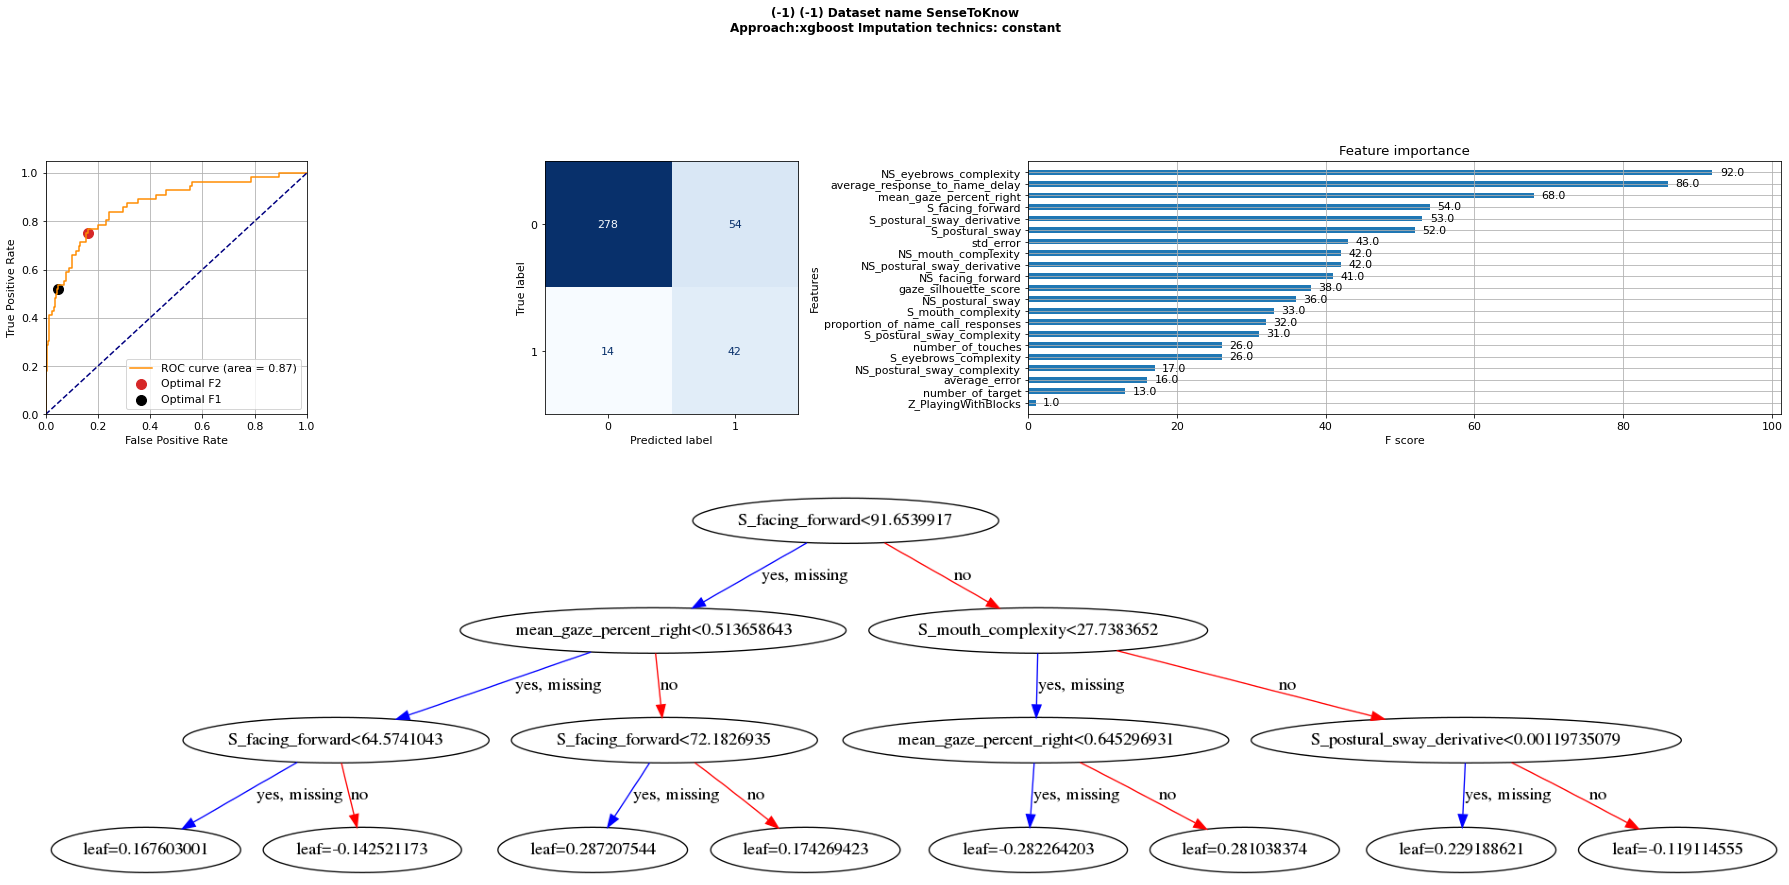

In [383]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)

exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score)
exp.predictions_df['sample_weight'] = weighted_confidence_score
exp.plot()



In [4]:
exp_backup = deepcopy(exp)

# Shap values stability analysis

## Analysis of the stability of the models through Shap values investigation 


The question is to know whether from one model to another (train with or without subject i), the shap values are significantly different or not. If training is ribust, it should not! 

In [635]:
# This graph shows that when ASD are reoved, the expected value of the model is lower i.e. the probability of being NT increase.

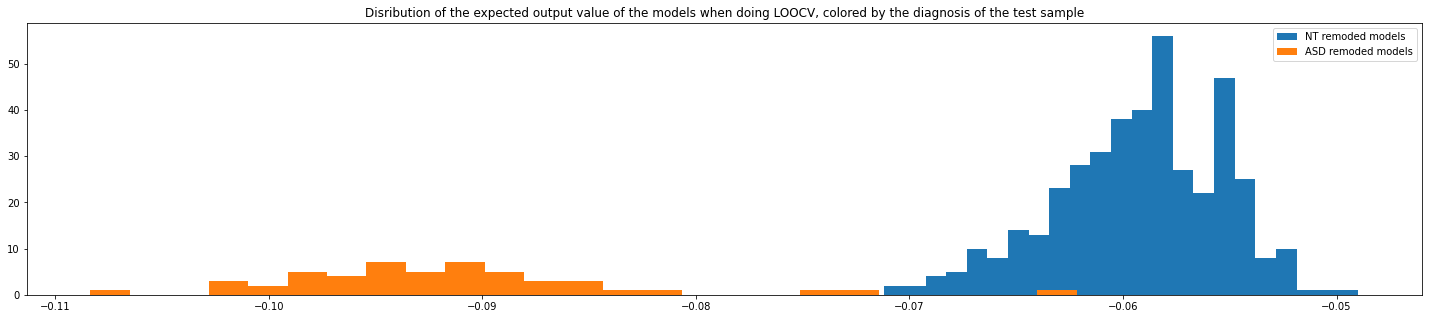

In [12]:
fi(25, 5)
plt.title("Disribution of the expected output value of the models when doing LOOCV, colored by the diagnosis of the test sample")
plt.hist(exp.models_expected_value[np.array(exp.dataset.df[exp.dataset.df['diagnosis']==0].index)], color='tab:blue', bins=25, label='NT remoded models')
plt.hist(exp.models_expected_value[np.array(exp.dataset.df[exp.dataset.df['diagnosis']==1].index)], color='tab:orange', bins=25, label='ASD remoded models')
_ = plt.legend()

In [26]:
# Unique case on the right:
np.argsort(exp.models_expected_value[np.array(exp.dataset.df[exp.dataset.df['diagnosis']==1].index)])
print(np.array(exp.dataset.df[exp.dataset.df['diagnosis']==1].index)[31])
exp.predictions_df[366:367]

mean_gaze_percent_right  gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay  S_postural_sway  NS_postural_sway  S_postural_sway_derivative  NS_postural_sway_derivative  S_postural_sway_complexity  NS_postural_sway_complexity  S_facing_forward  NS_facing_forward  S_eyebrows_complexity  NS_eyebrows_complexity  S_mouth_complexity  NS_mouth_complexity  std_error  number_of_touches  number_of_target  average_error  Z_PlayingWithBlocks  Z_FunAtThePark  Z_BlowingBubbles  Z_RhymesAndToys  y_true    y_pred  TN  TP  FP  FN pred_class  sample_weight
366                      NaN                    NaN                                NaN                        0.617283              NaN          1.990688                         NaN                     0.010127                         NaN                          0.0               NaN          57.655955                    NaN               31.046416                 NaN            28.464212        NaN                0.0               0.0            NaN                  1.0             1.0               1.0              1.0     1.0  0.456584   0   1   0   0         TP       0.102222

**We first differentiate the shap values associated with the present features from the missing features, to disambiguate the contribution of missing features and actual features values.**

In [221]:
n_models, n_participants, n_features = exp.shap_values.shape


extended_shap_values = np.zeros((n_models, n_participants, 2*n_features))
for idx_model in range(n_models):
    
    shap_value_models = exp.shap_values[idx_model, :, :]
    
    mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
    shap_present = np.multiply(shap_value_models, mask_shap_present)
    shap_missing = np.multiply(shap_value_models, (mask_shap_present==0).astype(int))
    
    # Normalized shap value separating real variables and when there are missing.
    general_shap_values = np.concatenate([shap_present, shap_missing], axis=1)
    shap_present_normalized = shap_present / np.abs(shap_present).sum(axis=1)[:, np.newaxis]
    general_shap_values_normalized  = general_shap_values / np.abs(general_shap_values).sum(axis=1)[:, np.newaxis]
    extended_shap_values[idx_model, :, :] = general_shap_values_normalized
    
labels = exp.features_name + ["Z_{}".format(feat_name) for feat_name in exp.features_name]                  


In [189]:
import shap

# Compute the shap values with the model fit with all the data
explainer = shap.TreeExplainer(exp.model)
expected_value_fit = explainer.expected_value
shap_values_fit  = explainer.shap_values(exp.dataset.X_train)

# Disambuguate present and missing variables 
mask_shap_present = (~np.isnan(exp.dataset._X_train)).astype(int)
shap_present = np.multiply(shap_values_fit, mask_shap_present)
shap_missing = np.multiply(shap_values_fit, (mask_shap_present==0).astype(int))

# Normalized shap value separating real variables and when there are missing.
general_shap_values_fit = np.concatenate([shap_present, shap_missing], axis=1)
shap_present_fit_normalized = shap_present / np.abs(shap_present).sum(axis=1)[:, np.newaxis]
shap_values_fit_normalized  = general_shap_values_fit / np.abs(general_shap_values_fit).sum(axis=1)[:, np.newaxis]

# Compute the Shap Values for indiviuals through the cross validation

shap_values = np.zeros(extended_shap_values.shape)
for i in range(exp.dataset.num_samples):
    shap_values[i, :] = extended_shap_values[i, i, :]
    
shap_values_normalized = shap_values / np.abs(shap_values).sum(axis=1)[:, np.newaxis]


In [2]:
0.9 * 0.32 +  0.6 * 0.28 + 1 * 0.17 + 1 * 0.14 + 0.9 * 0.09 

0.8470000000000001

The Following two graphs show the features comtribution for all the participants in two cases:

- Using the normalized sShap values recorded for each participants when doing the cross-validation: those are the actual true Shap value that explain the final prediction. 
- When fitting the model with all the training data (not removing the hold-out test participant). 

Providing that the traning is robust and that the model does not overfit on the training data, these Shap values shoul be very close. 
At first sight it seems relatively close, but there are some changes in the ordering of the features for instance, which might change the conclusion, so we need to dive deeper and quantify these Sahp values variations. 




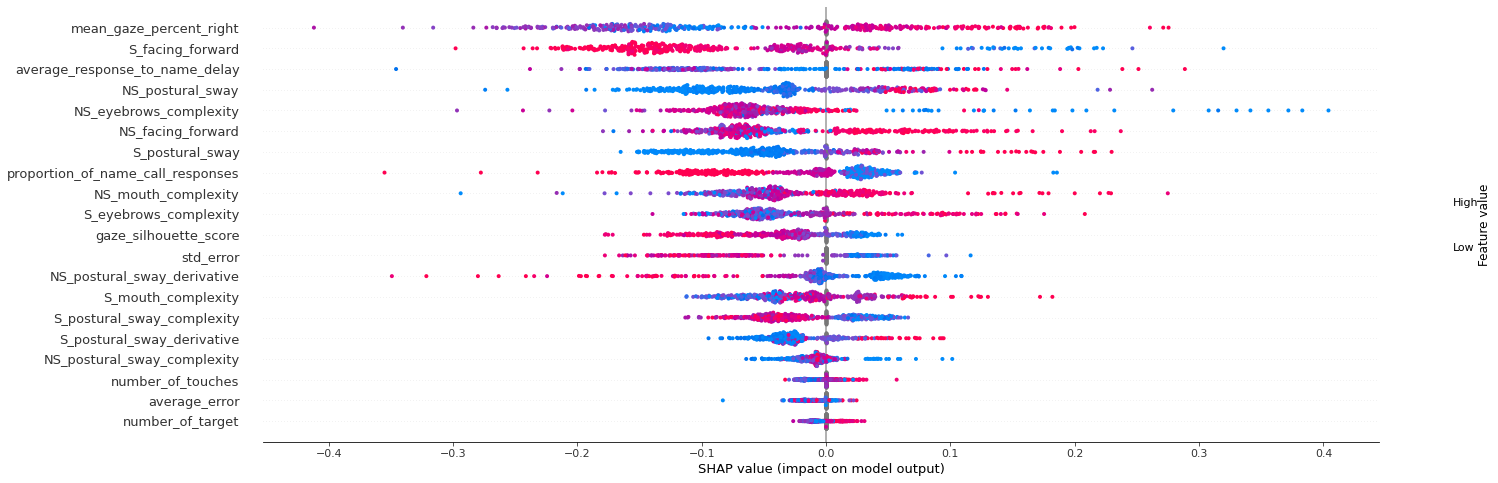

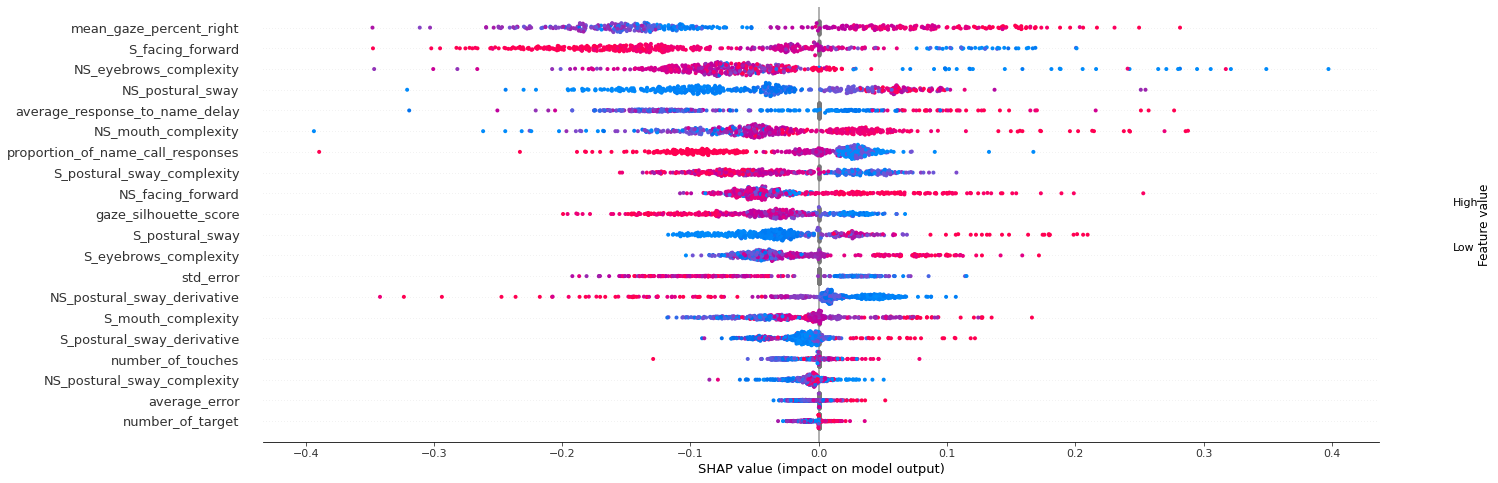

In [208]:
shap.summary_plot(shap_present_normalized, exp.dataset._X_train, feature_names=exp.features_name, plot_size=(25, 8), title="Shap Values with CV")
shap.summary_plot(shap_present_fit_normalized, exp.dataset._X_train, feature_names=exp.features_name, plot_size=(25, 8), title="Shap Values fitting all the model")

In order to quantify the fluctuations of the Shap Values due to different traning data being used, let's look at: 
- Local variation: for each of the participants, what is the variance of their Shap value over different tranining ? 
- Global variation: Over the different traning, what is the variance of the contribution of each features ? 

Subject:419


id  diagnosis language app_version                                        subject                                     administration  features_extracted  face_tracking        age timestamp       date   time study stimuli_version sex            ethnicity             race  primary_education  asd_yn  mullen_el  mullen_fm  mullen_rl  mullen_vr  mullen_elc_std  ados_total  ados_rrb  ados_sa  srs_total_tscore  srs_social_awareness_tscore  srs_social_motivation_tscore  cbcl_scaleIV_score  cbcl_asd_score  mchat_total  mchat_final  mchat_result  BB_gaze_percent_right  BB_gaze_silhouette_score  S_gaze_percent_right  S_gaze_silhouette_score  FP_gaze_speech_correlation  FP_gaze_silhouette_score  proportion_of_name_call_responses  average_response_to_name_delay valid_name_calls  FB_postural_sway  FB_postural_sway_derivative  DIGC_postural_sway  DIGC_postural_sway_derivative  DIGRRL_postural_sway  DIGRRL_postural_sway_derivative  ST_postural_sway  ST_postural_sway_derivative  \
419  850897        1.0  English         2.1  <Subject.S2KSubject object at 0x7fea92a0f990>  <Administration.S2KAdministration object at 0x...                   1              1  20.360656    Admin1 2020-02-11  00:00   ARC       Preschool   M  Not Hispanic/Latino  White/Caucasian                8.0     NaN       30.0       29.0       20.0       30.0            51.0         8.0      10.0      7.0               NaN                          NaN                           NaN                 3.0             5.0          6.0          4.0           1.0                0.58159                  0.486084              0.529963                 0.655589                     0.49031                  0.666716                                0.0                             NaN        [1, 1, 1]          2.033254                      0.01525            0.165608                       0.000211              0.191543                         0.000405          0.166645                     0.000285   

     MP_postural_sway  MP_postural_sway_derivative  PB_postural_sway  PB_postural_sway_derivative  BB_postural_sway  BB_postural_sway_derivative  RT_postural_sway  RT_postural_sway_derivative  MML_postural_sway  MML_postural_sway_derivative  PWB_postural_sway  PWB_postural_sway_derivative  FP_postural_sway  FP_postural_sway_derivative  number_of_touches  average_length  std_length  average_error  std_error  number_of_target  pop_rate  average_touch_duration  std_touch_duration  average_delay_to_pop  std_delay_to_pop  repeat_percentage  repeat_percentage_naive  double_tap  mean_velocity  std_velocity  average_force_applied  std_force_applied  average_accuracy_variation  accuracy_consistency  average_touches_per_target  std_touches_per_target  average_time_spent  std_time_spent  exploratory_percentage  validity_available  completed  StateOfTheChild  SiblingsInTheRoom ShotsVaccines  Distractions  FamilyMemberDistract  PetDistract  PetNoiseDistract  DoorbellPhoneDistract  TVOnDistract  \
419          1.985771                     0.013921               NaN                          NaN          0.334831                     0.001559          0.551756                     0.003079           0.724744                      0.005122           0.922212                      0.005056          2.827383                      0.01626               15.0       14.609402   17.555556      12.246151   6.028955               8.0  0.533333                  0.4468             0.47746              3.178714           1.01723               0.25                 0.666667    0.142857         0.4468       0.47746               0.057852           0.060961                    0.131664              0.382404                        1.25                0.661438               1.646             0.0               55.555556                   1        0.0              3.0                NaN           NaN           0.0                   0.0          0.0               0.0                    0.0           0.0   

     OtherDistract  SittingUp  Hu

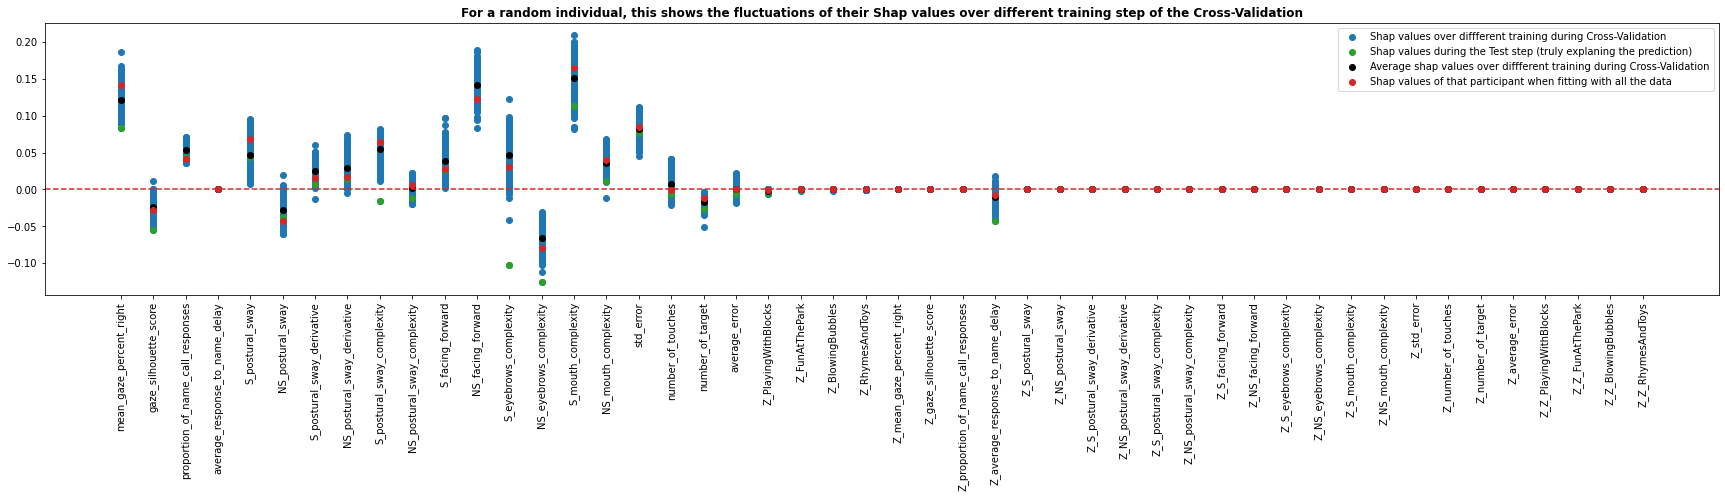

In [237]:
subject_of_interest = np.random.randint(467)
print("Subject:{}".format(subject_of_interest))
display(exp.dataset.df.iloc[subject_of_interest:subject_of_interest+1])

fi(30, 5)
n_model = exp.shap_values.shape[0]
plt.title("For a random individual, this shows the fluctuations of their Shap values over different training step of the Cross-Validation", weight='bold')
for i, feature_name  in enumerate(labels):
    plt.scatter([i]*n_model, extended_shap_values[:, subject_of_interest, i], color='tab:blue', label="Shap values over diffferent training during Cross-Validation" if i==0 else None)
    plt.scatter([i], extended_shap_values[subject_of_interest, subject_of_interest, i], color='tab:green', label="Shap values during the Test step (truly explaning the prediction)" if i==0 else None)
    plt.scatter([i], extended_shap_values.mean(axis=0)[subject_of_interest, i], color='k', label="Average shap values over diffferent training during Cross-Validation" if i==0 else None)
    plt.scatter([i], shap_values_fit_normalized[subject_of_interest, i], color='tab:red', label="Shap values of that participant when fitting with all the data" if i==0 else None)

plt.axhline(0, linestyle='--', color='tab:red')
plt.legend()


_  = plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.show()

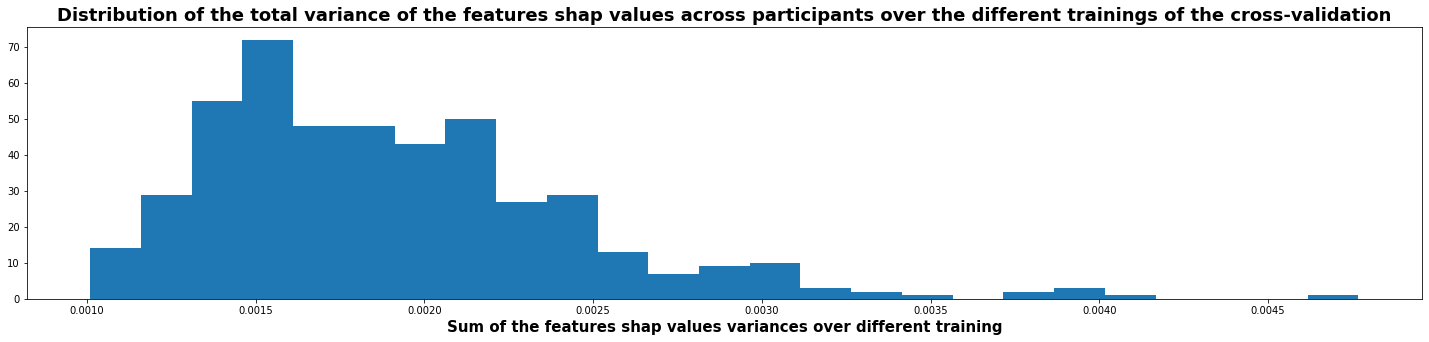

In [226]:
var_list = []
for subject_of_interest in range(467):
    var = 0
    for i, feature_name  in enumerate(labels):
        var+=np.var(extended_shap_values[:, subject_of_interest, i])
    var_list.append(var)
    
    
fi(25, 5)
plt.title("Distribution of the total variance of the features shap values across participants over the different trainings of the cross-validation", weight='bold', fontsize=18)
plt.hist(var_list, bins=25)
_ = plt.xlabel("Sum of the features shap values variances over different training", weight='bold', fontsize=15)


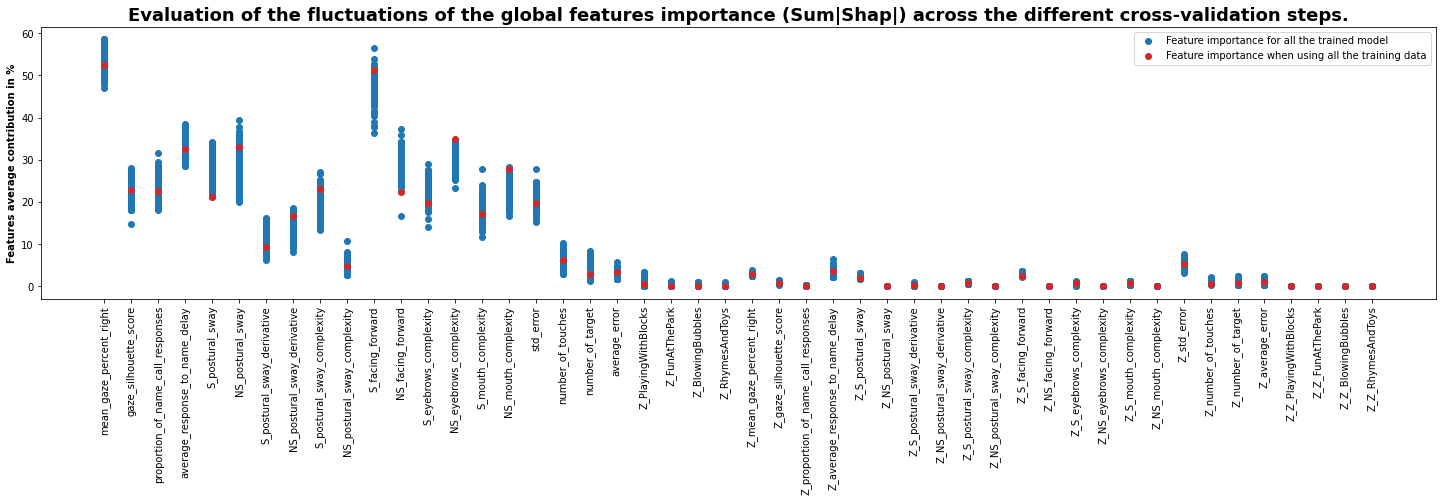

In [228]:
# Compute the global feature importance for each of the trained model and features, by summing over the rows of each @d Matrix shap values
features_importance_all_models_cv = np.abs(extended_shap_values).sum(axis=1)

# Plot the features importance of a few models
fi(25, 5)
plt.title("Evaluation of the fluctuations of the global features importance (Sum|Shap|) across the different cross-validation steps.", weight='bold', fontsize=18)
for idx_model in range(extended_shap_values.shape[0]):
    feature_importance = features_importance_all_models_cv[idx_model]#.std(axis=0)
    plt.scatter(np.arange(feature_importance.shape[0]), feature_importance, color='tab:blue', label = "Feature importance for all the trained model" if idx_model==0 else None)
    
plt.scatter(np.arange(feature_importance.shape[0]), np.abs(shap_values_fit_normalized).sum(axis=0), color='tab:red', label = "Feature importance when using all the training data")
plt.legend(); plt.ylabel("Features average contribution in %", weight='bold')
_ = plt.xticks(np.arange(feature_importance.shape[0]), labels, rotation=90)

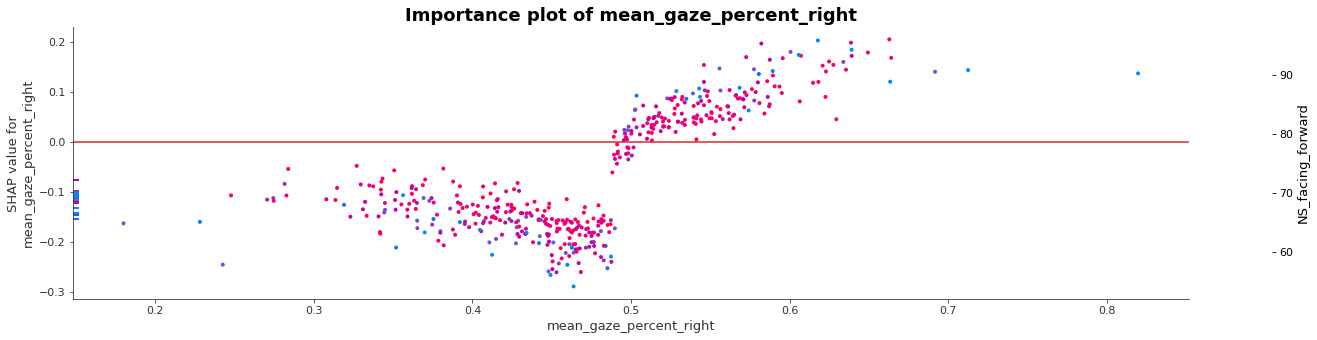

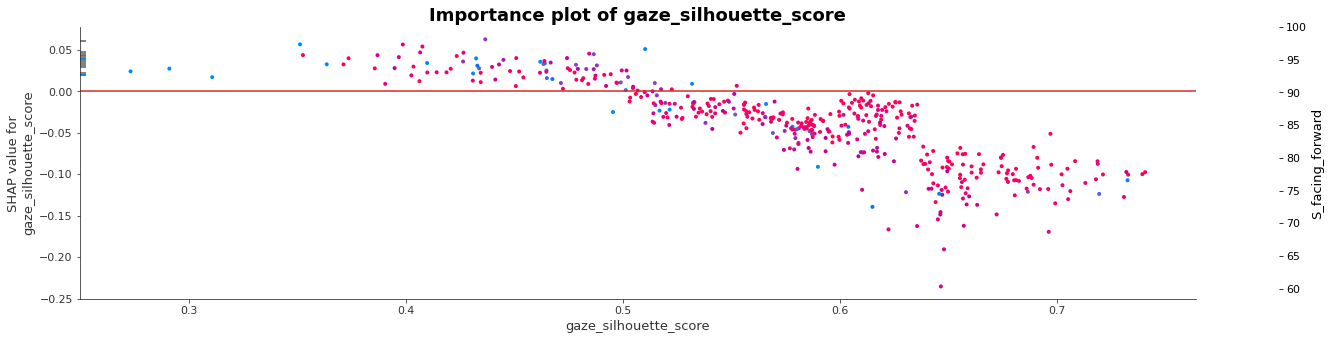

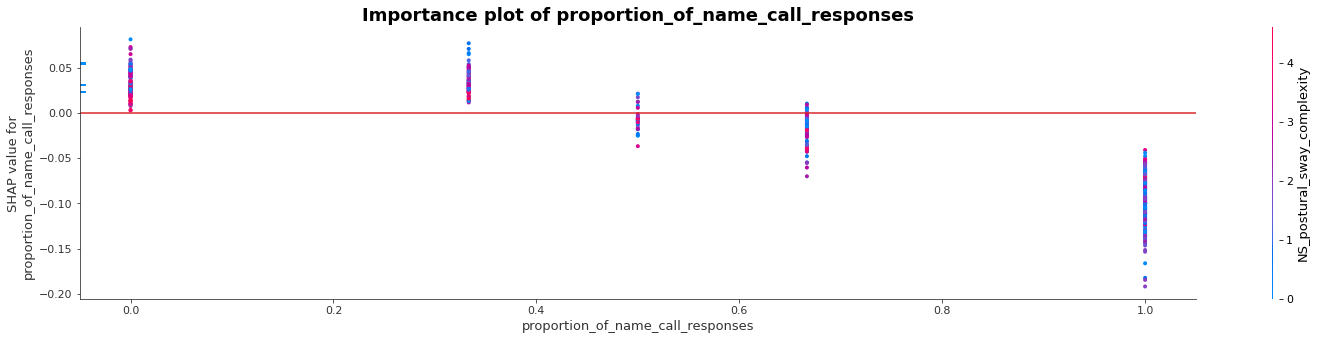

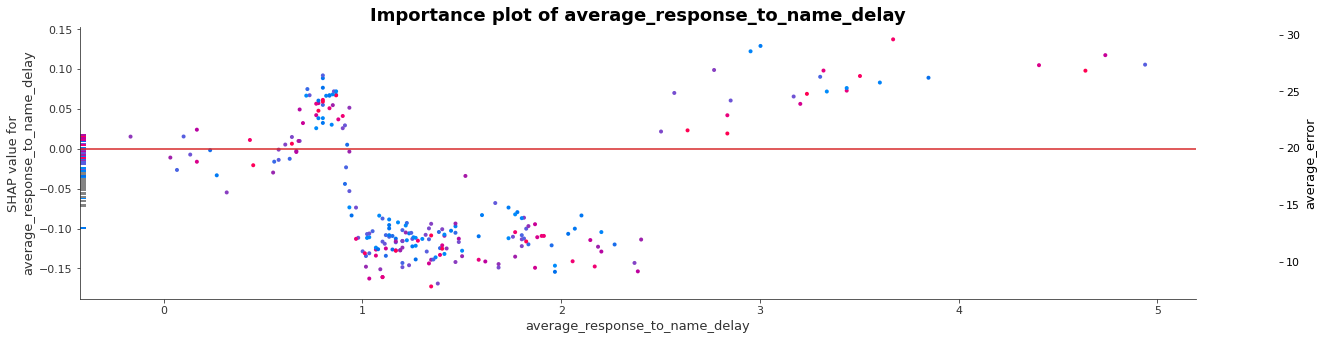

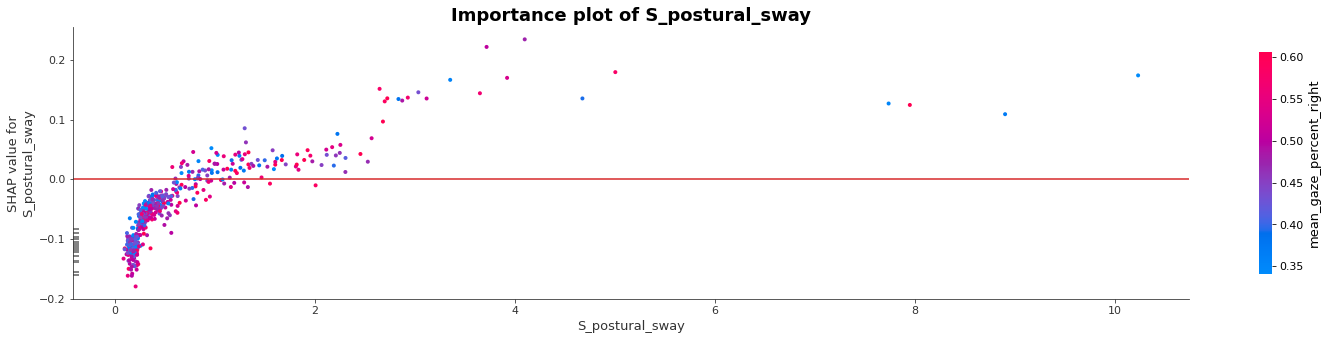

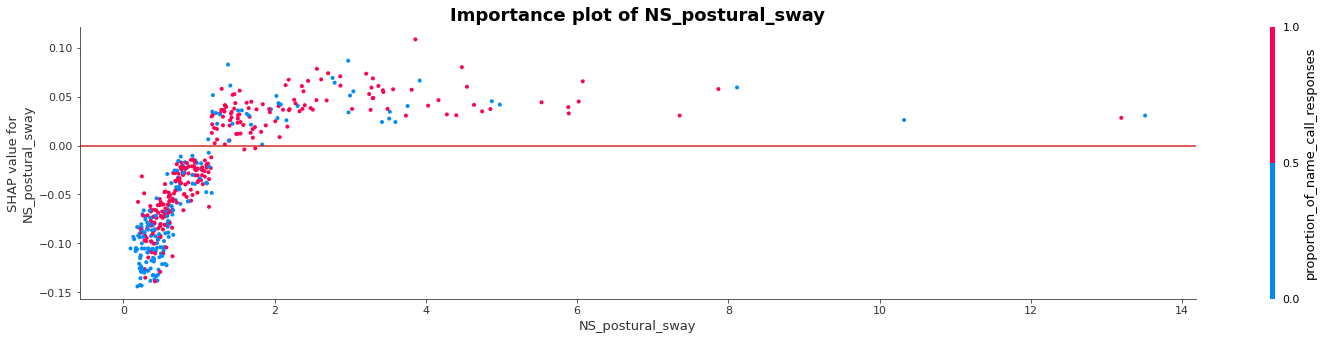

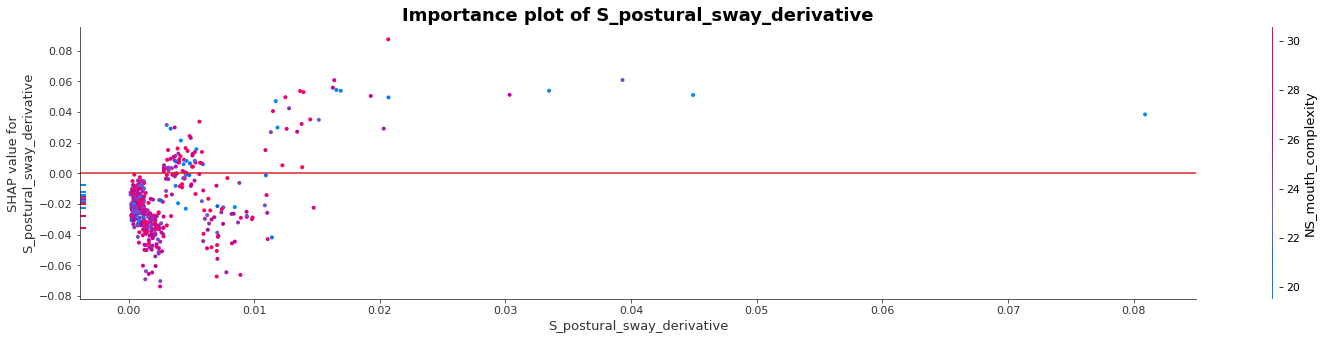

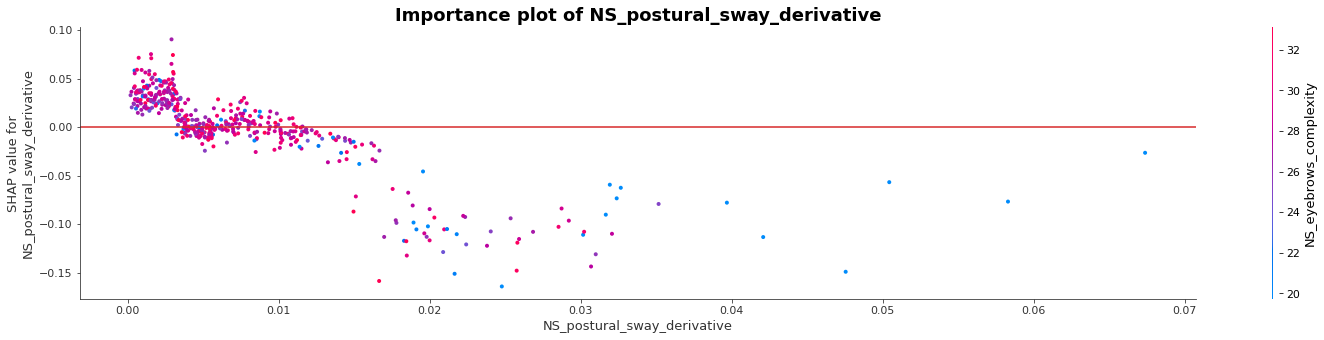

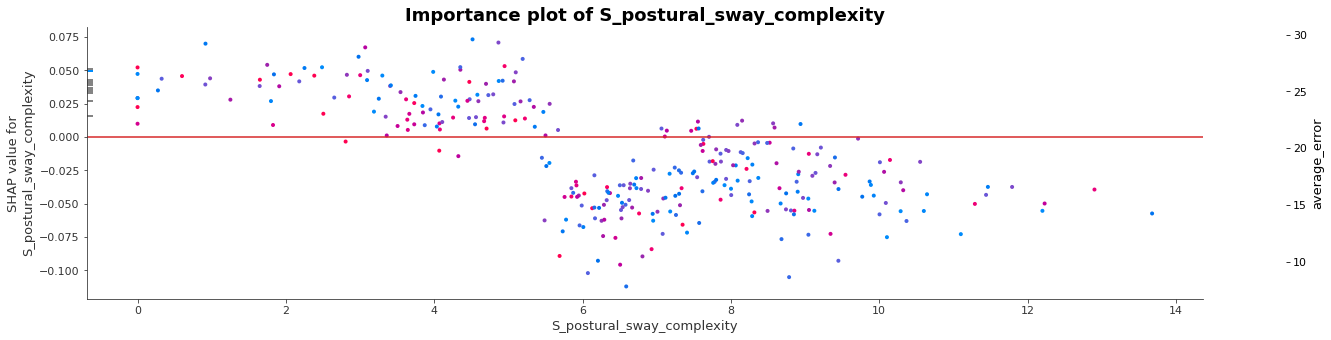

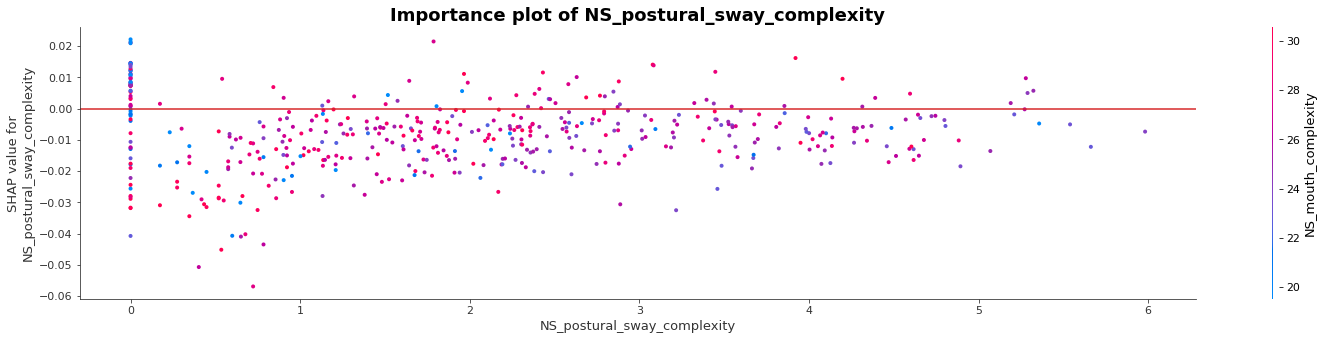

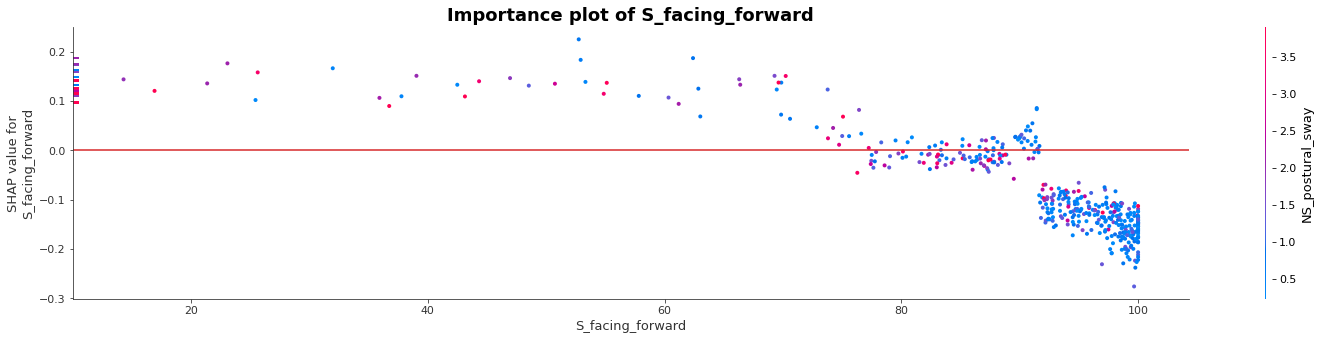

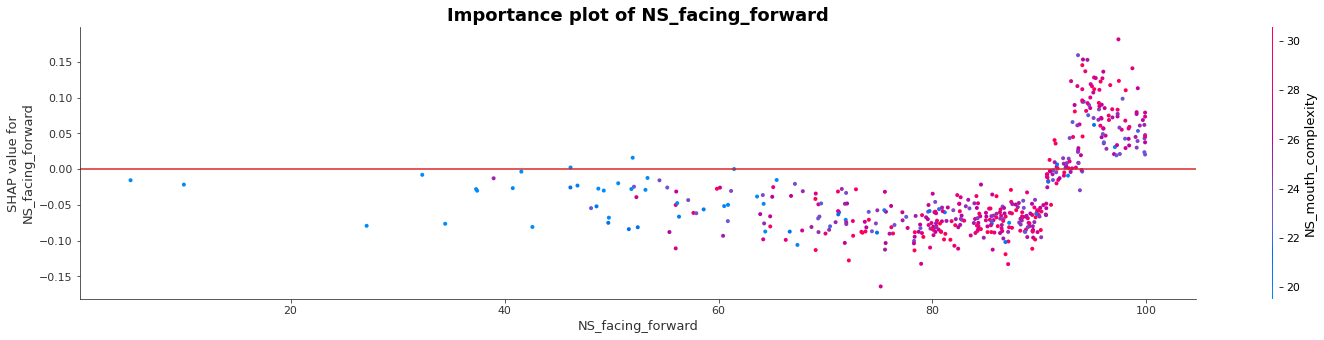

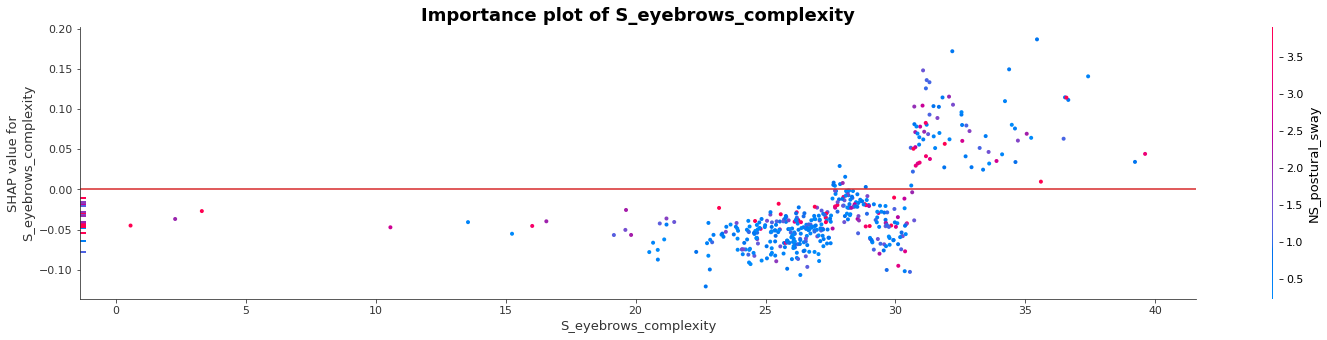

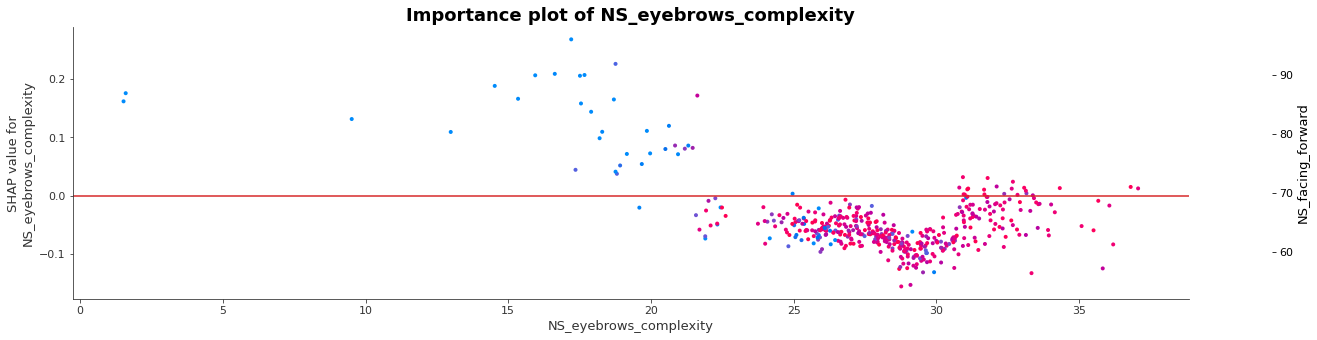

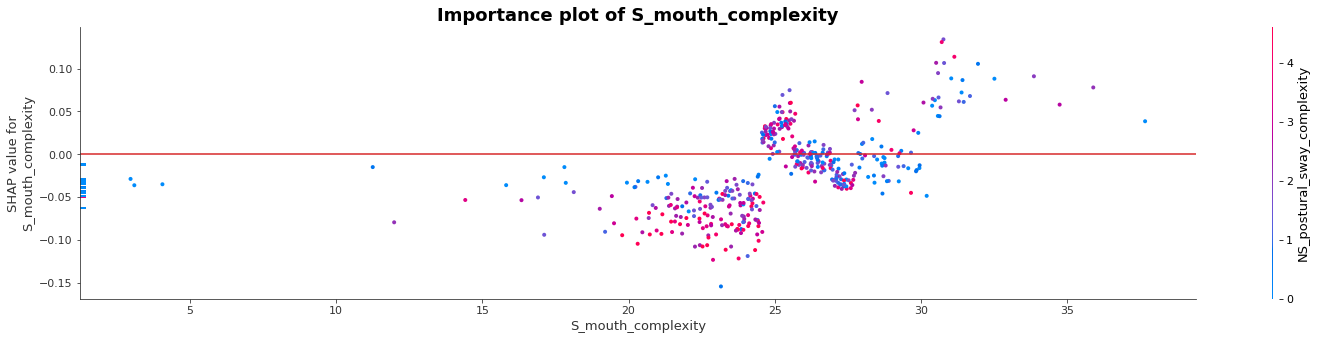

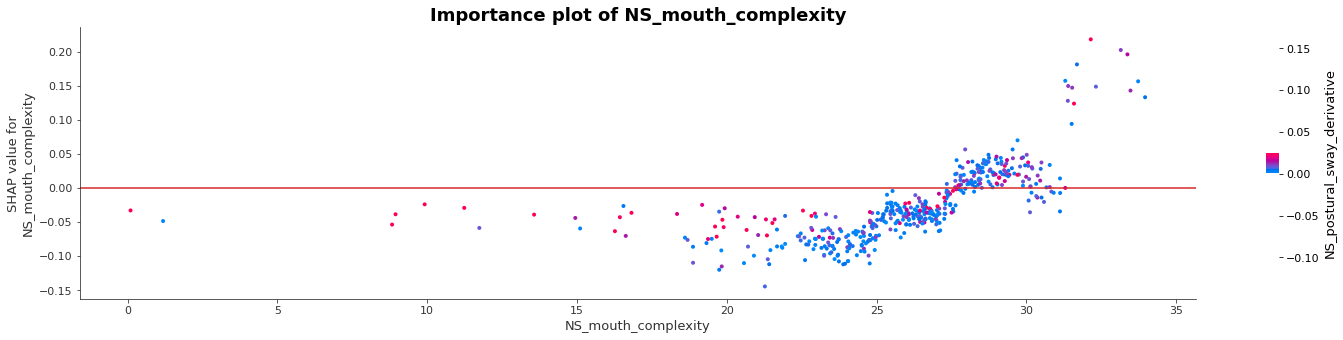

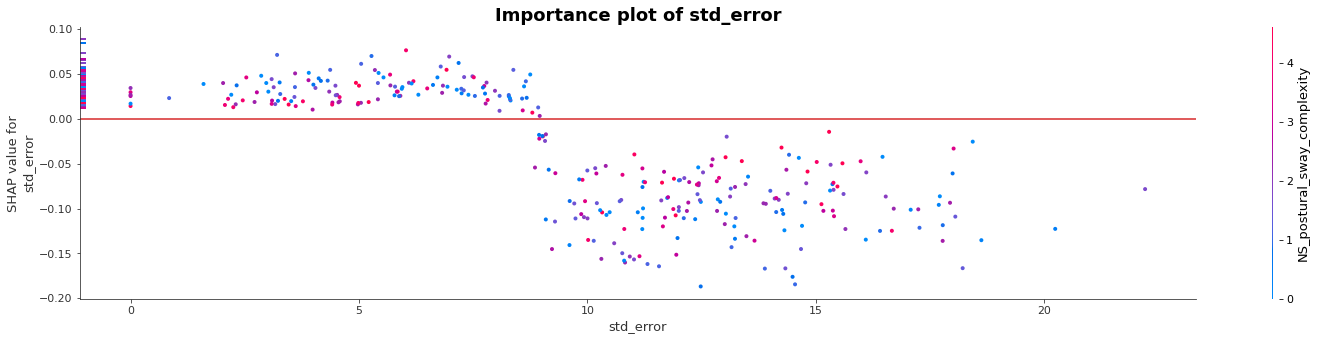

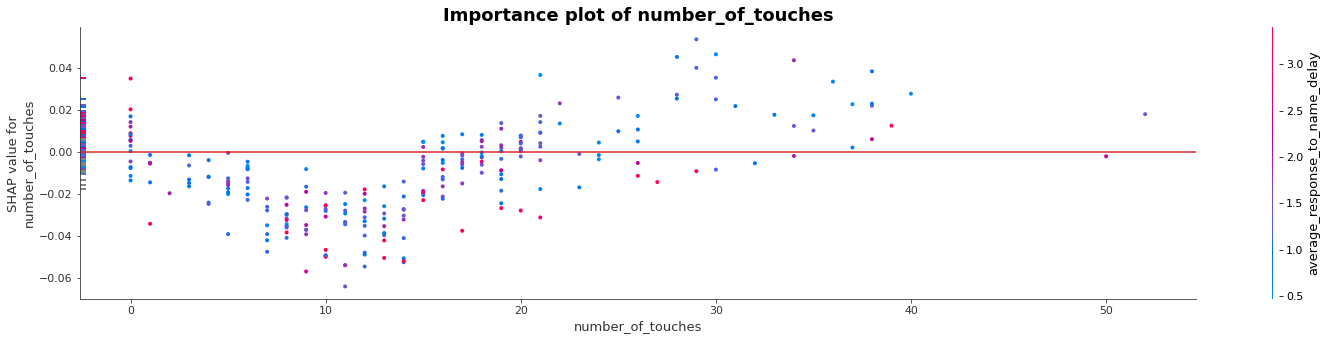

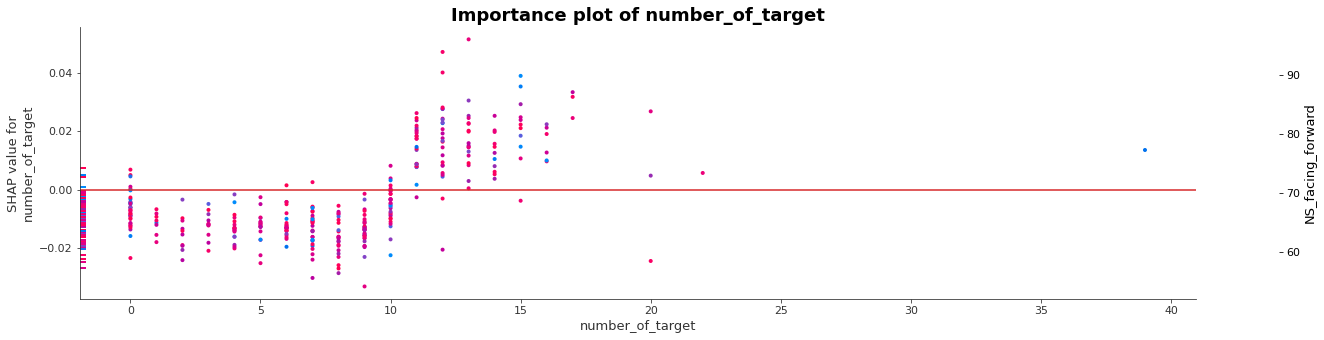

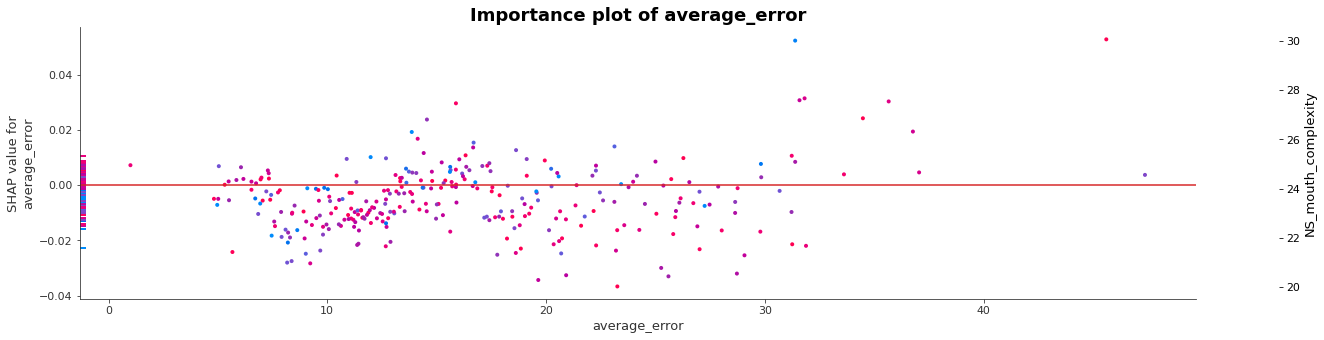

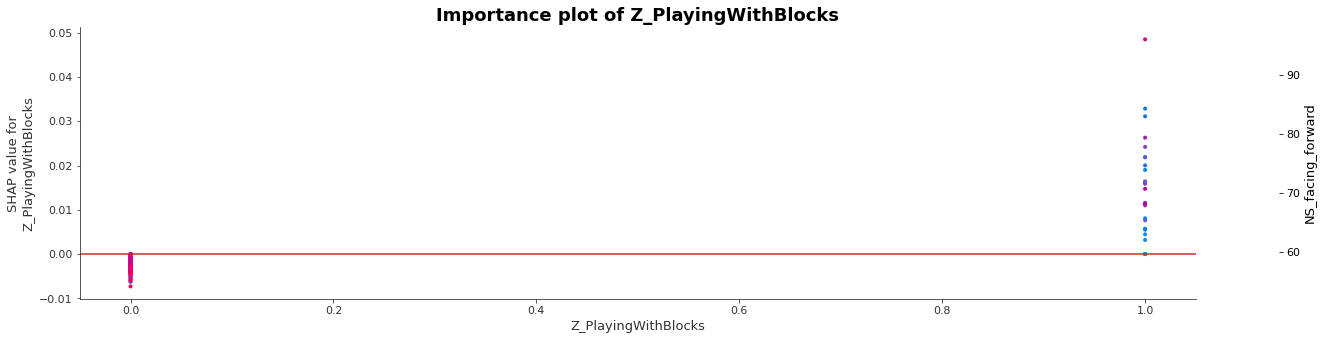

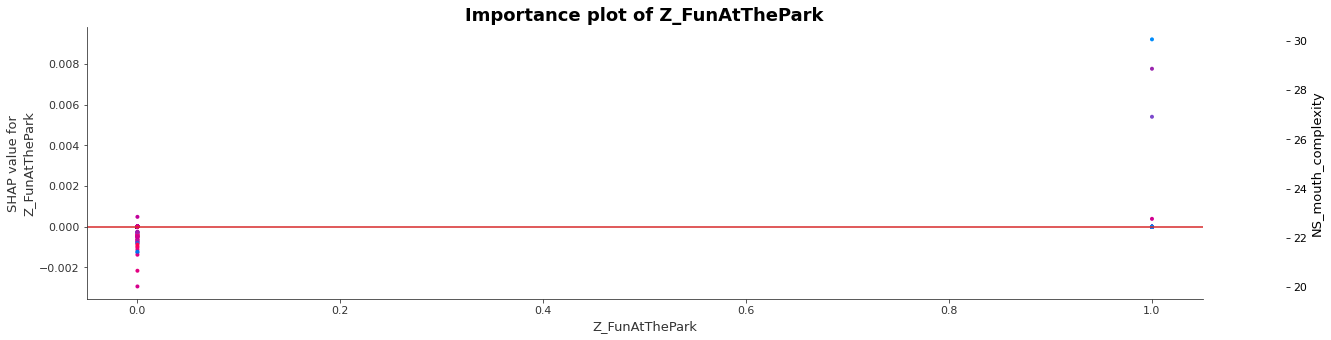

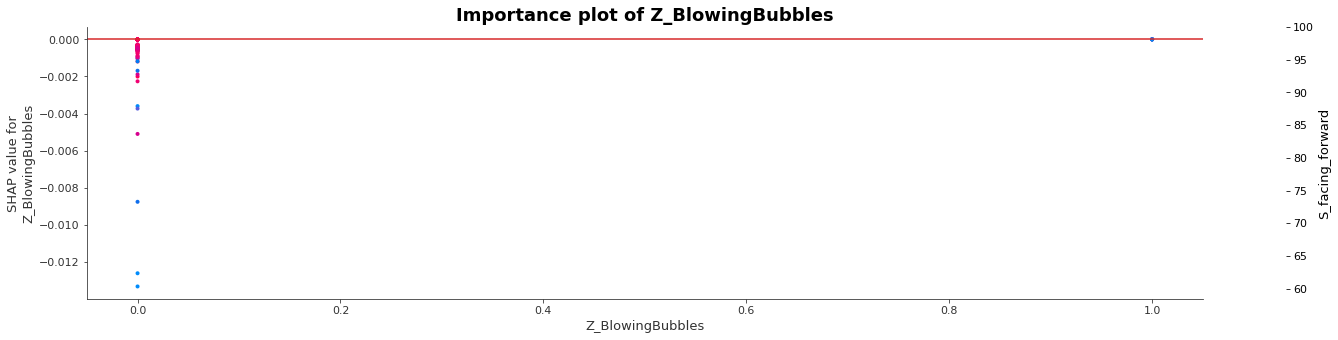

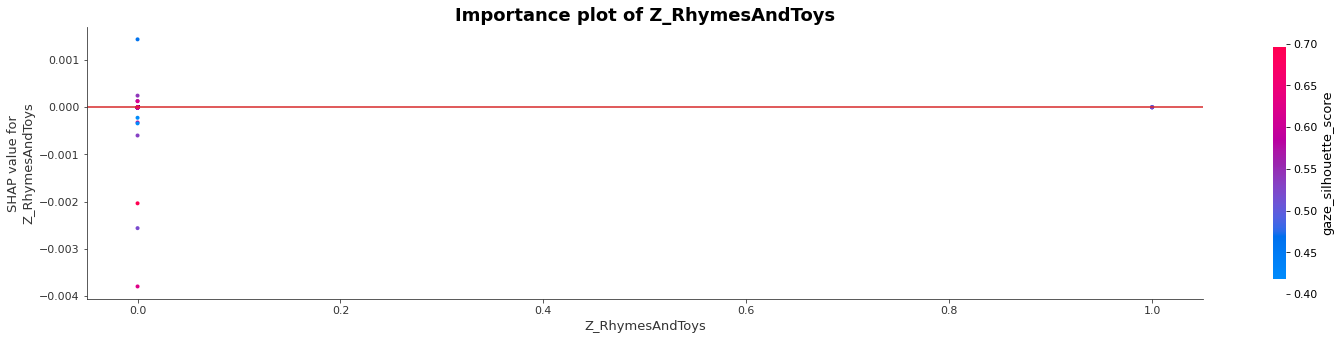

In [244]:
X = deepcopy(exp.dataset._X_train)
shap_values = np.zeros((n_participants, n_features))

for i in range(exp.dataset.num_samples):
    shap_values[i, :] = exp.shap_values[i, i, :]
    
    
for feat in exp.features_name:
    
    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax.axhline(0, color='tab:red')
    ax.set_title("Importance plot of {}".format(feat), weight='bold', fontsize=18)
    shap.dependence_plot(feat, shap_values, X, exp.features_name, ax=ax)
    
    

# Interaction effects


This section aims at studying the effect of the interactions between app features in the contributions of each app variables to the model and to the predictions.

1) We first train the model and store the Shap variables
2) We compute the Shap interaction effects, whicgh takes the form of a matrix of sixe N x K x K. For a sample, the sum of the matrix equal the prediction, 
   and the sum over rows (or columns) equal the shap value of that each features.
3) We study the average normalized contributions of principal and interaction effects across the dataset, by averaging all matrices across the dataset
4) We then take a few cases and draw their Shap matrix.

In order to assess which features interact the more and justify reporting them in the paper, we also add at step 3) and 4) a summary dataframe showing the most important information for each features:
- Its total principal contribution
- The sum of their interaction contribution 
- The feature having thr most interaction


In [565]:
def display_interaction_summary(matrix_shap):
    
    principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
    interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

    dict_shap = {}
    for i, feat in enumerate(exp.features_name):

        main_effect = np.abs(matrix_shap)[i,i]
        interaction_effect = np.abs(matrix_shap)[i].sum() - main_effect

        row_shap = deepcopy(np.abs(matrix_shap)[i])
        row_shap[i] = 0
        first_interaction = np.max(row_shap)
        first_interaction_name = exp.features_name[np.argmax(row_shap)]

        dict_shap[feat] = {'total': main_effect+interaction_effect, 'main': main_effect, 'interaction': interaction_effect, 'first_interaction': first_interaction, 'first_interaction_name': first_interaction_name}
    final_interactions_summary = pd.DataFrame(dict_shap).transpose().sort_values('total', ascending=False)
    final_interactions_summary.append(pd.DataFrame([[100, principal_effect_sum, interaction_effect_sum, '', '']], index=['SUM'], columns = final_interactions_summary.columns))

    return final_interactions_summary

**1) Model training**

In [ ]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)

exp.fit_predict(num_cv=510, sample_weight=weighted_confidence_score)
exp.predictions_df['sample_weight'] = weighted_confidence_score
exp.plot()

**2) Computation of the normalized Shap Interaction matrices**

In [568]:
explainer = shap.TreeExplainer(exp.model)
shap_values = explainer.shap_values(exp.dataset.X_train)

#Collect interaction shap values
shap_interaction_values = explainer.shap_interaction_values(exp.dataset.X_train)

# Normalize them per subjects to have percentages
# Note that the interaction values is oh shape [N x K x K], and that for a sample, the sum of the matrix equal the prediction, and the sum over rows (or columns) 
# equal the shap value of that each features! 
shap_interaction_values_normalized = shap_interaction_values/np.abs(shap_interaction_values).sum(axis=1).sum(axis=1)[:, np.newaxis, np.newaxis]

**3) Average normalized Shap Matrix**

## SHAP Summary Plot¶


The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of being autistic for the trained XGBoost model. 

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk.

# Comparisons of the Shap values between cross-validation and when fitting with all the data

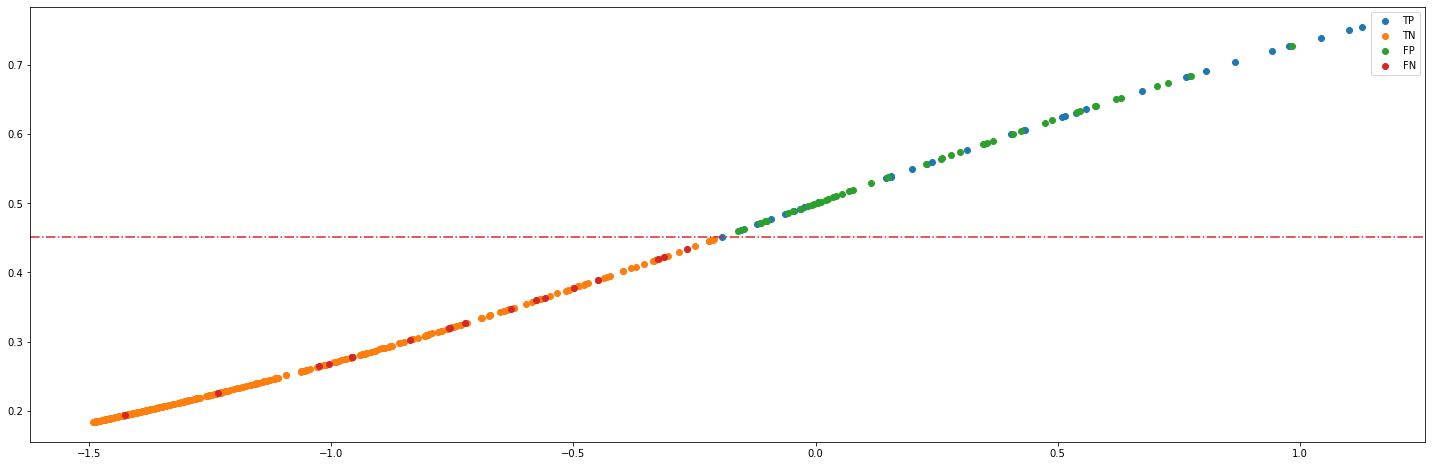

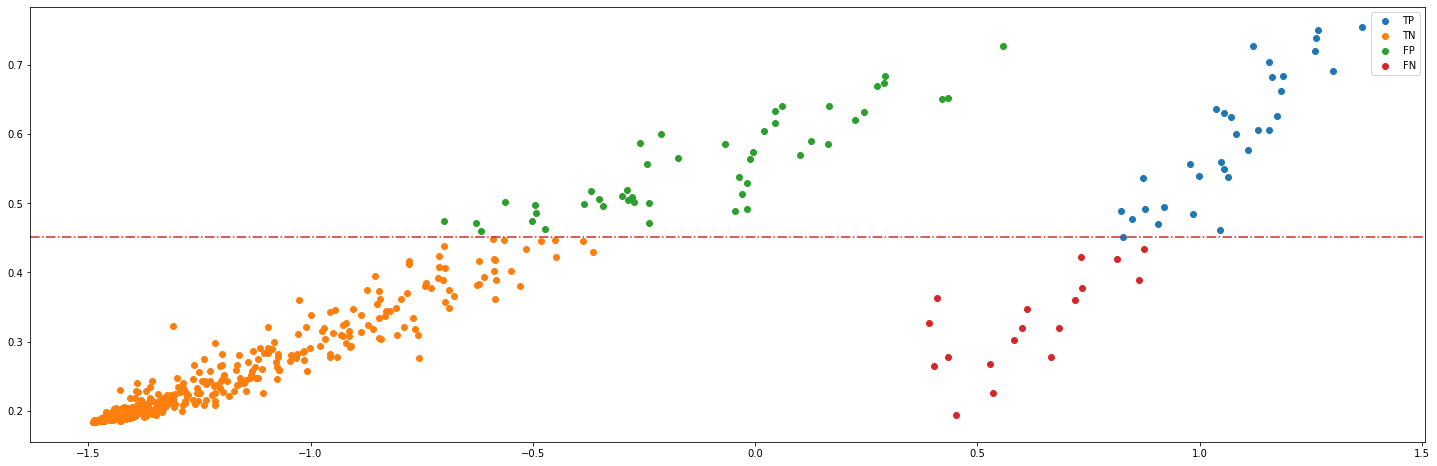

In [153]:
import shap

explainer = shap.TreeExplainer(exp.model)
shap_values = explainer.shap_values(exp.dataset.X_train)
models_expected_value = explainer.expected_value

exp.predictions_df['f_x'] = np.nan
exp.predictions_df['f_x_all'] = np.nan


for idx in range(exp.dataset.num_samples):
    exp.predictions_df.loc[idx, 'f_x'] = exp.shap_values[idx].sum() +  exp.models_expected_value[idx]
    exp.predictions_df.loc[idx, 'f_x_all'] = explainer.shap_values(exp.dataset.X_train)[idx].sum() +  explainer.expected_value
    
exp.predictions_df.sort_values(by='f_x')[['y_pred', 'y_true','f_x', 'TP', 'TN', 'FP', 'FN']]#[:30]

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

fi(25, 8);ax=plt.gca()
for name in ['TP', 'TN', 'FP', 'FN']:
    plt.scatter(exp.predictions_df[exp.predictions_df[name]==1]['f_x_all'].to_numpy(), exp.predictions_df[exp.predictions_df[name]==1]['y_pred'].to_numpy(), label=name)
plt.axhline(exp.optimal_threshold, color='tab:red', linestyle='-.');plt.legend()

# Closer look at the Misclassified samples

In [39]:
import shap
explainer = shap.TreeExplainer(exp.model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: [0.11800709]


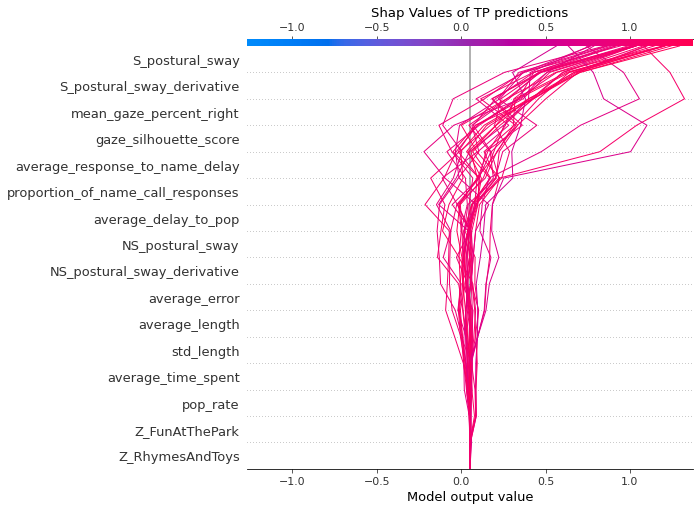

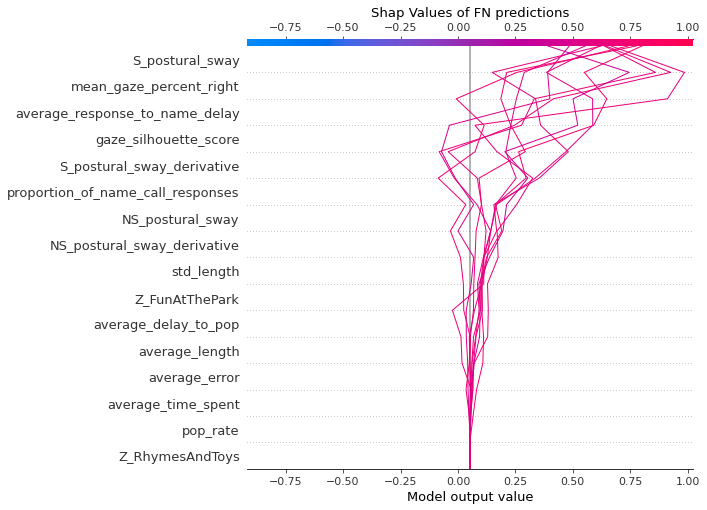

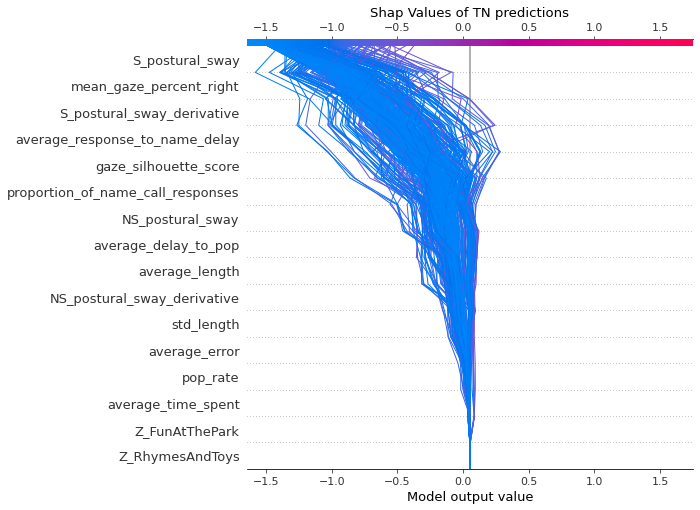

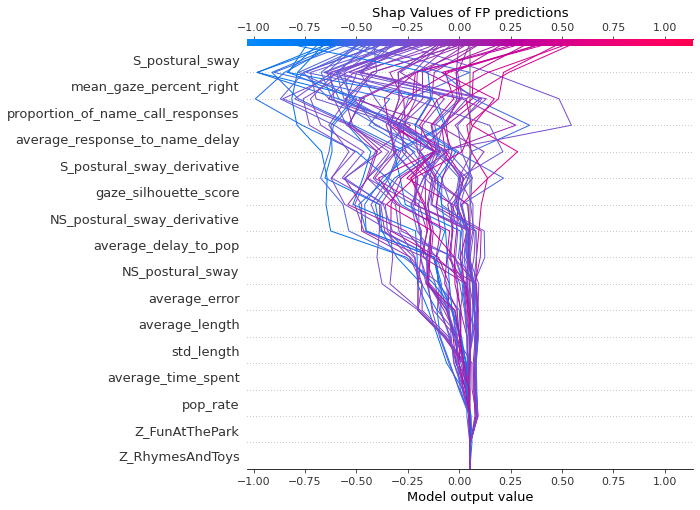

In [157]:
for name in ['TP','FN', 'TN', 'FP']:


    index  = np.array(list(exp.predictions_df[exp.predictions_df[name]==1].index))
    features = exp.predictions_df[exp.features_name]

    shap_values = explainer.shap_values(features)[index]
    shap_interaction_values = explainer.shap_interaction_values(features)
    hap_interaction_values = shap_interaction_values[index]
    shap.decision_plot(expected_value, shap_values, features, title="Shap Values of {} predictions".format(name))

# Paper: Plot SHAP fitures individual effects

In [16]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)




377 administrations left.


id
diagnosis     
0.0        328
1.0         49

**Compute Shap Values using the experiment that were run with all features, in the `paper_uncertianinty` notebook**

In [4]:
exp_path = '/home01/sam/notes_on_stats/doc/src/data/15_December_Final_With_Weight/SenseToKnow/'
json_paths = glob(os.path.join(exp_path, '*', 'experiment*.json'))
i = 0
shap_interactions_all_cv = []
for json_path in json_paths:
    #try:
        
    with open(json_path, 'r') as f:
        data = json.load(f)

    shap_interactions_all_cv.append([np.array(data['shap_interaction_value'])])
    # except:
    #     print("Error parsing json")


shap_interactions = np.concatenate(shap_interactions_all_cv)

# Normalize the Shap Values for each sample so that there are comparables. 
shap_interactions_normalized = shap_interactions / np.abs(shap_interactions).sum(axis=3).sum(axis=2)[:, :, np.newaxis, np.newaxis]

# Average the Shap values over the different experiments 
averaged_shap_interactions = shap_interactions_normalized.mean(axis=0)

# Re-normalize the Shap values
averaged_shap_interactions_normalized  = averaged_shap_interactions/np.abs(averaged_shap_interactions).sum(axis=2).sum(axis=1)[:, np.newaxis, np.newaxis]

In [5]:
principal_effect_sum = np.mean([np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])
principal_effect_sum_std = np.std([np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])

interaction_effect_sum = np.mean([np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])
interaction_effect_sum_std = np.std([np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum() for matrix_shap in averaged_shap_interactions_normalized])

print("Principal contribution of each features: {:.3f} (+/- {:.3f}), and interaction effect: {:.3f} (+- {:.3f}%)".format(principal_effect_sum, principal_effect_sum_std, interaction_effect_sum, interaction_effect_sum_std ))





Principal contribution of each features: 0.633 (+/- 0.028), and interaction effect: 0.367 (+- 0.028%)


In [61]:

#iloc[0].iloc[df_shap_interaction_importance.iloc[0].argsort().max()]



'Head movements during social movies'

In [76]:
X

Social preference  Gaze silhouette score  Attention to speech  Response to name proportion  Response to name delay [s]  Head movements during social movies  Head movements during non-social movies  Head movements acceleration during social movies  Head movements acceleration during non-social movies  Head movements predictability during social movies  Head movements predictability during non-social movies  Facing forward during social movies  Facing forward during non-social movies  Eyebrows predictability during social movies  Eyebrows predictability during non-social movies  Mouth predictability during social movies  Mouth predictability during non-social movies  Pop The Bubbles Popping rate  Pop The Bubbles Accuracy variations  Pop The Bubbles Average touch length  Pop The Bubbles Average force applied
0             0.673012               0.739250             0.525349                     0.000000                         NaN                             0.178447                                 0.326318                                          0.000283                                           0.001556                                              7.557283                                            4.080928                                 98.758051                                96.178971                                     30.071408                                         31.000254                                  22.992548                                      27.264211                           NaN                                  NaN                                   NaN                                    NaN
1             0.565831               0.351124             0.087725                     1.000000                    0.556111                             3.032870                                 2.007431                                          0.016889                                           0.006172                                              0.000000                                            0.346574                                 39.031226                                40.767093                                     27.969757                                         18.202040                                  29.906744                                      19.741690                      0.888889                             6.715827                              6.856880                               0.162116
2             0.576721               0.659444             0.182405                     0.000000                         NaN                             0.478005                                 1.223822                                          0.002659                                           0.009418                                              8.293016                                            1.451391                                 84.409290                                71.804588                                     26.331549                                         25.940137                                  27.363351                                      26.578623                           NaN                                  NaN                                   NaN                                    NaN
3             0.510189               0.608424             0.056406                     0.666667                    2.469133                             1.328129                                 2.397114                                          0.004554                                           0.012627                                              3.651270                                            0.647567                                 82.993961                                67.376848                                     28.541997                                         21.578304                                  26.958703                                      19.827632                           NaN          

In [114]:
df_shap_interaction_importance.loc[feature_name].nlargest(2).values

array([0.07234371, 0.00771777])

In [120]:
df_shap_interaction_importance#.nlargest(2)


val = []
name = []
feats = []

for i, feat in enumerate(exp.features_name):
    
    feature_name = feature_name_mapping[feat]
    
    feats.append(feature_name)
    name.append(df_shap_interaction_importance.loc[feature_name].nlargest(2).index[1])
    val.append(df_shap_interaction_importance.loc[feature_name].nlargest(2).values[1]*100)
    

best_interaction = pd.DataFrame({'Best interacting':name, 'Value': val} , index = feats).round(2)
best_interaction

Best interacting  Value
Social preference                                   Eyebrows predictability during non-social movies   0.77
Gaze silhouette score                                            Facing forward during social movies   0.38
Attention to speech                                     Eyebrows predictability during social movies   0.23
Response to name proportion                            Mouth predictability during non-social movies   0.35
Response to name delay [s]                              Eyebrows predictability during social movies   0.43
Head movements during social movies                                      Response to name proportion   0.27
Head movements during non-social movies                          Facing forward during social movies   0.39
Head movements acceleration during social movies                 Facing forward during social movies   0.10
Head movements acceleration during non-social m...           Head movements during non-social movies   0.23
Head movements predictability during social movies               Facing forward during social movies   0.26
Head movements predictability during non-social...                                 Social preference   0.21
Facing forward during social movies                                                Social preference   0.66
Facing forward during non-social movies                                            Social preference   0.51
Eyebrows predictability during social movies                              Response to name delay [s]   0.43
Eyebrows predictability during non-social movies                                   Social preference   0.77
Mouth predictability during social movies                        Facing forward during social movies   0.34
Mouth predictability during non-social movies                            Response to name proportion   0.35
Pop The Bubbles Popping rate                                              Response to name delay [s]   0.13
Pop The Bubbles Accuracy variations                              Facing forward during social movies   0.39
Pop The Bubbles Average touch length                    Eyebrows predictability during social movies   0.07
Pop The Bubbles Average force applied                            Head movements during social movies   0.14

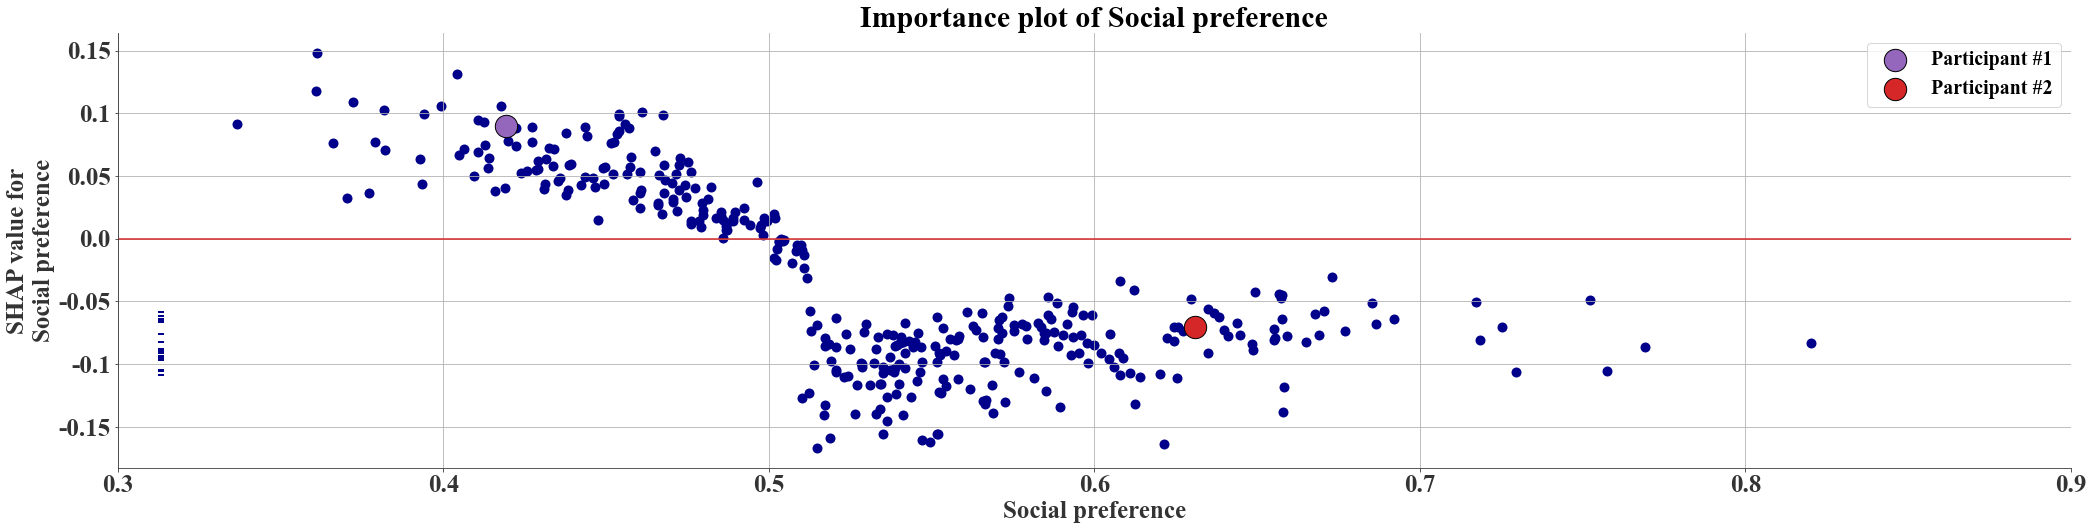

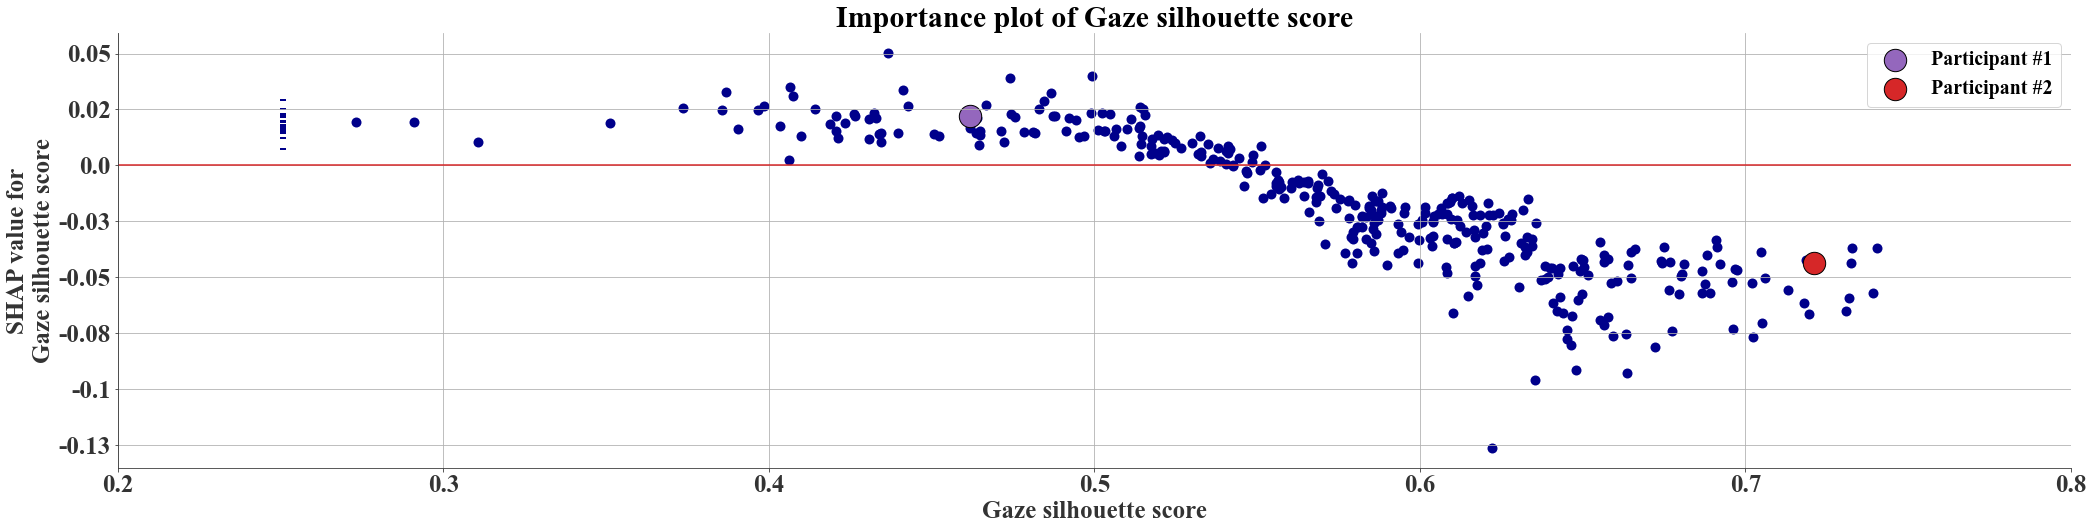

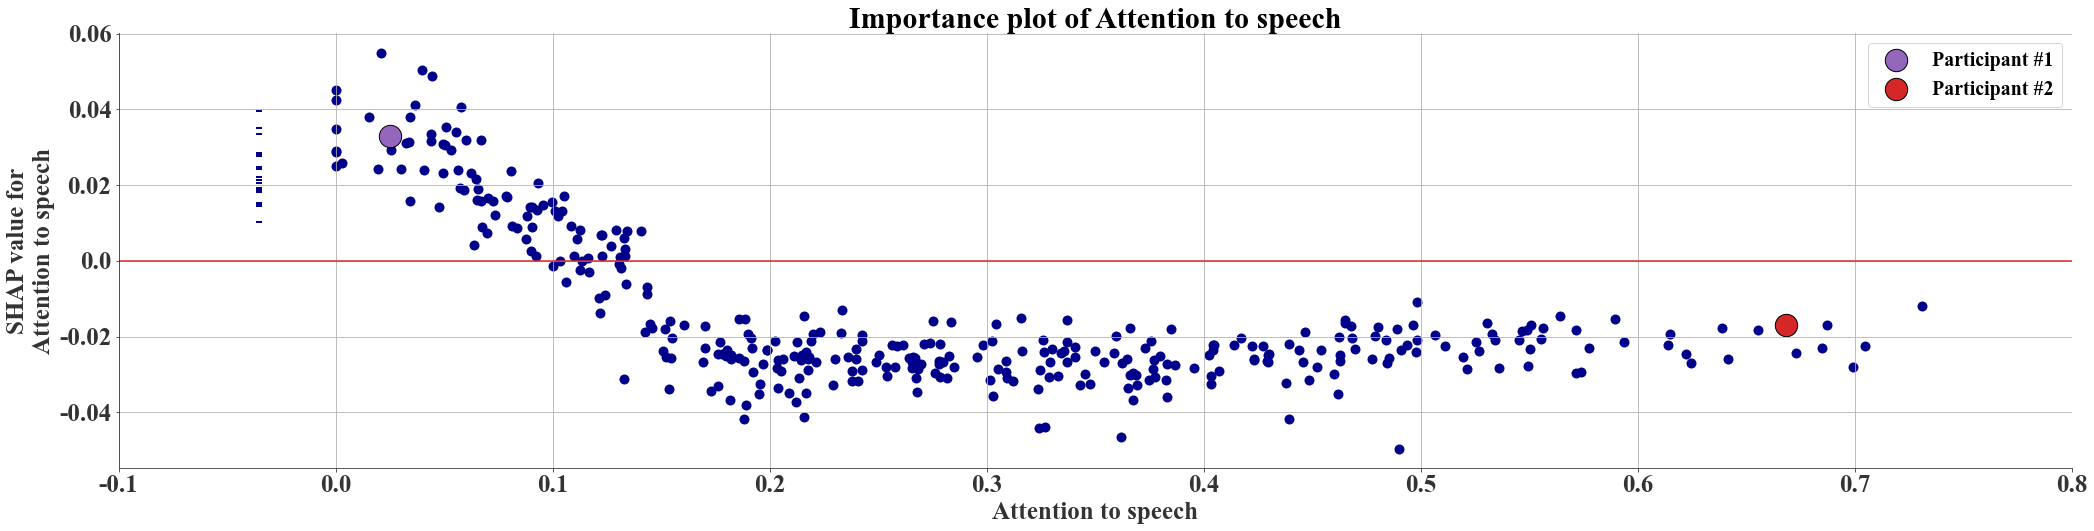

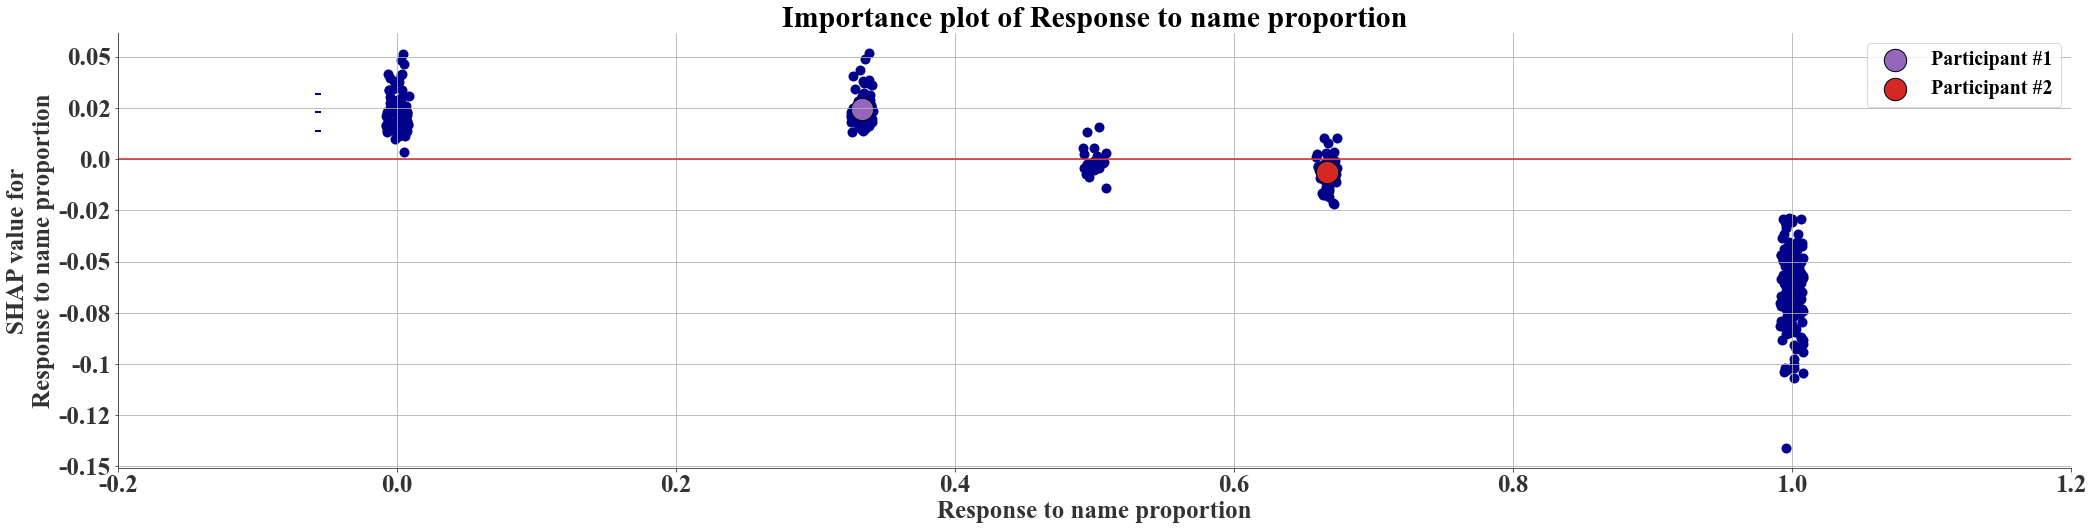

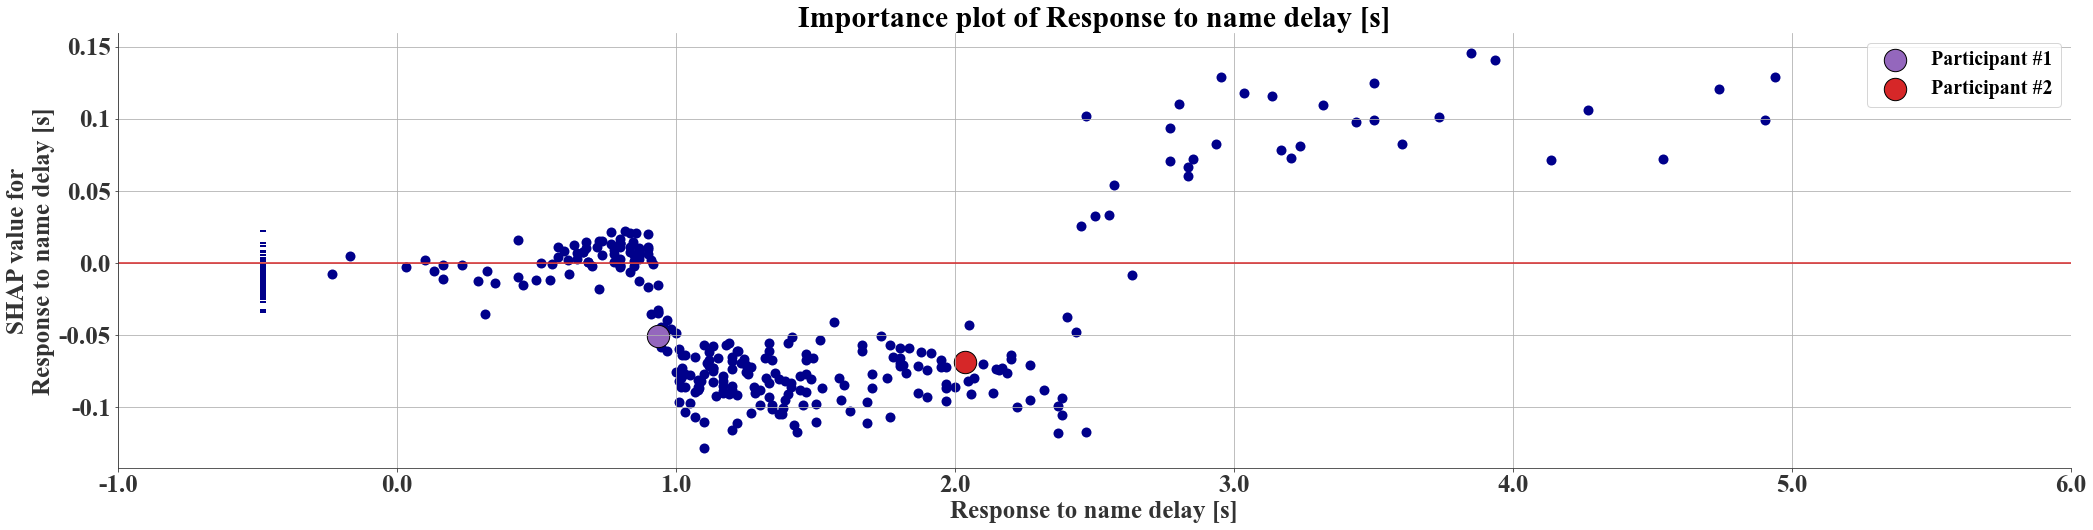

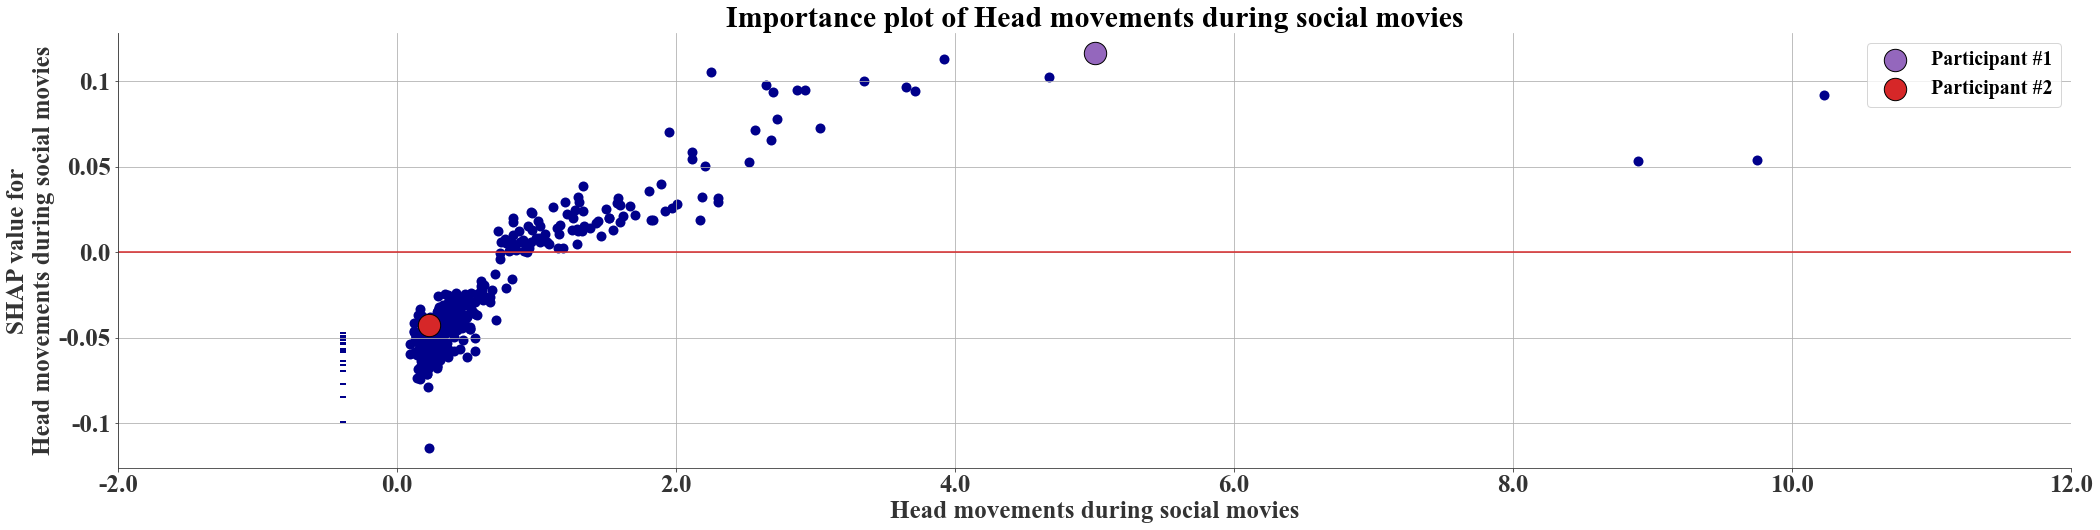

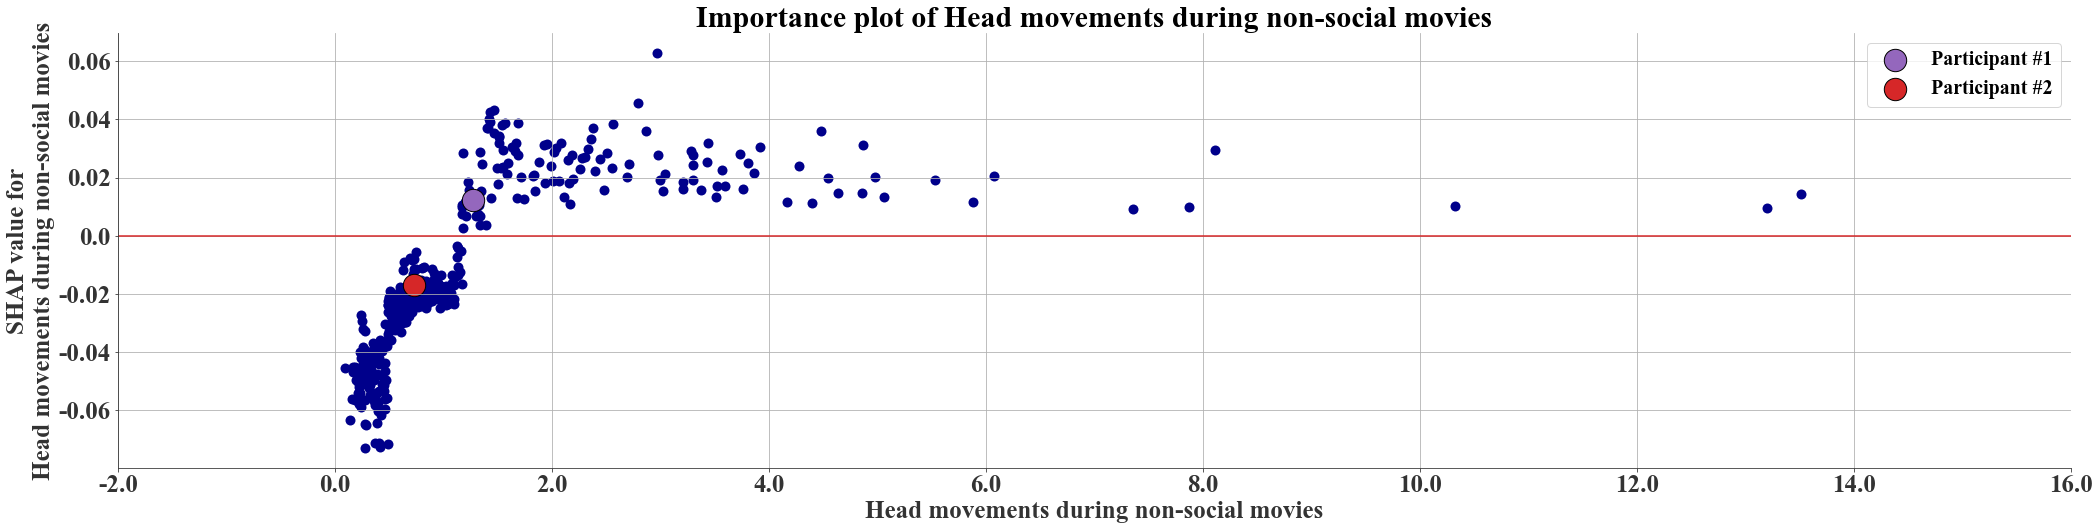

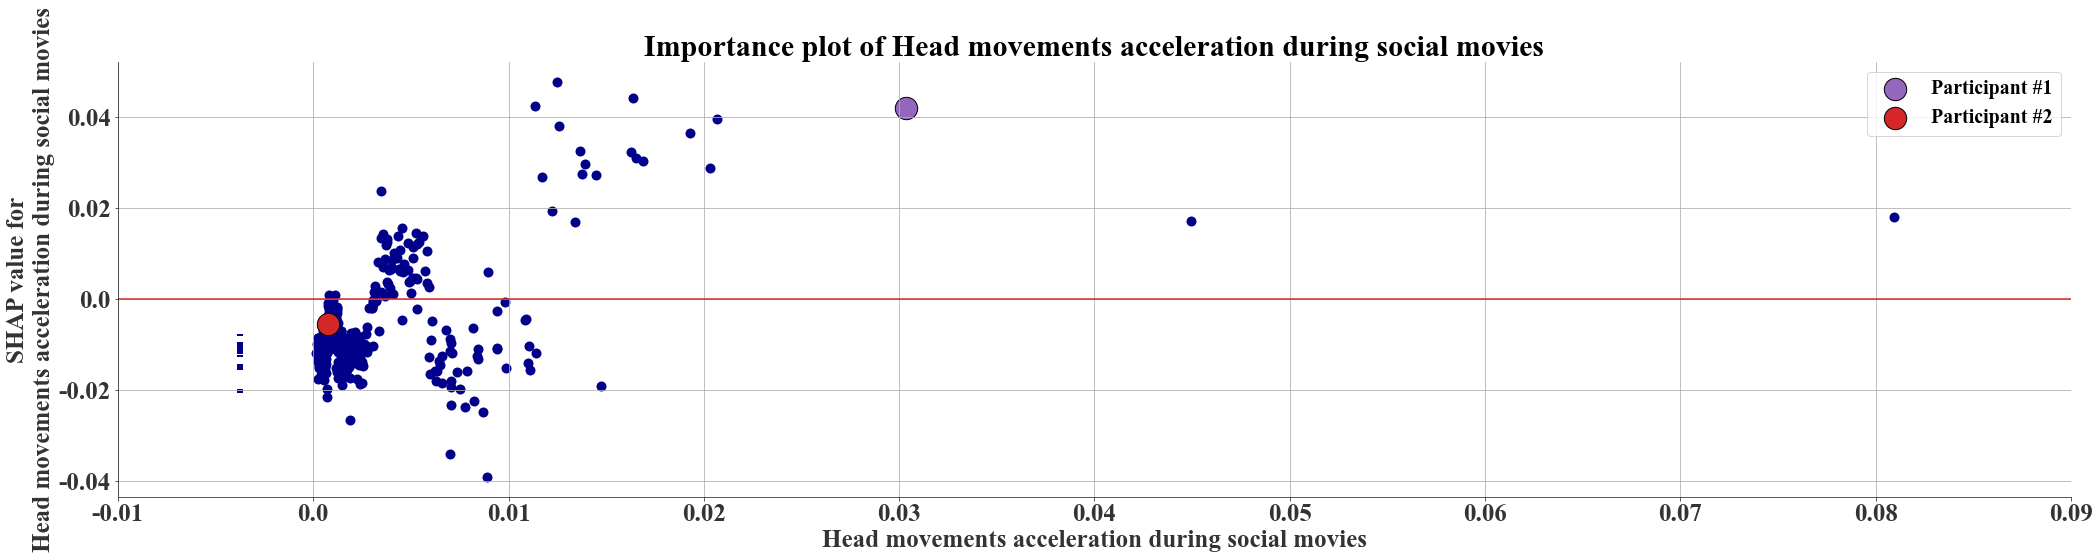

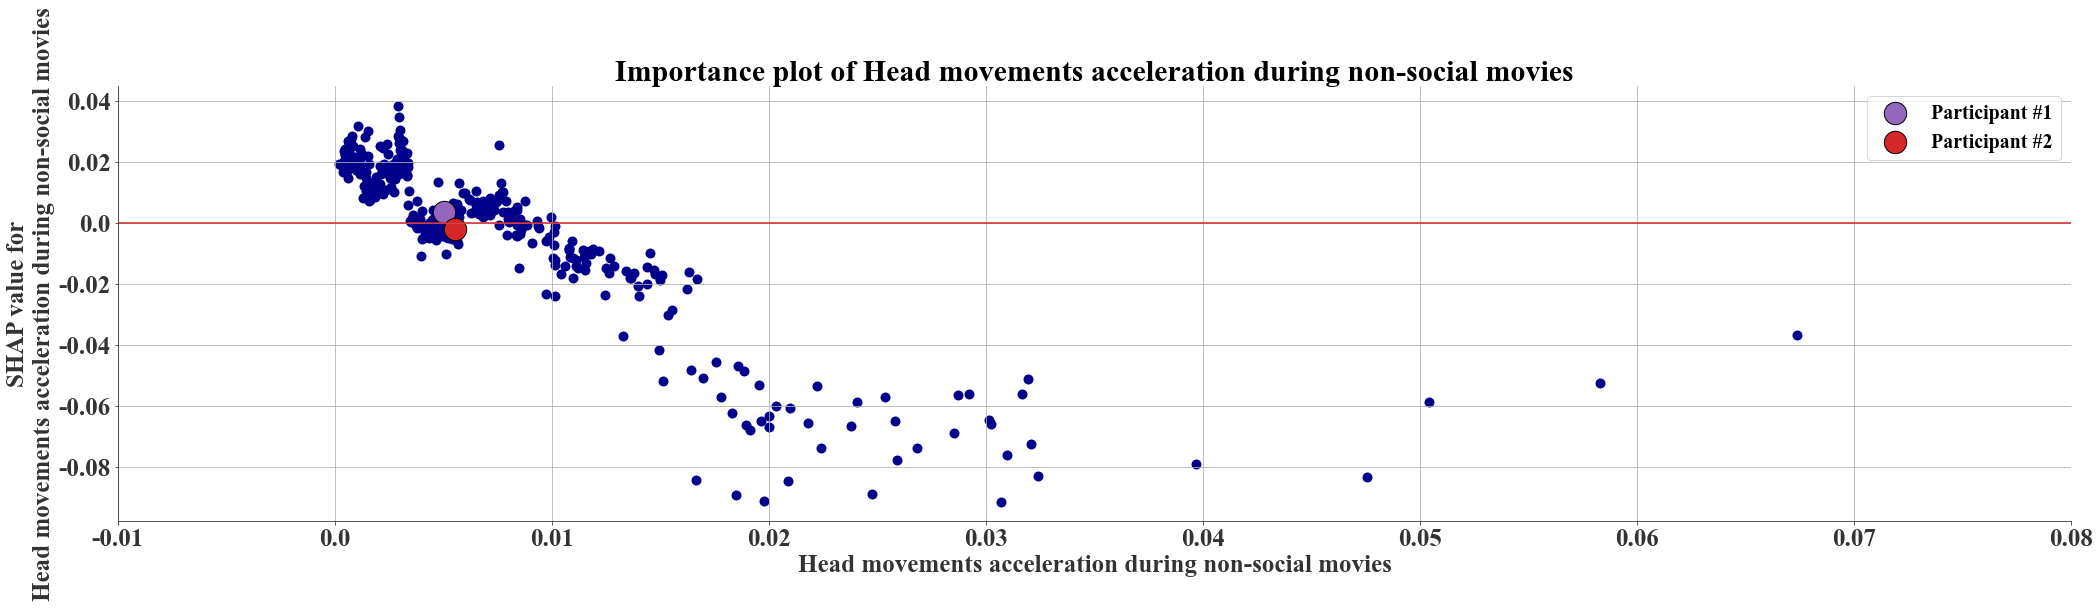

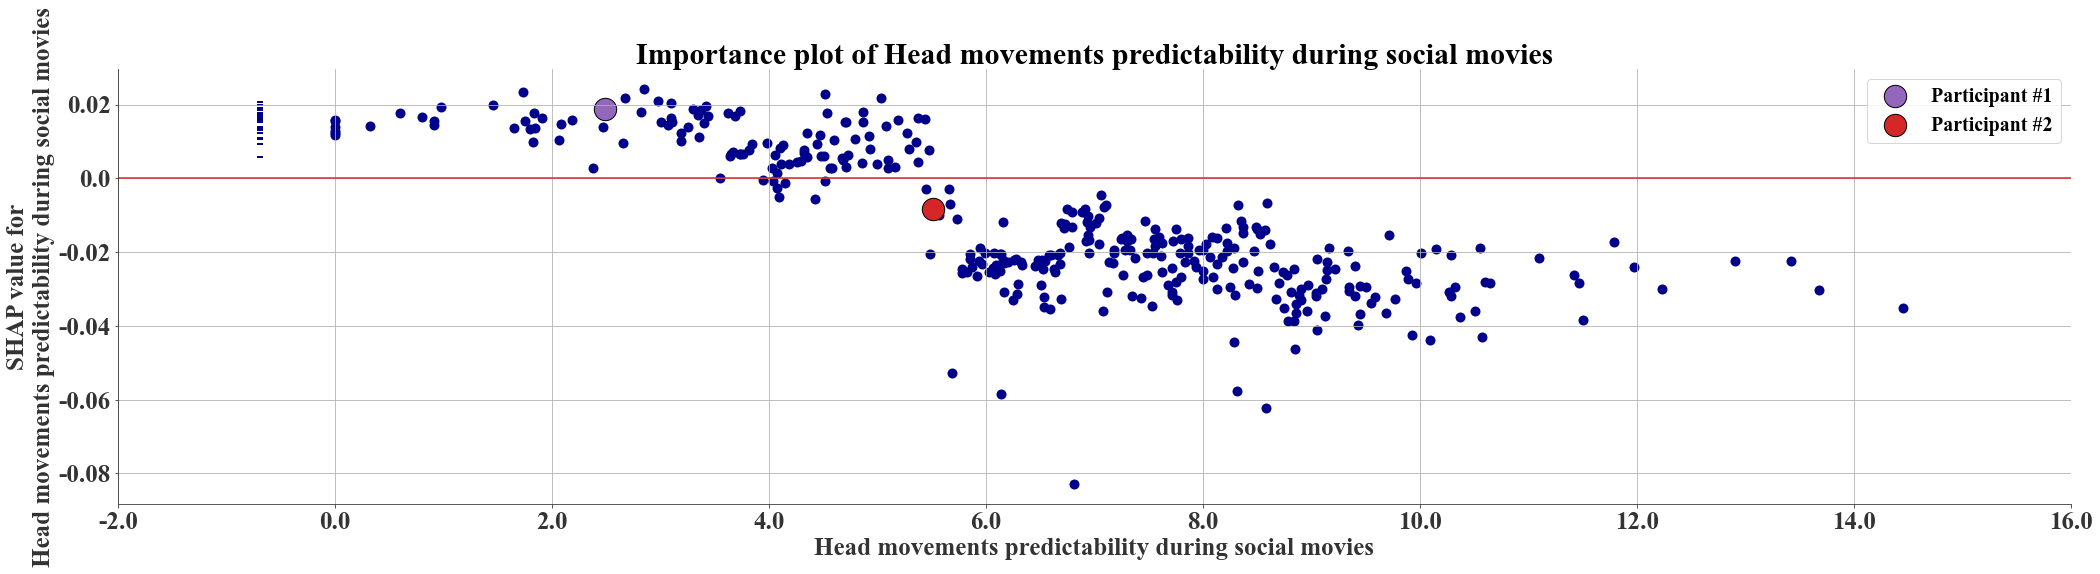

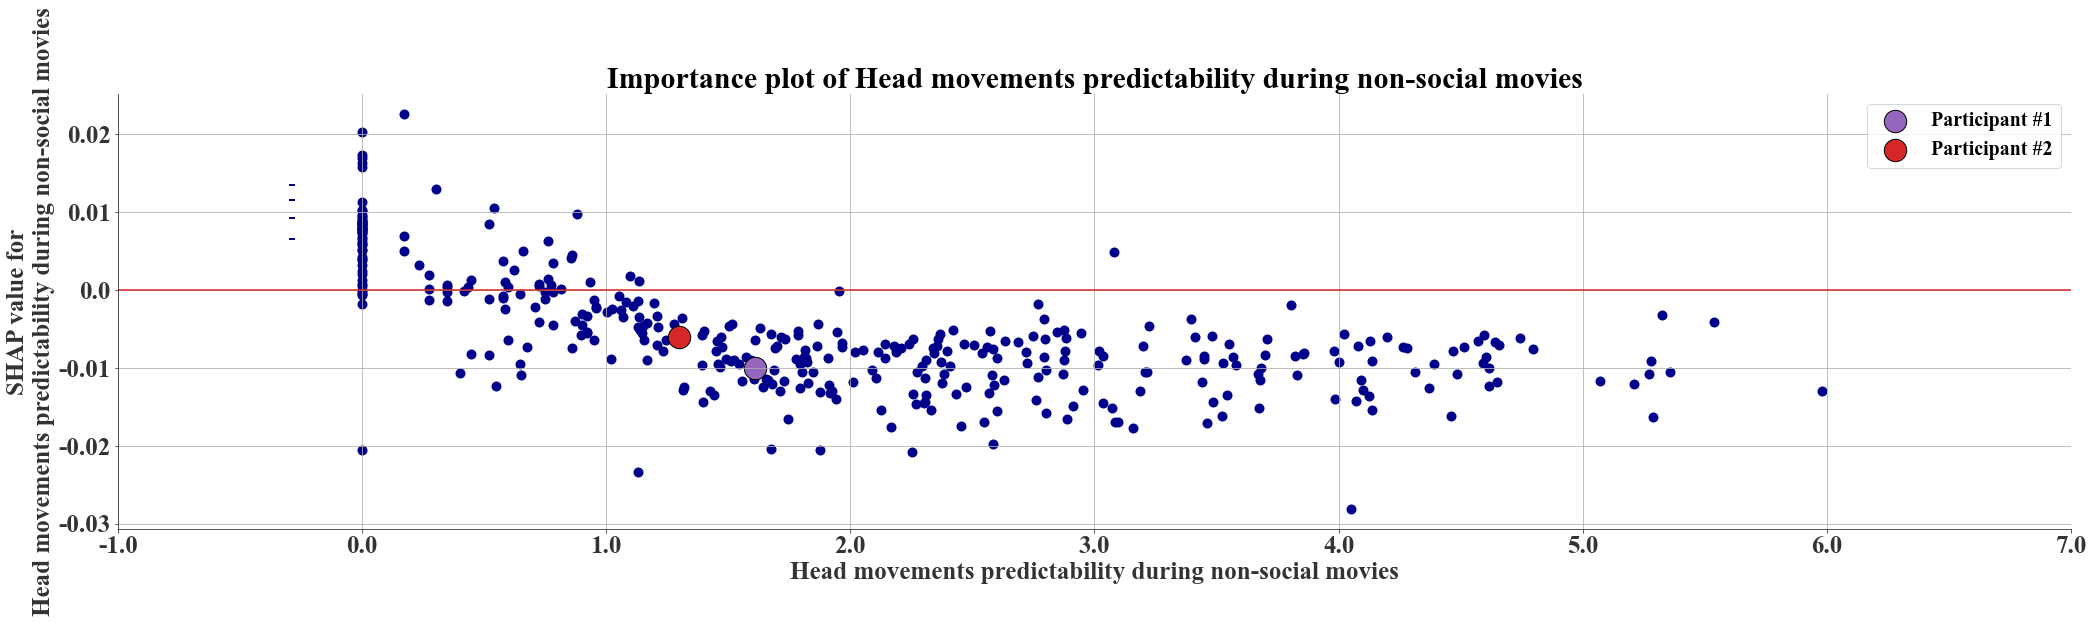

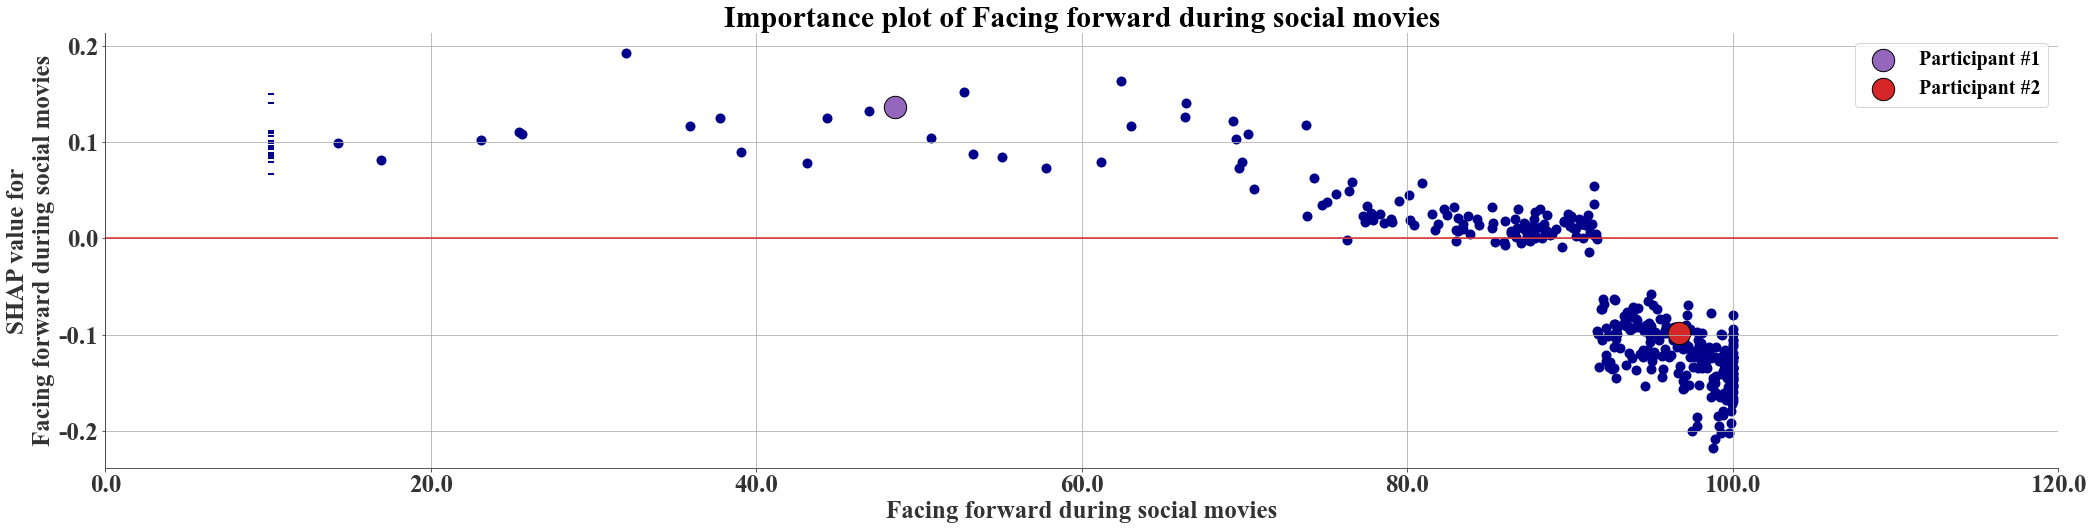

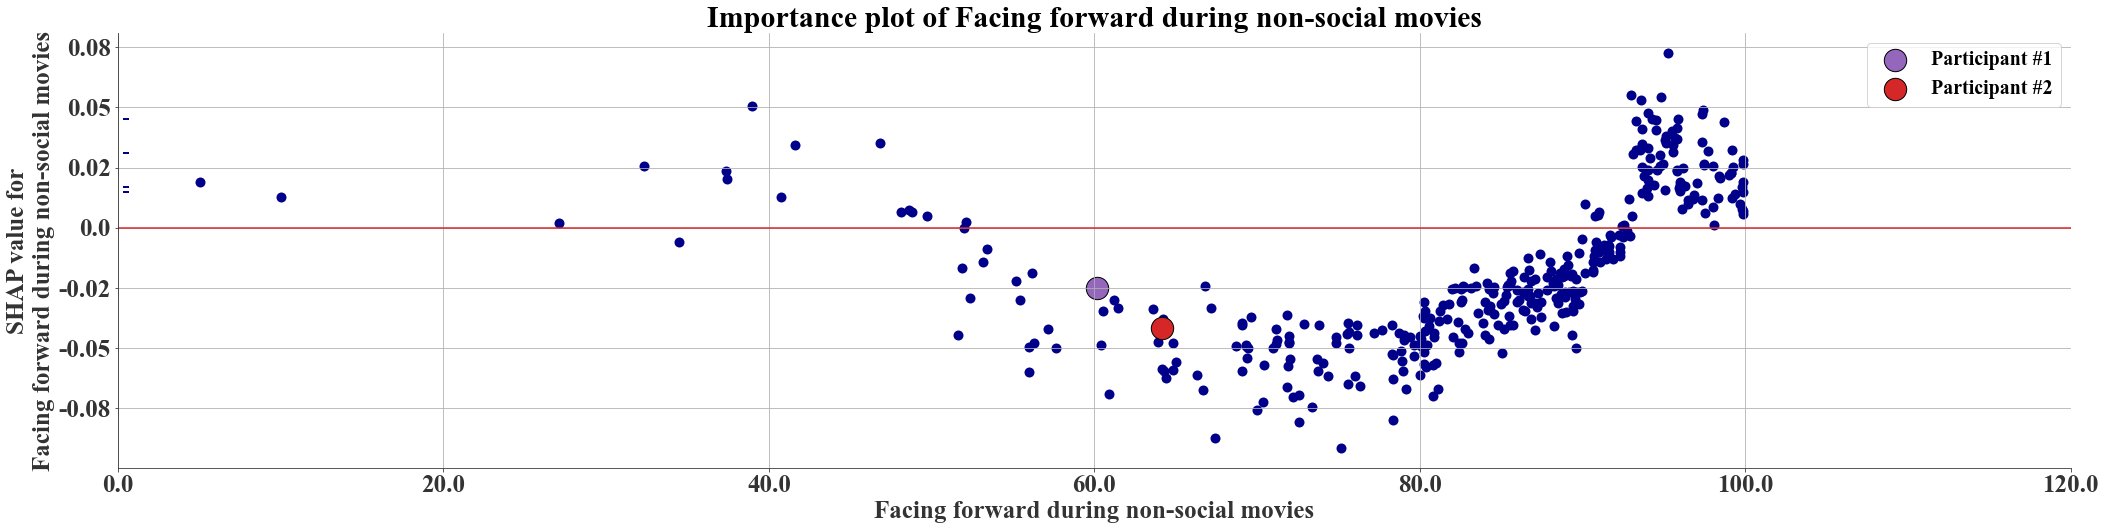

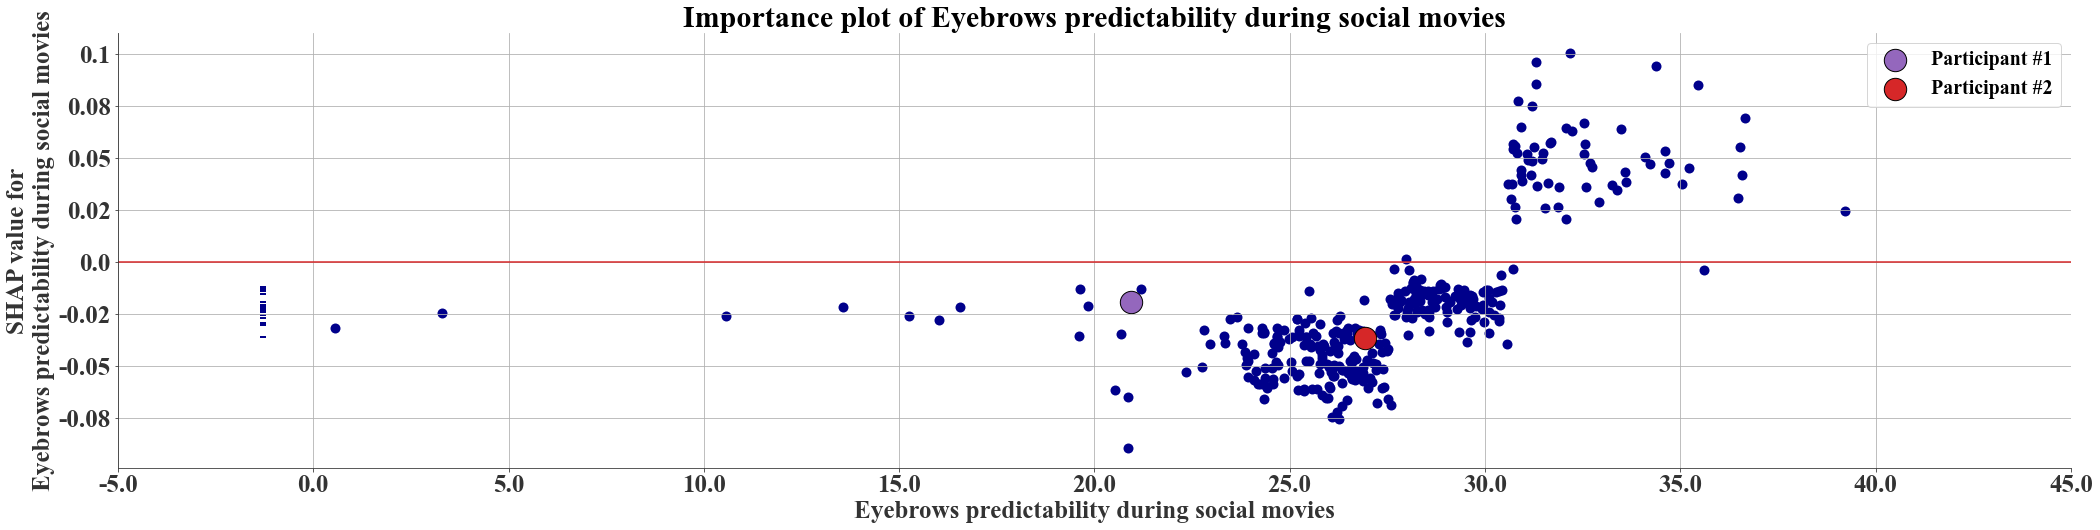

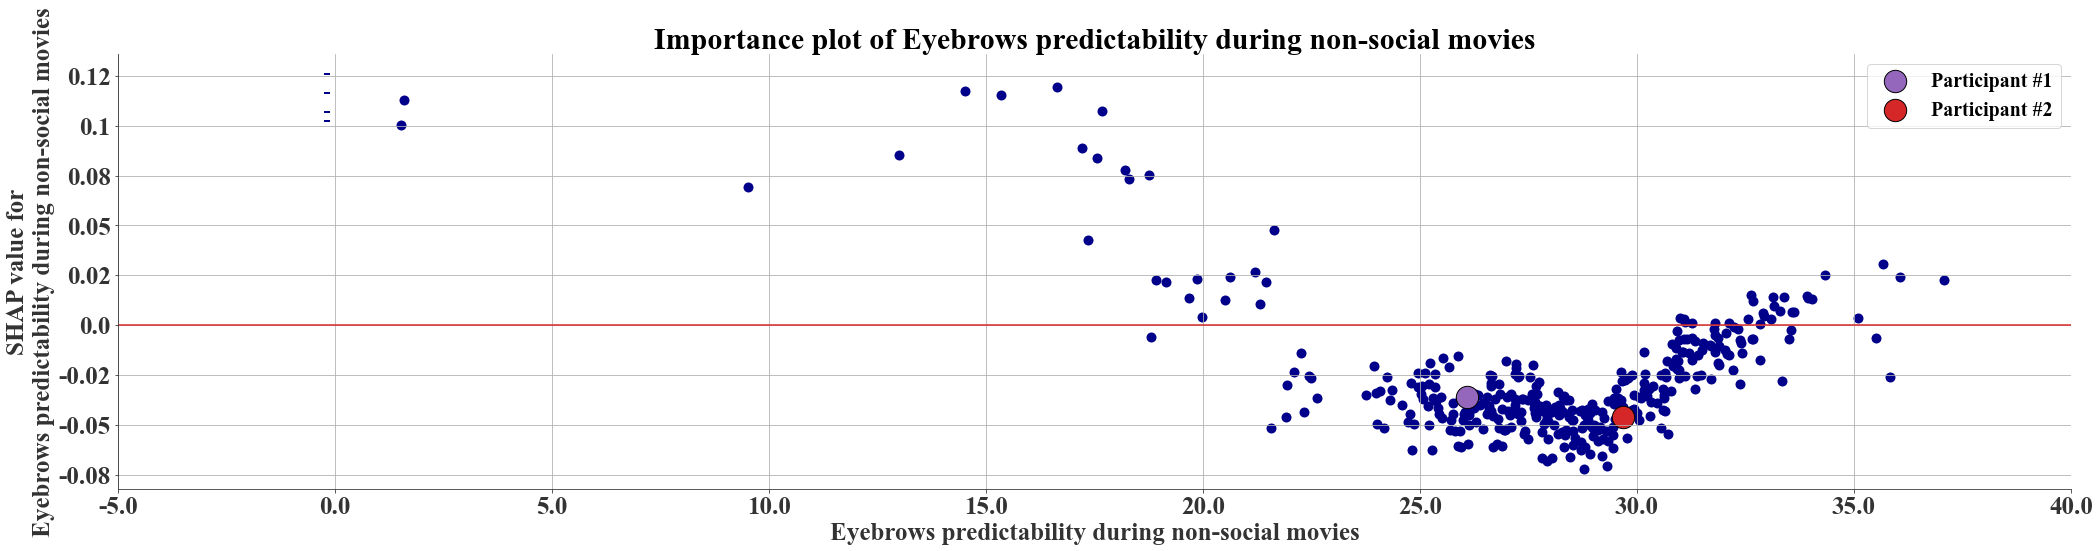

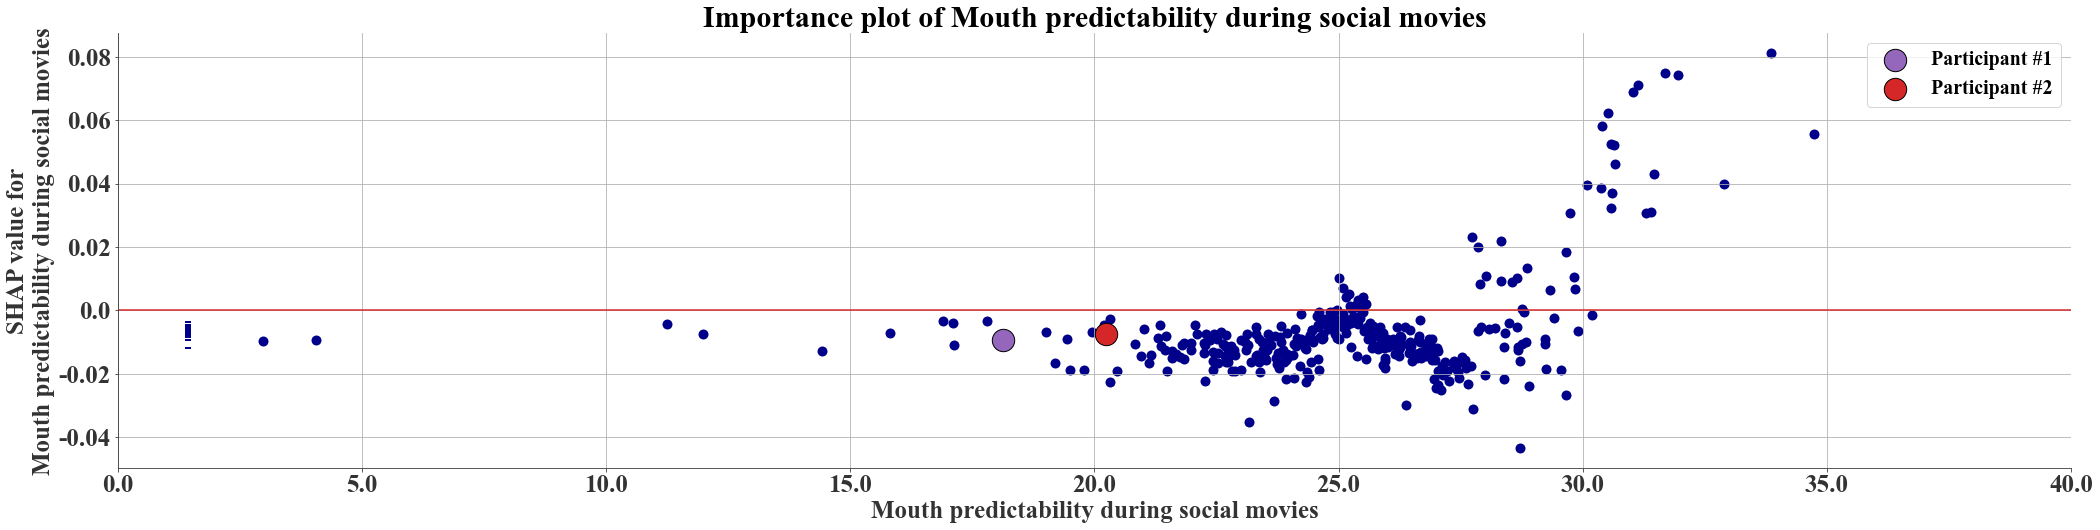

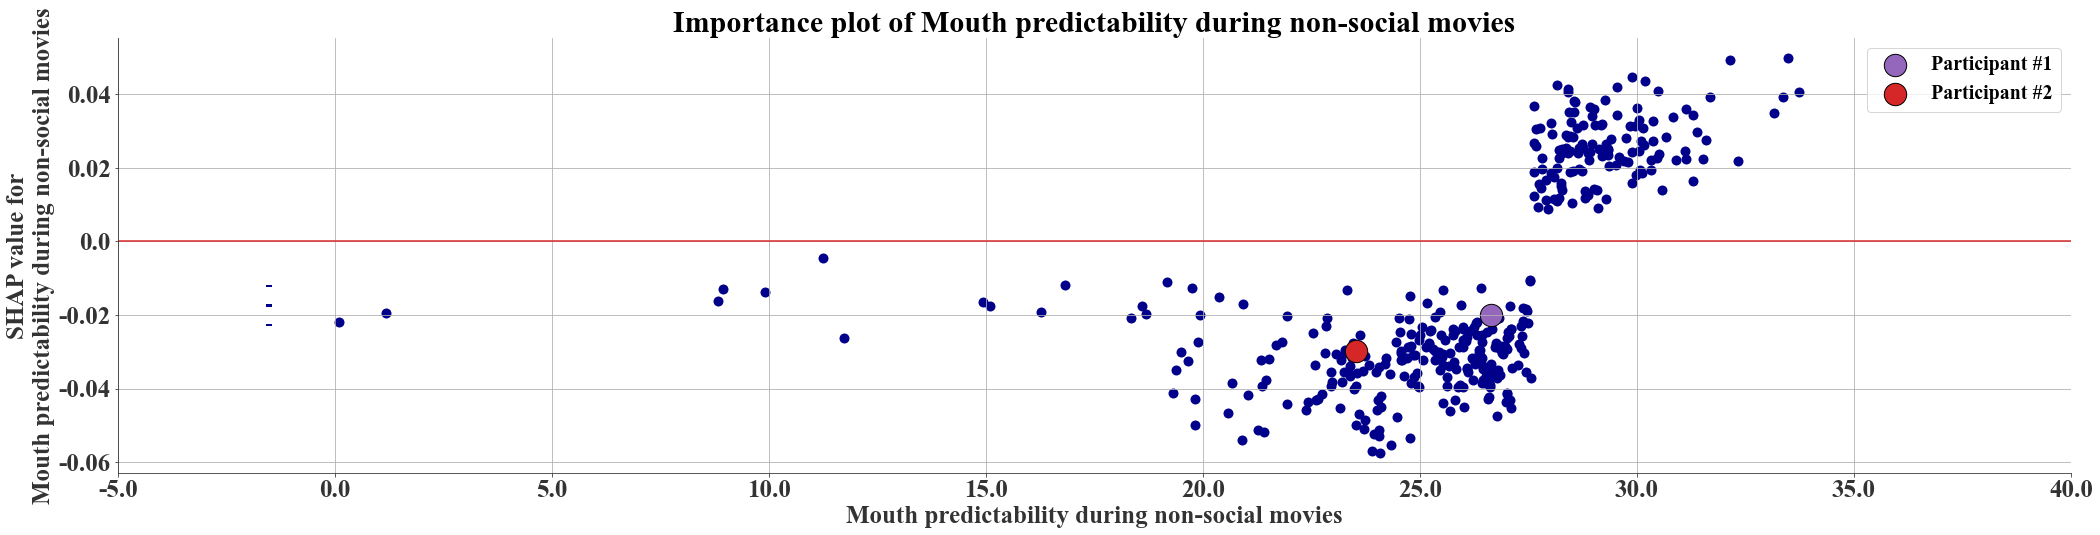

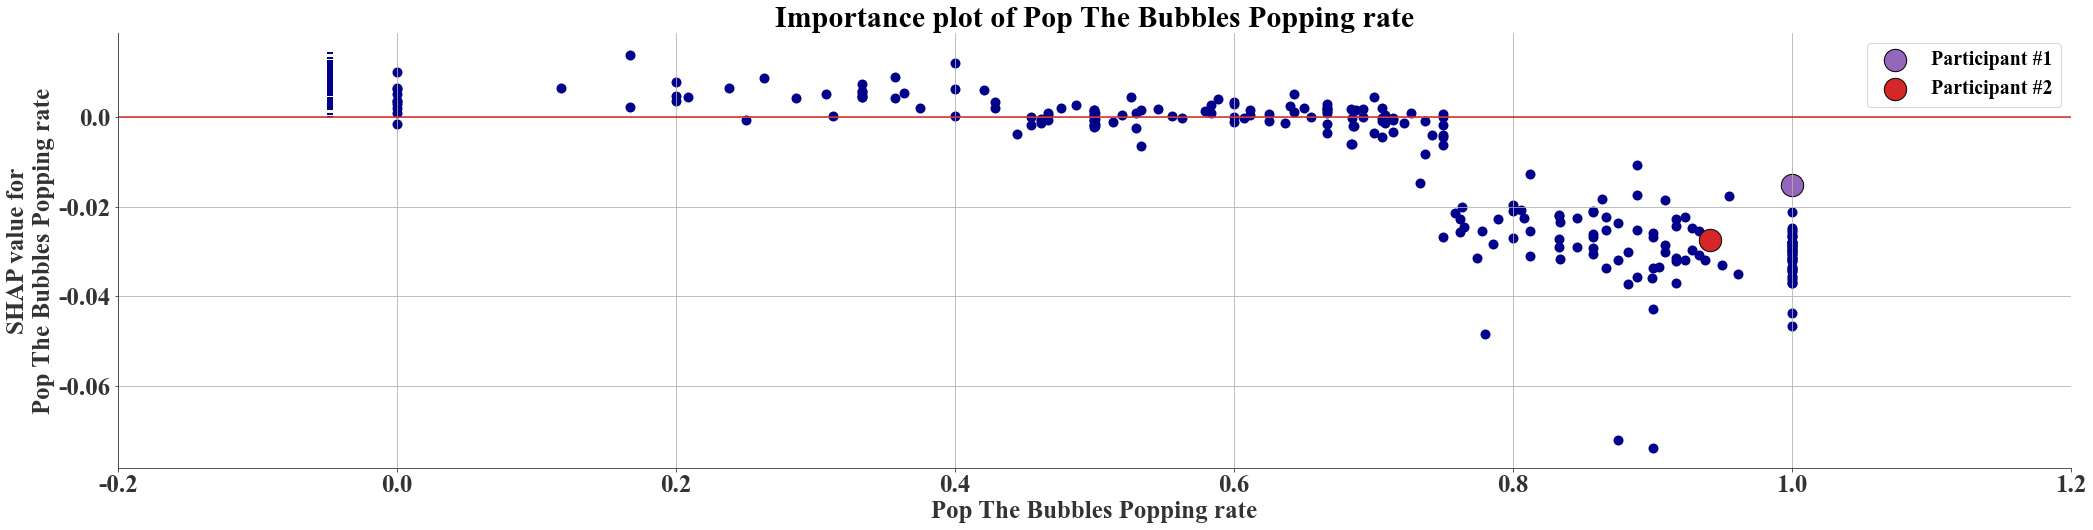

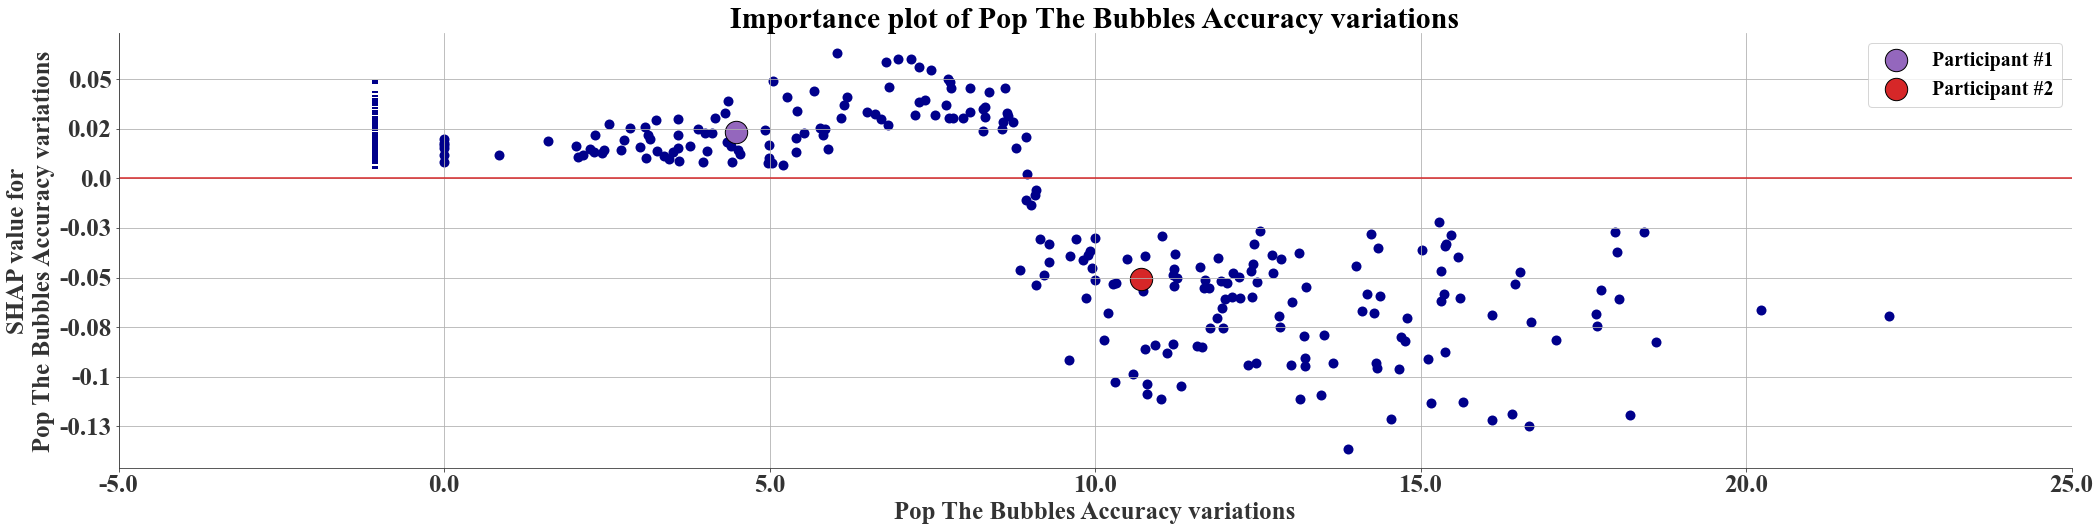

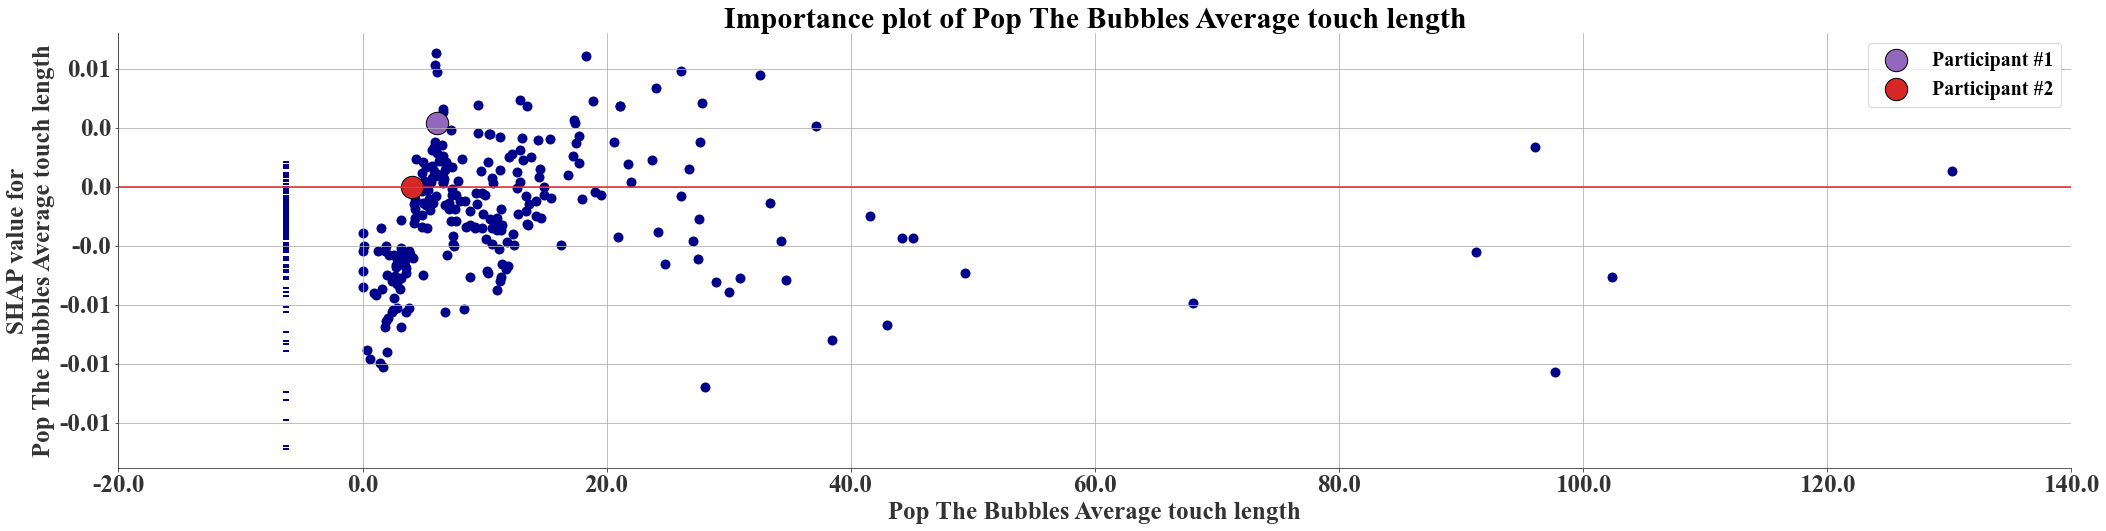

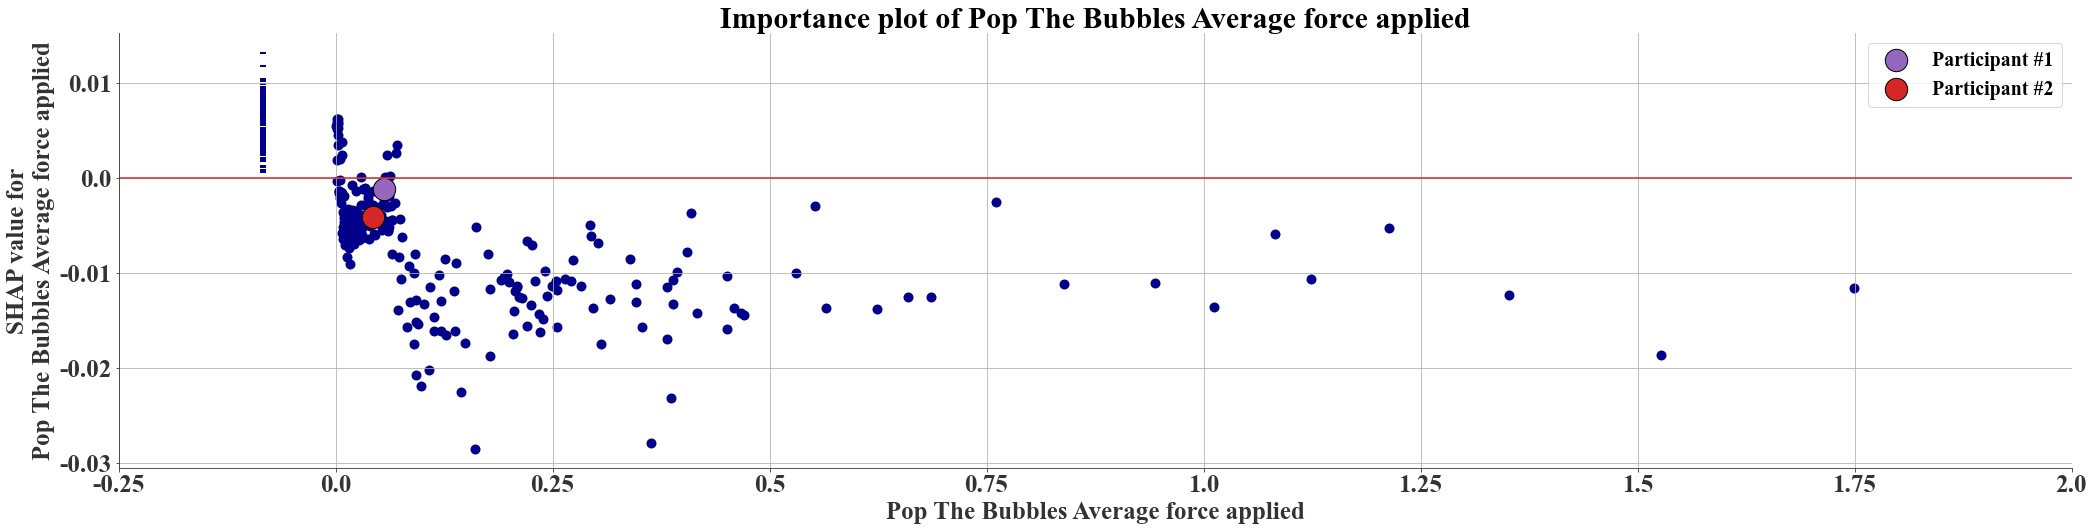

In [133]:
import matplotlib
csfont = {'fontname': 'Times New Roman'}
# Draw a random smaple and plot the shap matrix
averaged_shap_normalized = averaged_shap_interactions_normalized.sum(axis=1)

df_shap_interaction_importance = pd.DataFrame(np.abs(averaged_shap_interactions_normalized).mean(axis=0), columns=[feature_name_mapping[f] for f in exp.features_name], index=[feature_name_mapping[f] for f in exp.features_name])


X = pd.DataFrame(exp.dataset._X_train, columns=exp.features_name)
X.rename(columns=feature_name_mapping, inplace=True)
import shap
index_samples = [66, 165]
from matplotlib.pylab import pcolor, colorbar


for i, feat in enumerate(exp.features_name):
    
    feature_name = feature_name_mapping[feat]
    
    most_interacting_feature  = df_shap_interaction_importance.loc[feature_name].nlargest(2).index[1]
    
    fig, ax = plt.subplots(1, 1, figsize=(35, 8))
    ax.axhline(0, color='tab:red')
    ax.set_title("Importance plot of {}".format(feature_name), weight='bold', fontsize=18)
    
    fig = shap.dependence_plot(feature_name, averaged_shap_normalized, X, [feature_name_mapping[f] for f in exp.features_name], x_jitter=0.1, dot_size=100, interaction_index=None, color='darkblue', ax=ax, show=False)
    
    
    plt.gca().set_title(plt.gca().get_title(), weight='bold', fontsize=30, **csfont)
    plt.gca().set_xlabel(plt.gca().get_xlabel(), weight='bold', fontsize=25, **csfont)
    plt.gca().set_ylabel(plt.gca().get_ylabel(), weight='bold', fontsize=25, **csfont)
    plt.gca().grid()
    plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=25, **csfont)
    plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=25, **csfont)
    
    plt.gca().scatter([X.to_numpy()[index_samples[0], i]], [averaged_shap_normalized[index_samples[0], i]], s=500, color='#9467bd', edgecolors='k',  label='Participant #1')
    plt.gca().scatter([X.to_numpy()[index_samples[1], i]], [averaged_shap_normalized[index_samples[1], i]], s=500, color='#d62728', edgecolors='k', label='Participant #2')
    plt.gca().legend(prop={'size':20, 'family':'times new roman', 'weight':'bold'})
    plt.savefig(os.path.join(ROOT_DIR, 'figures', 'dependence_{}.png'.format(feature_name)), dpi=200, bbox_inches = 'tight')
    plt.show()


0.77


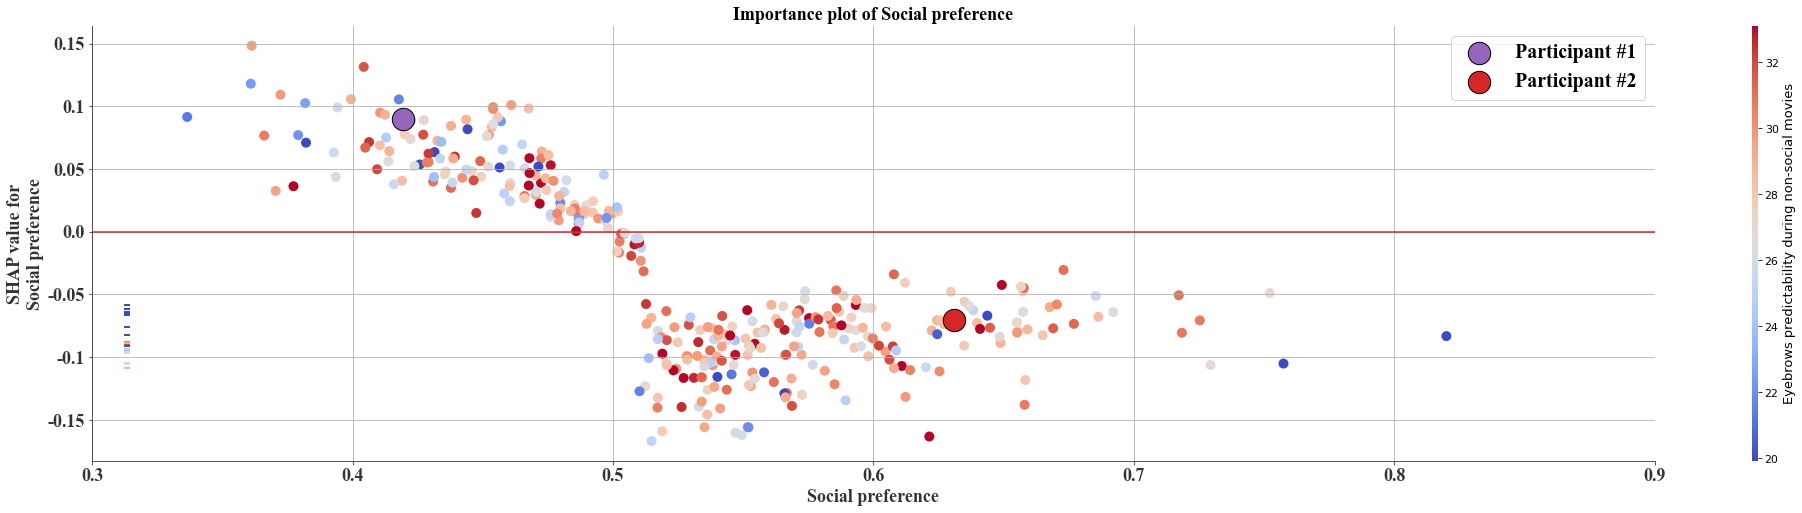

0.38


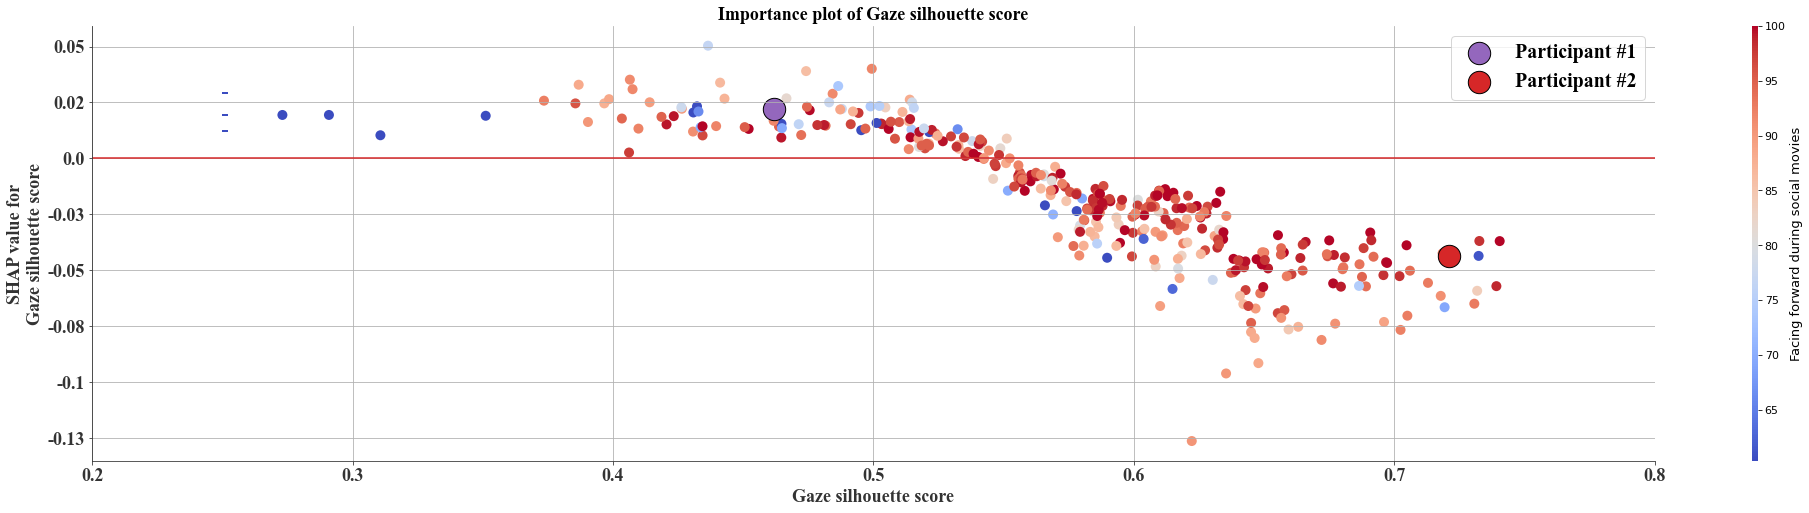

0.23


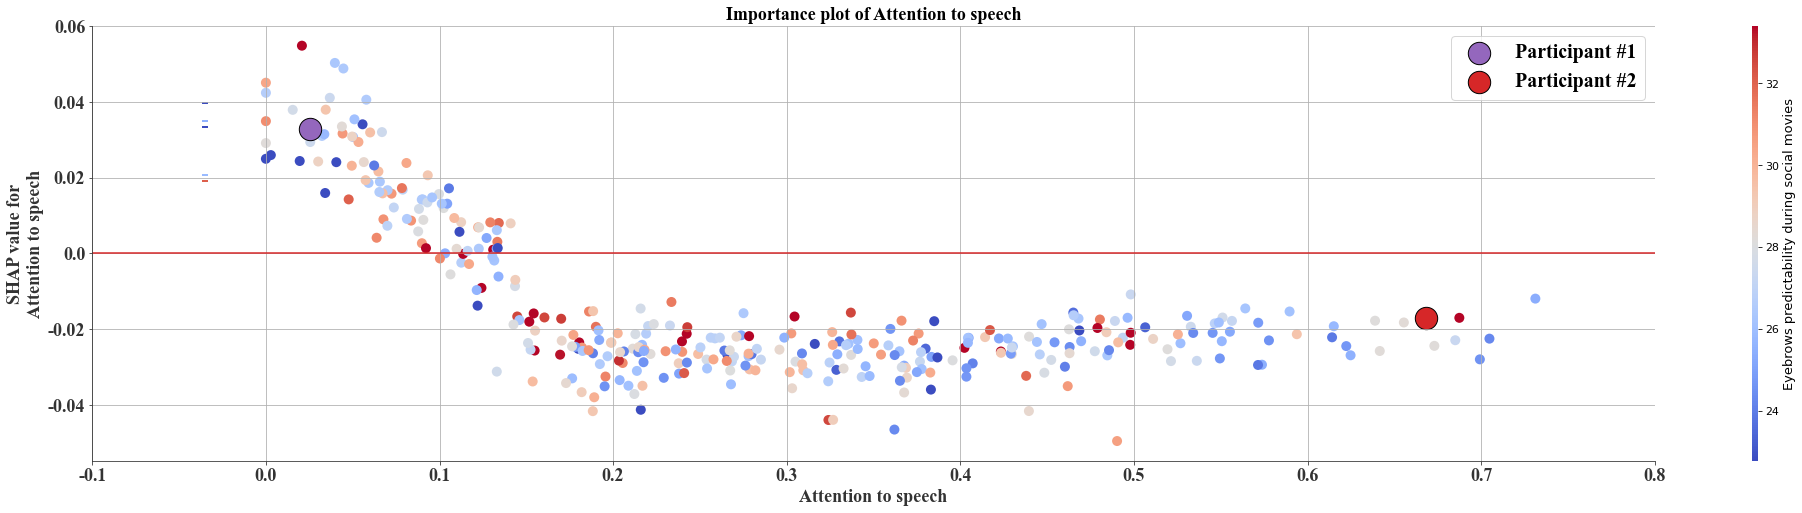

0.35


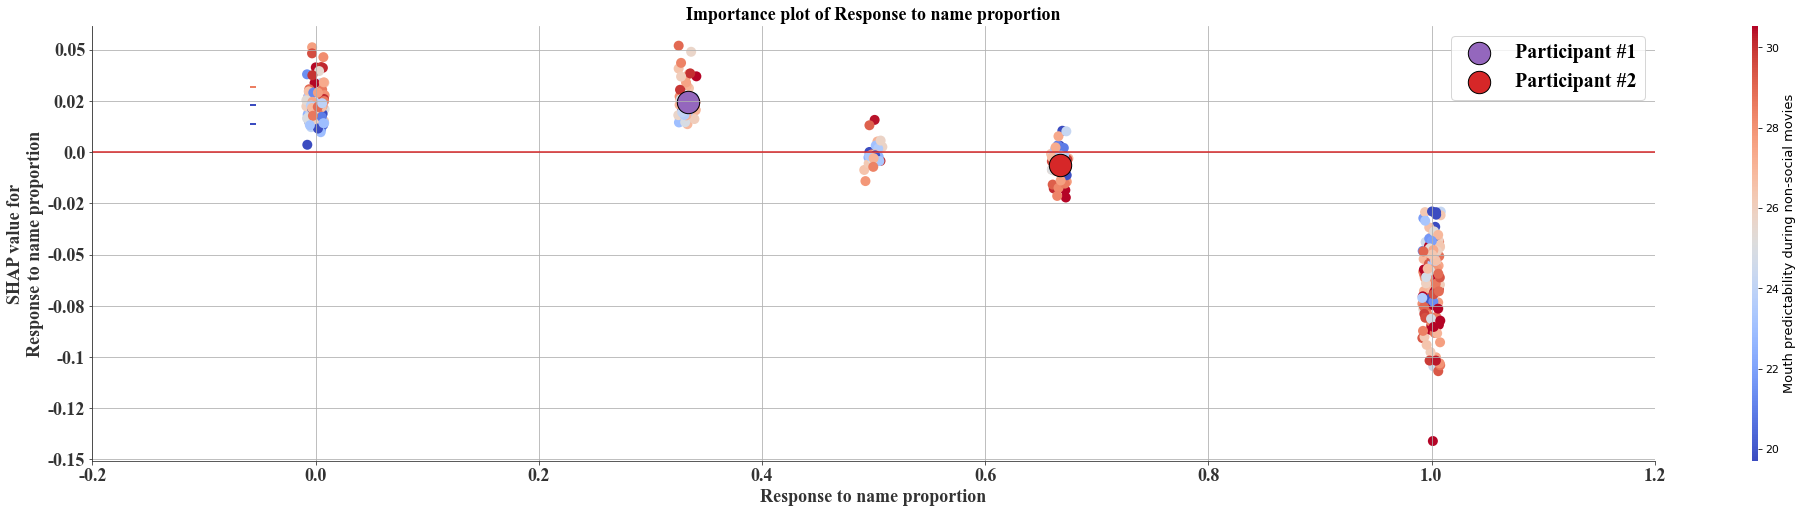

0.43


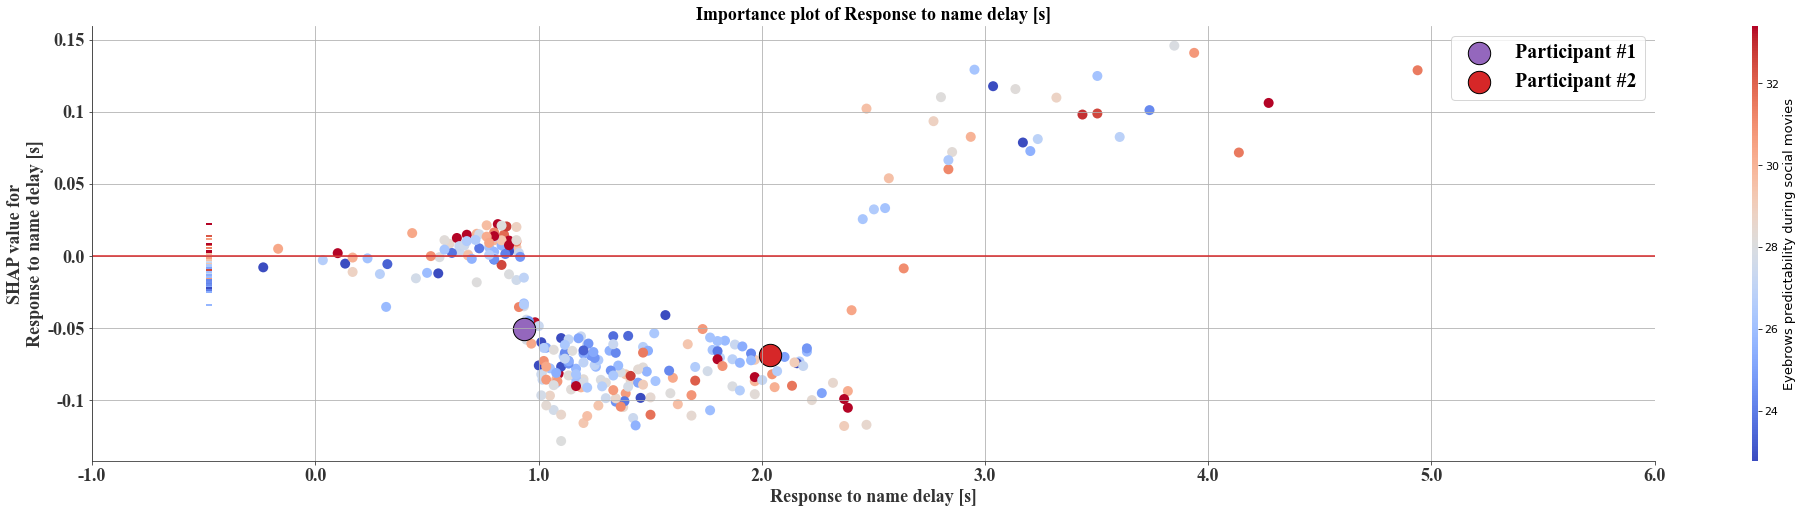

0.27


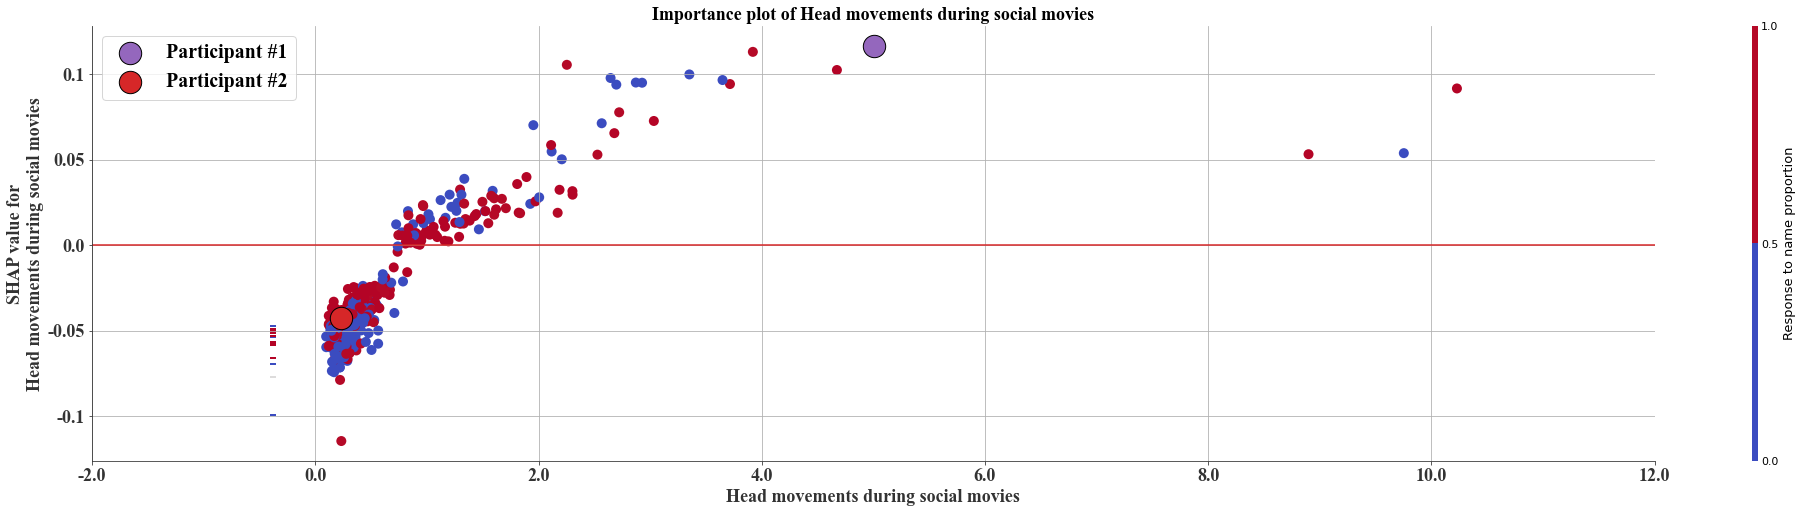

0.39


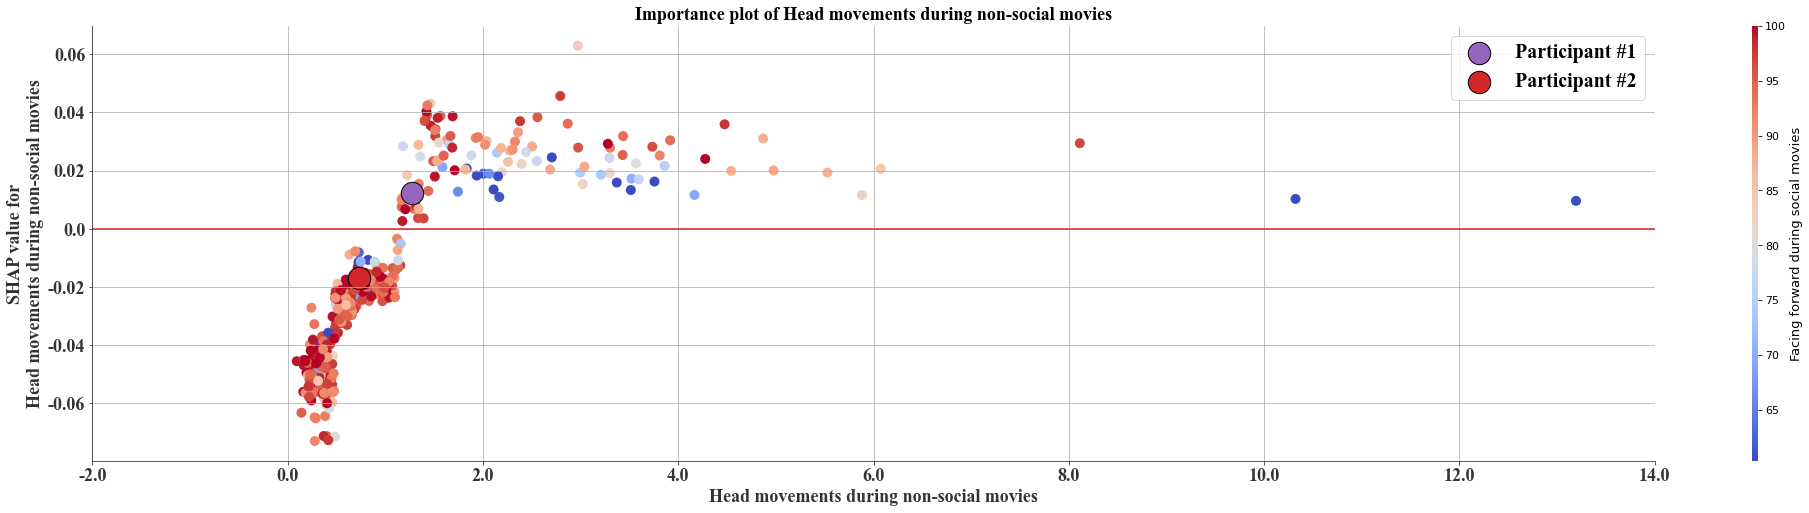

0.1


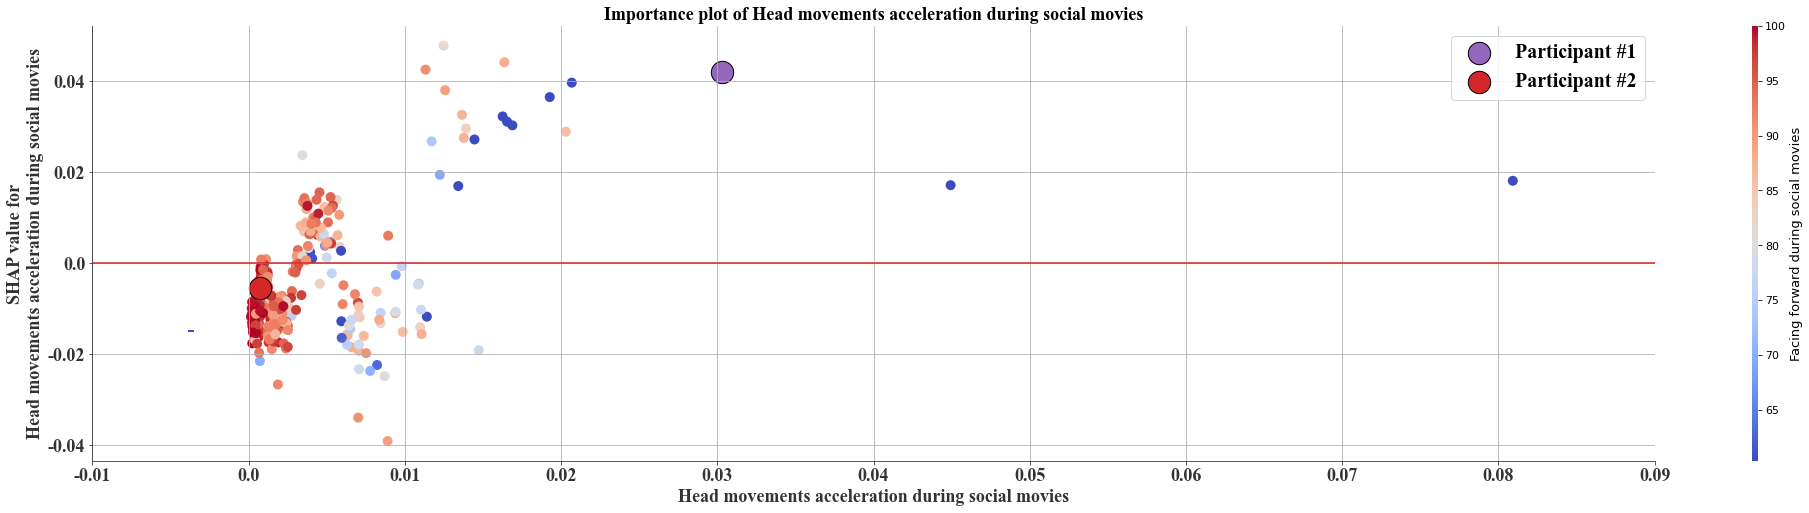

0.23


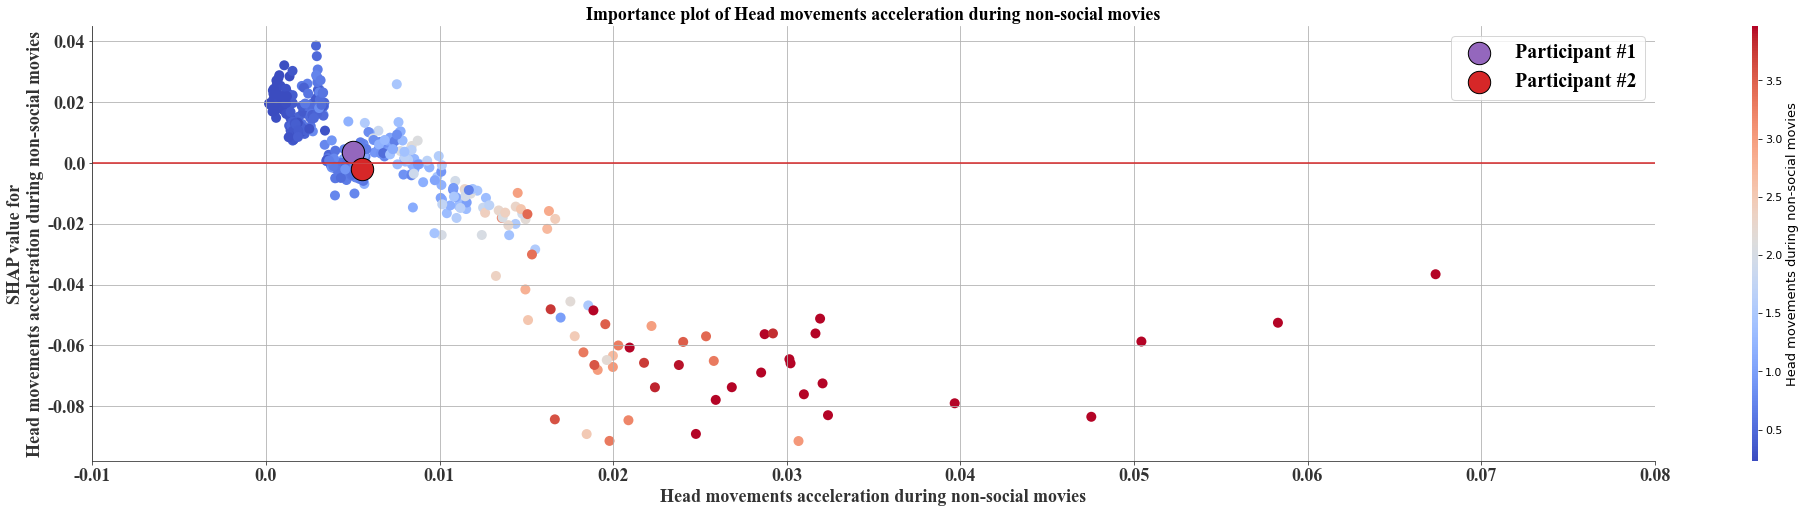

0.26


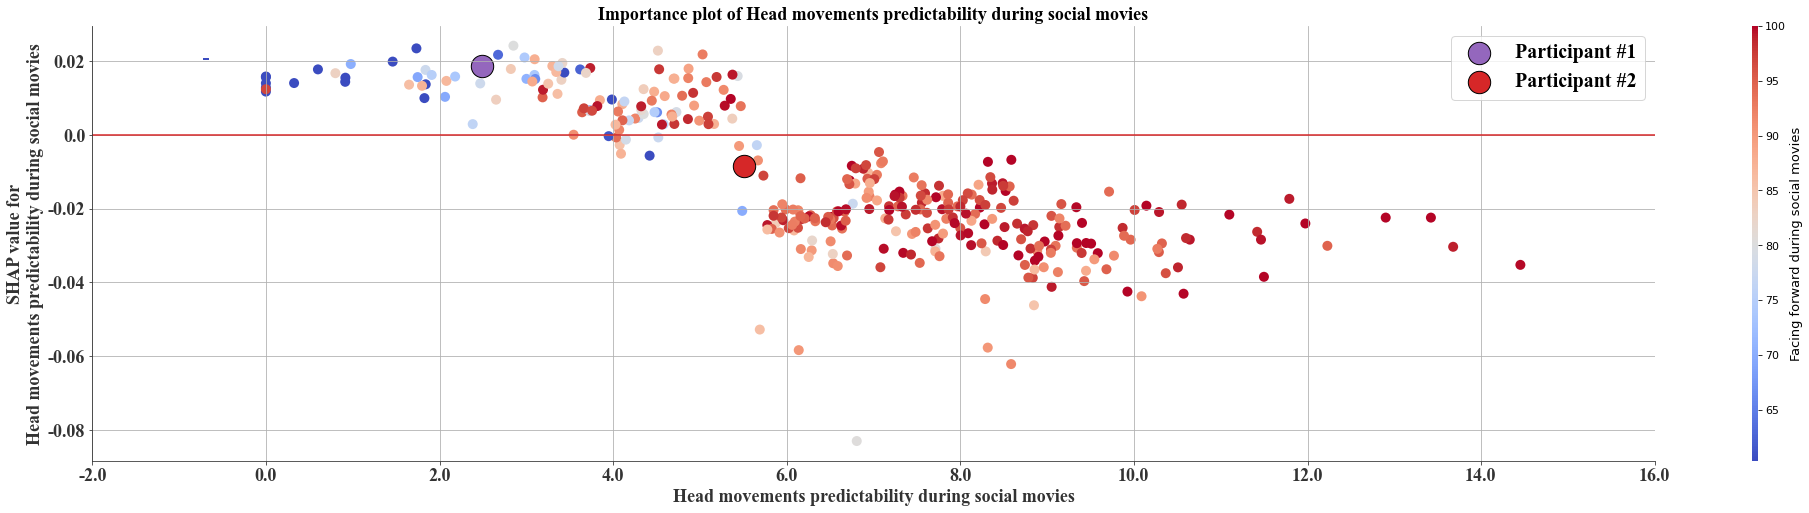

0.21


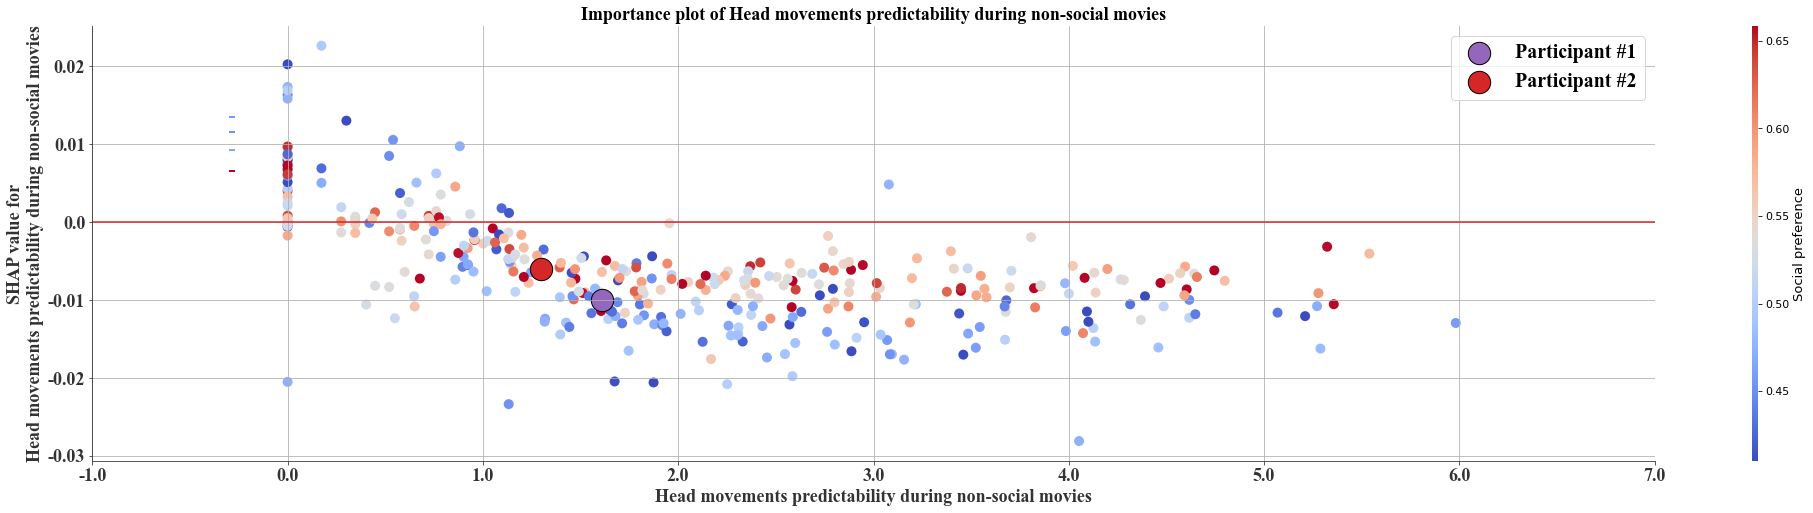

0.66


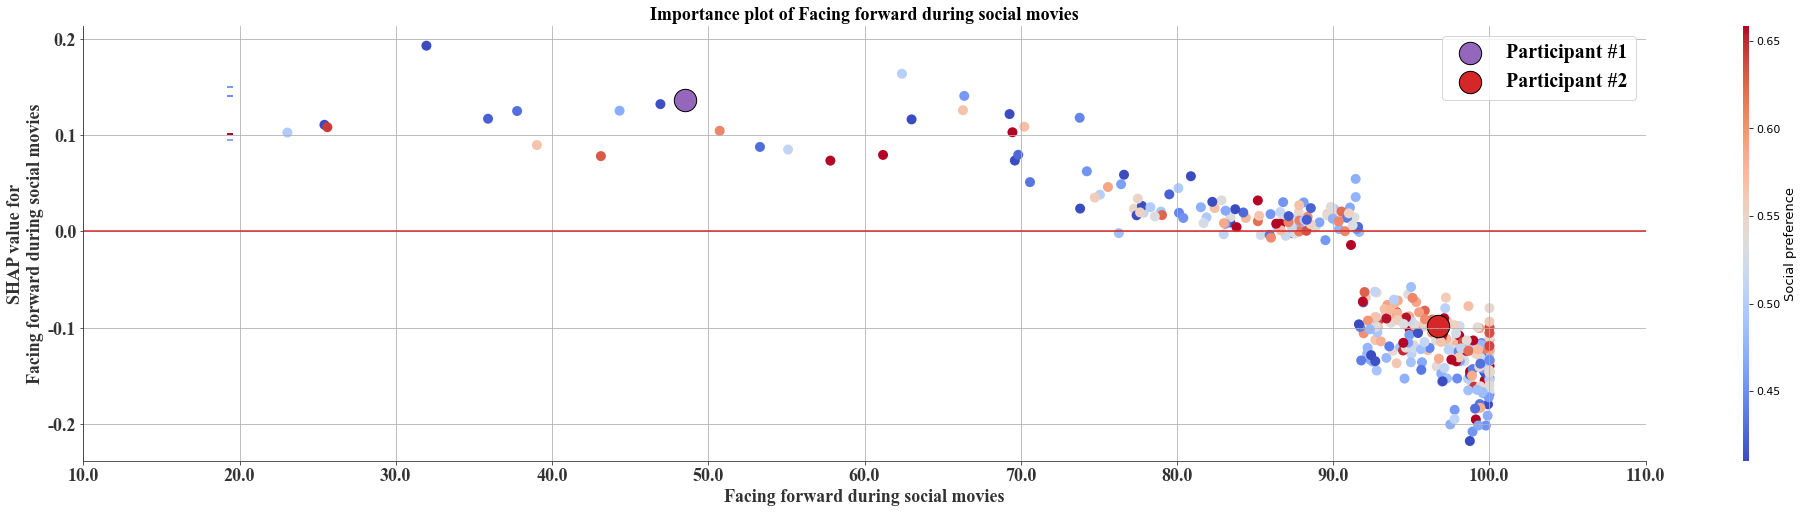

0.51


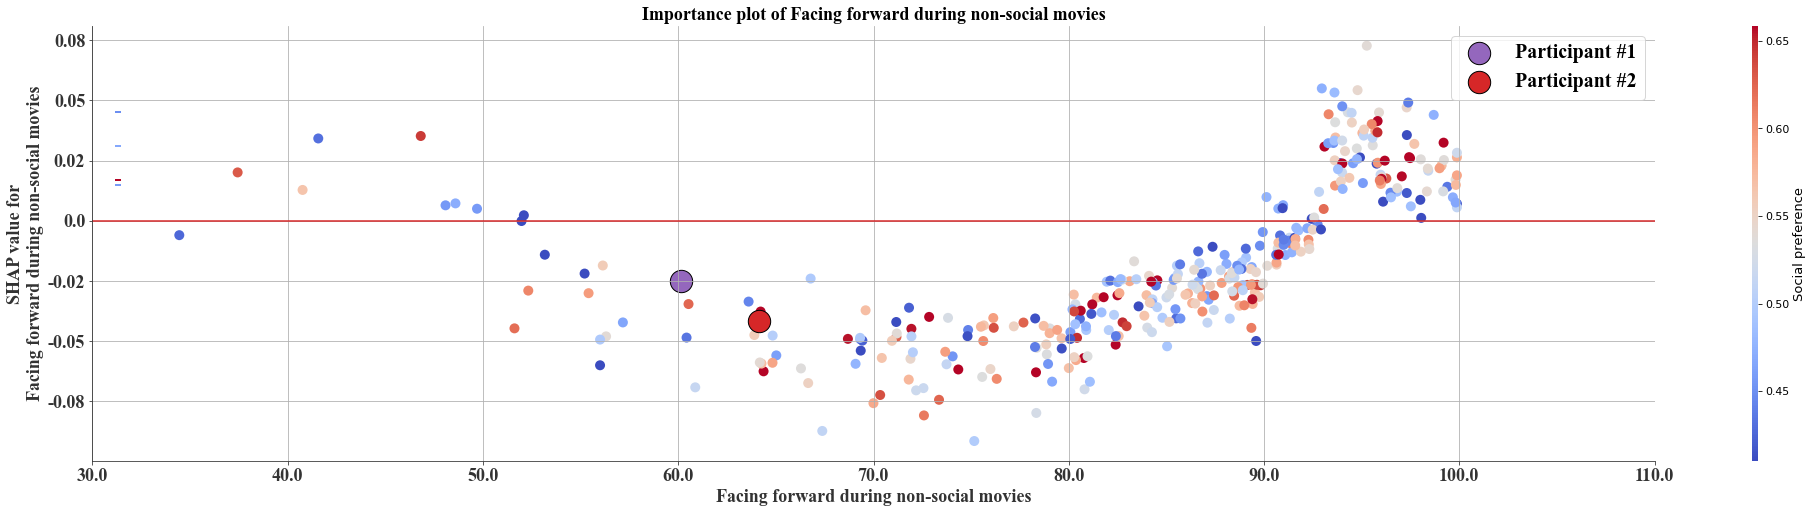

0.43


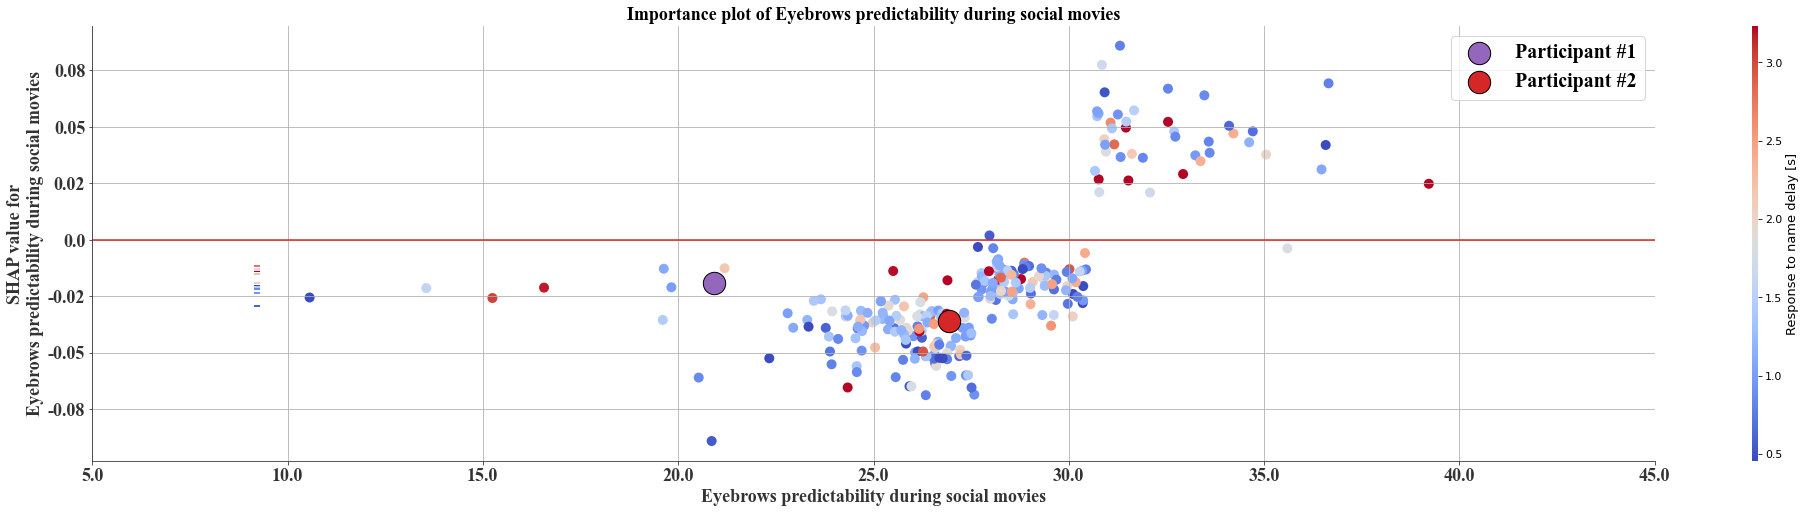

0.77


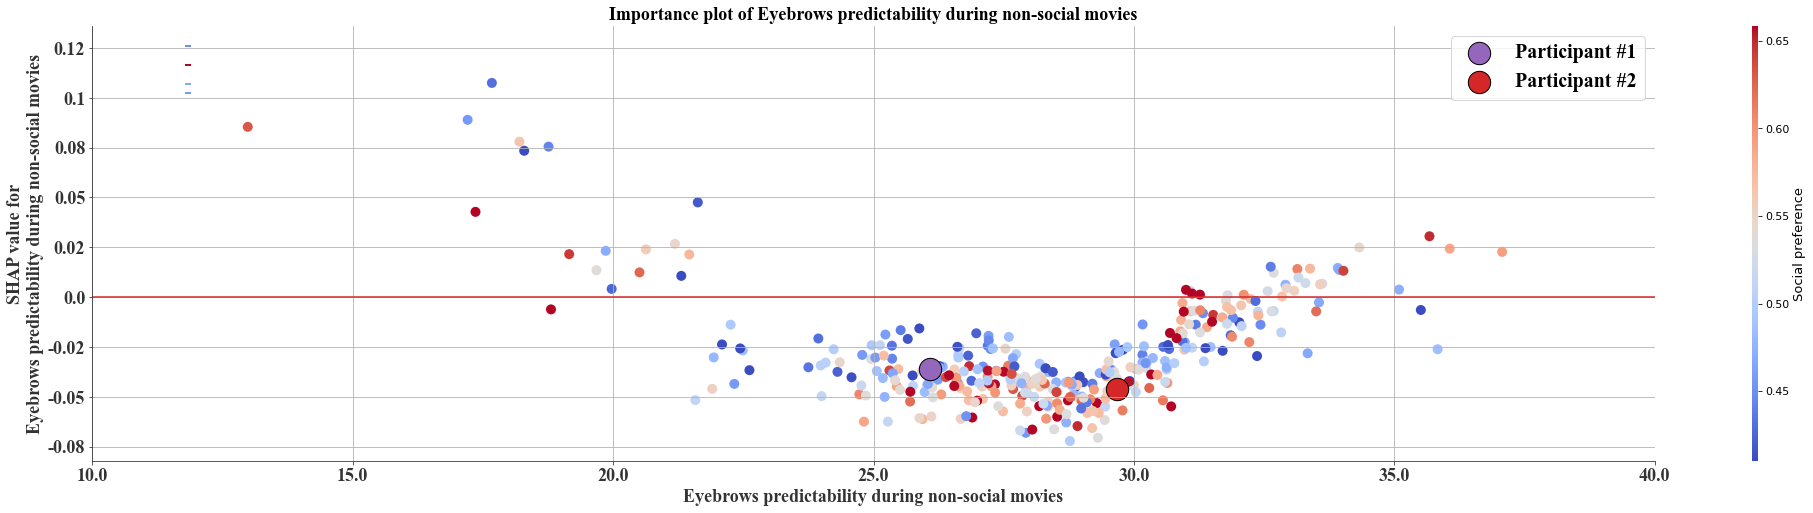

0.34


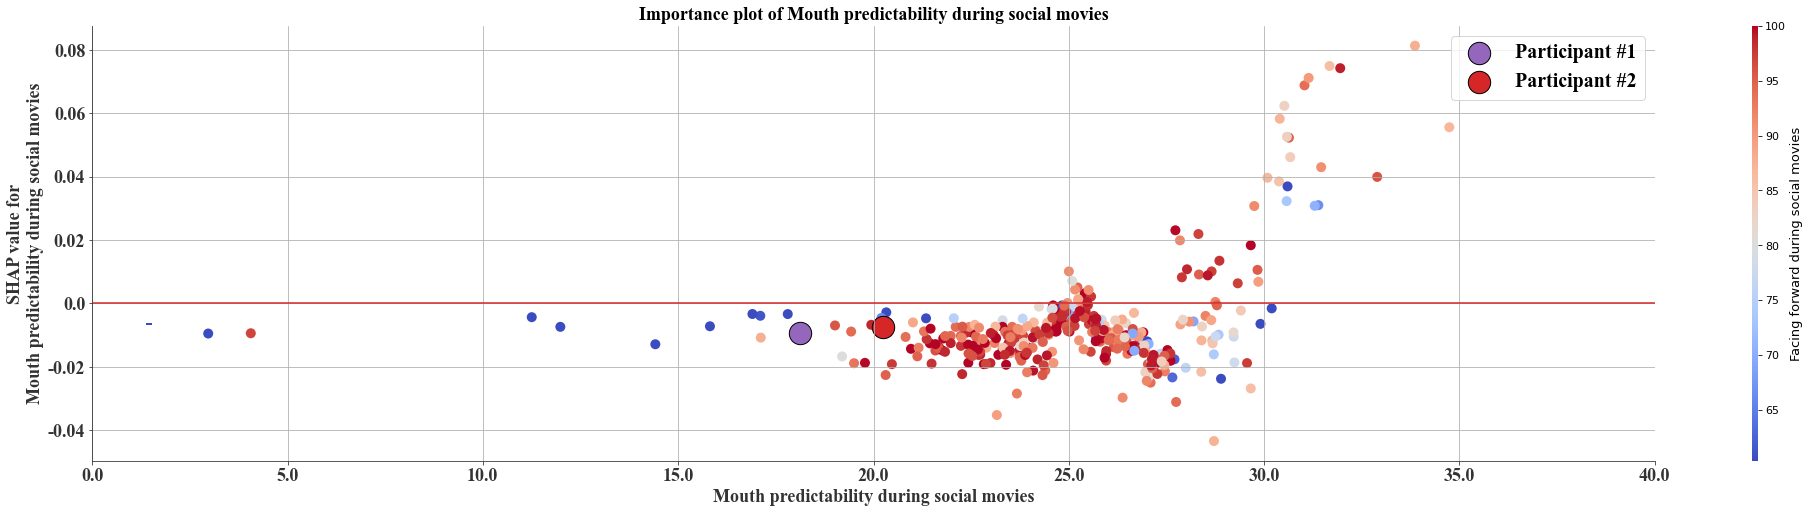

0.35


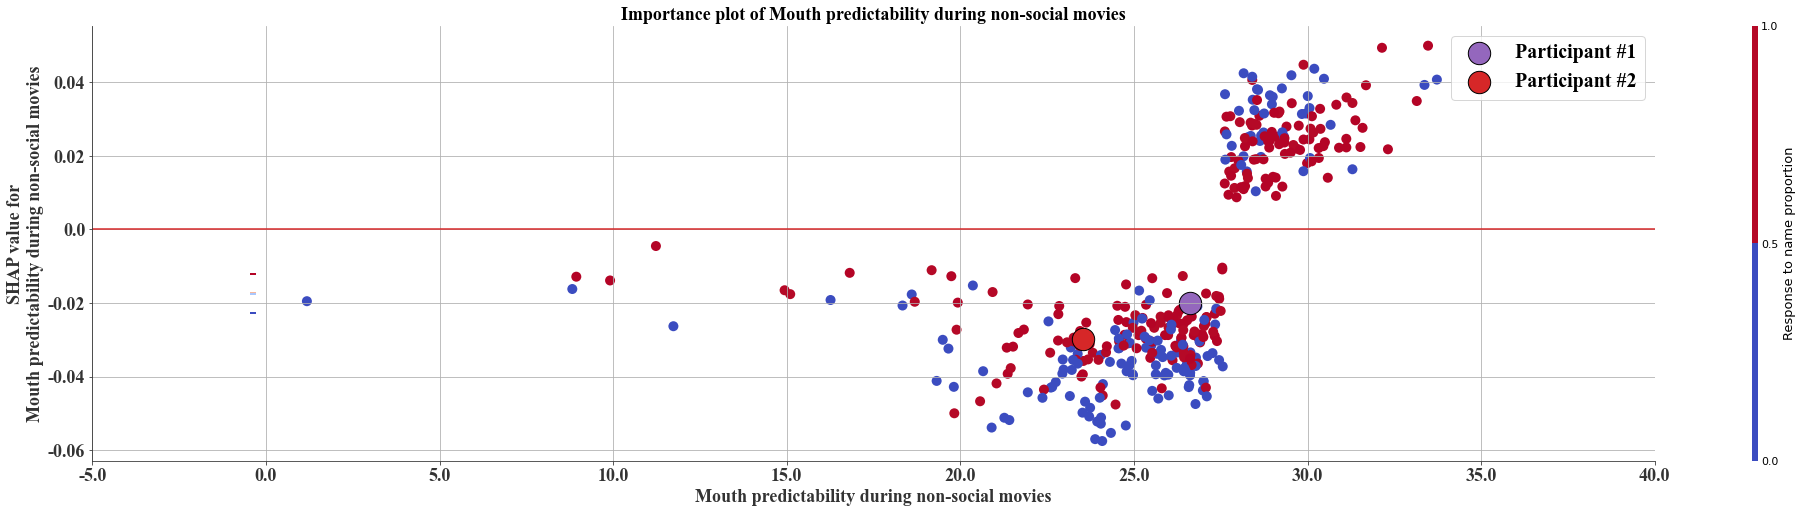

0.13


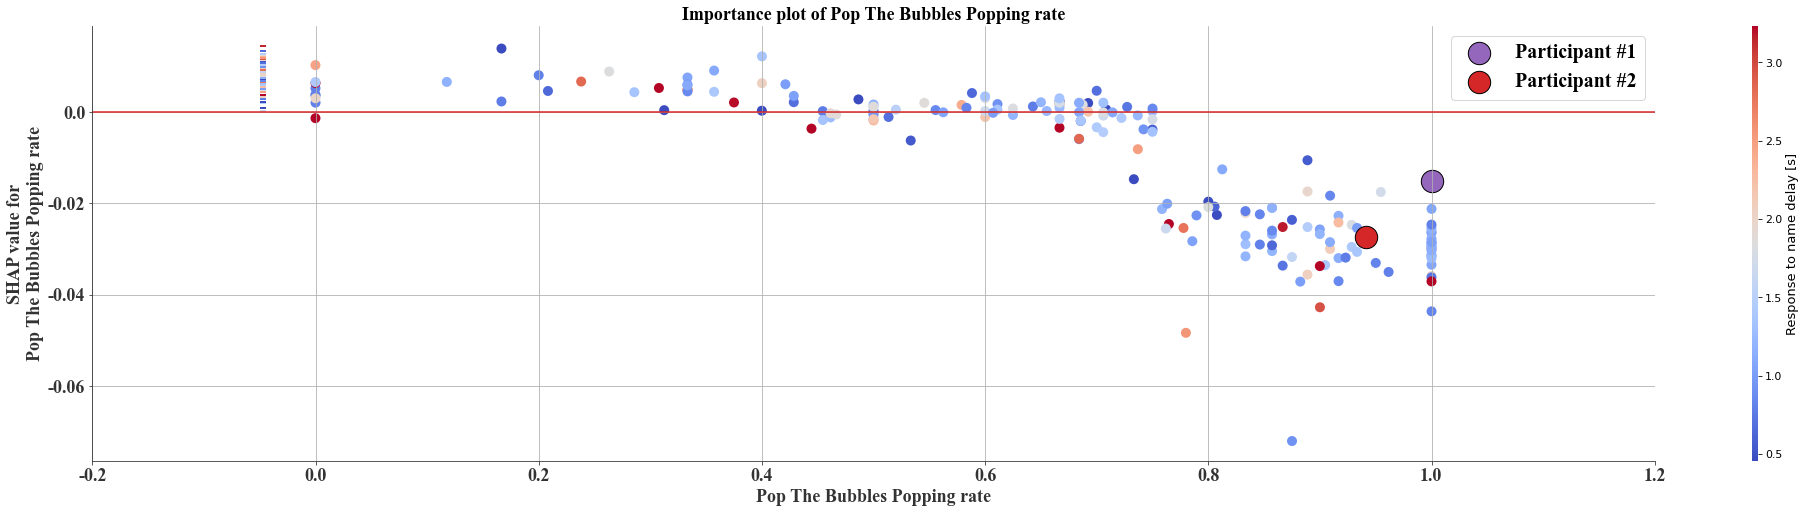

0.39


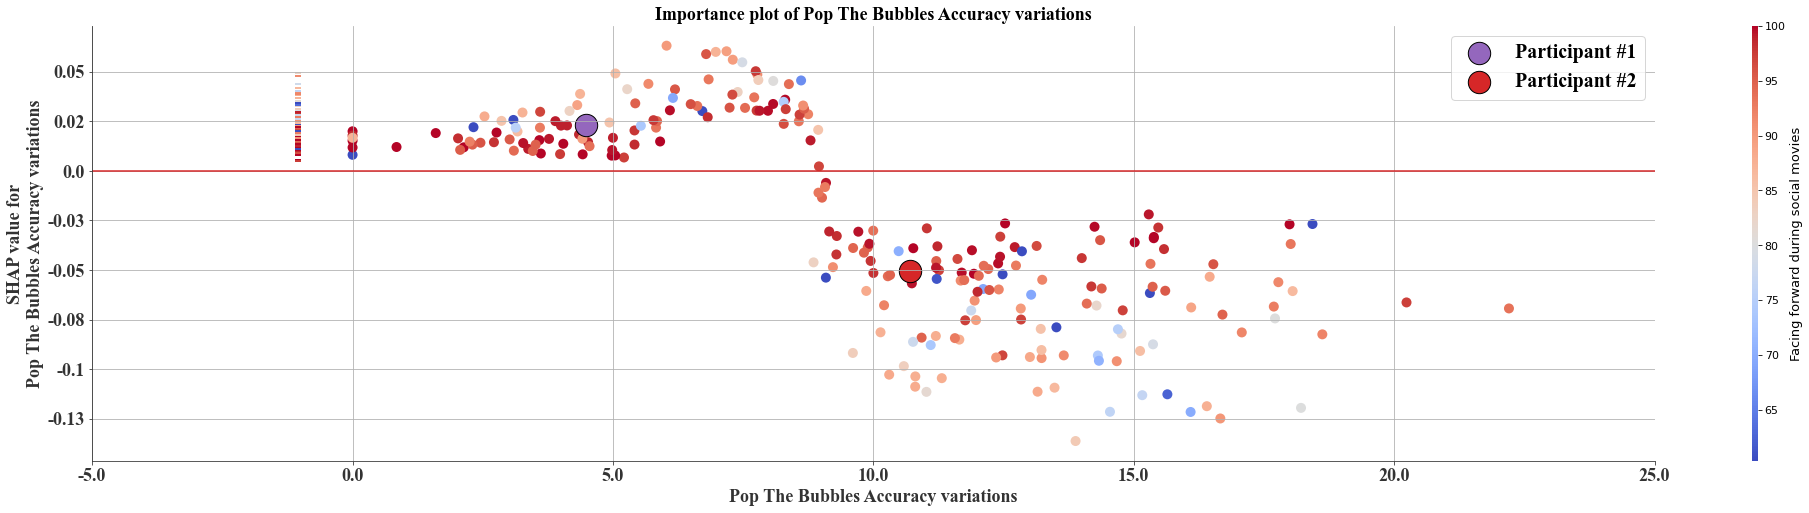

0.07


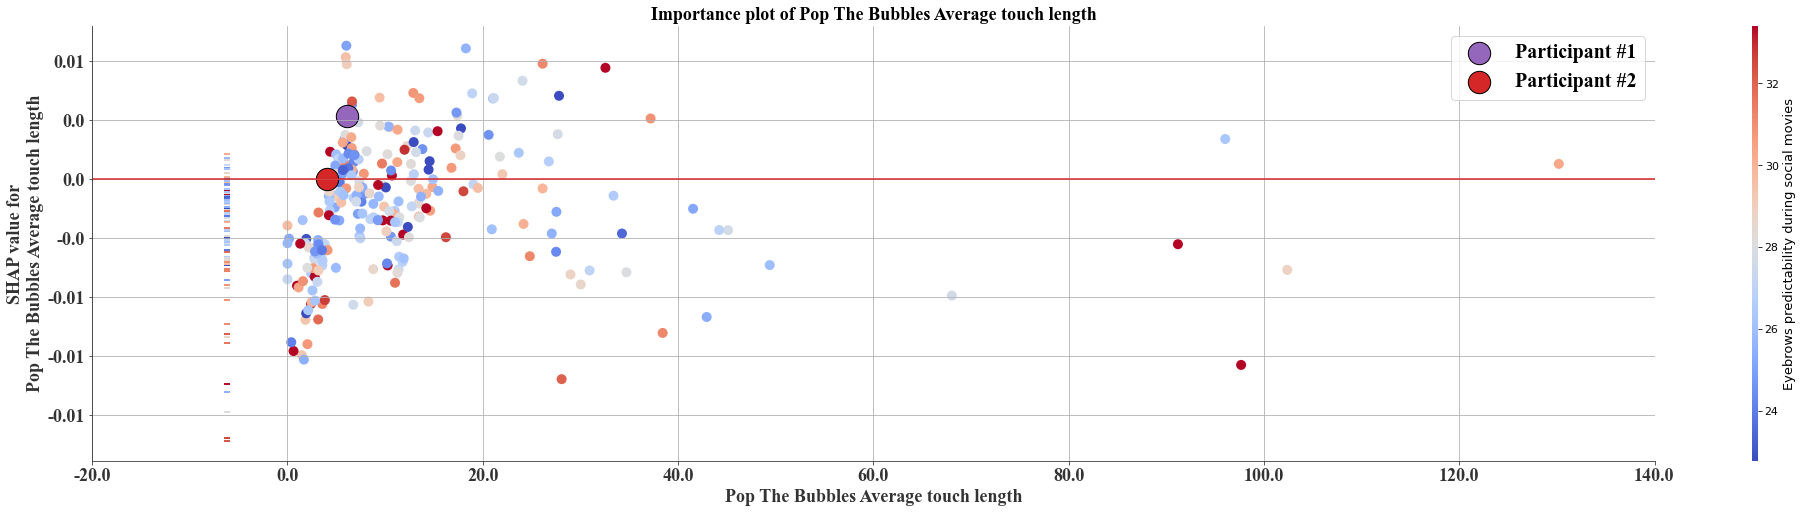

0.14


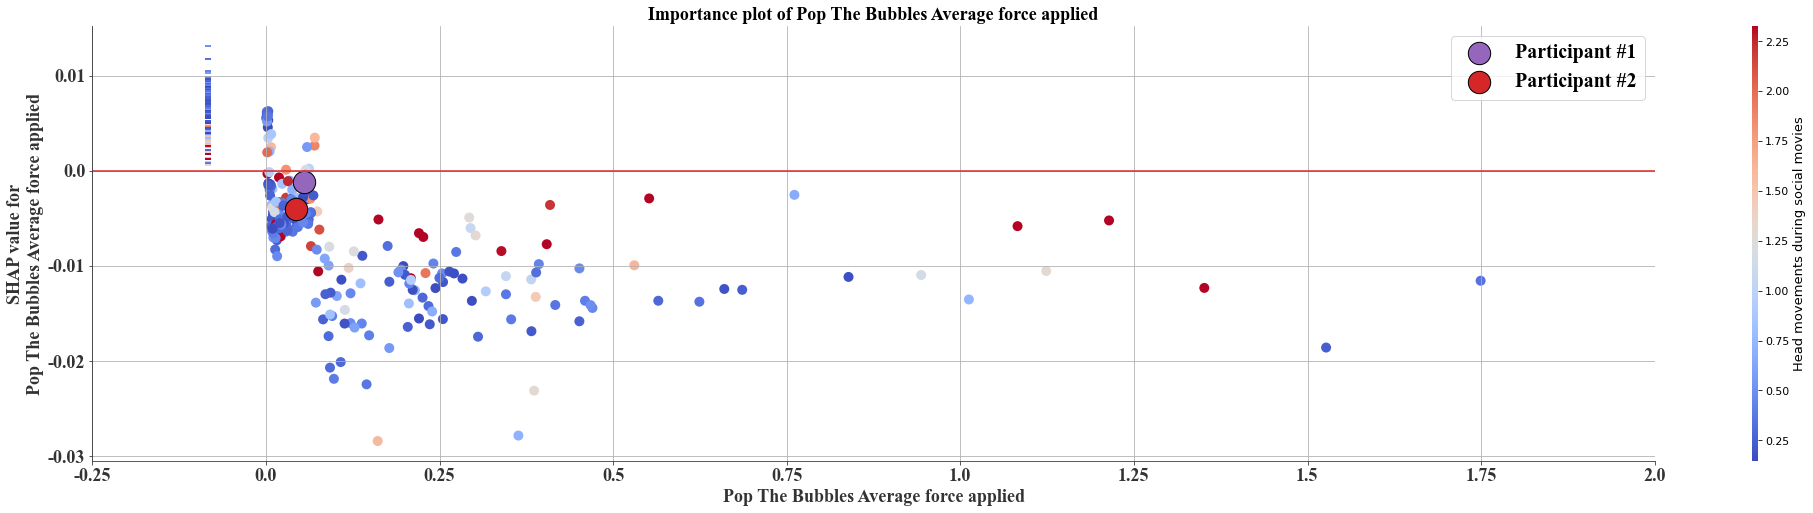

In [126]:
import matplotlib
csfont = {'fontname': 'Times New Roman'}
# Draw a random smaple and plot the shap matrix
averaged_shap_normalized = averaged_shap_interactions_normalized.sum(axis=1)

df_shap_interaction_importance = pd.DataFrame(np.abs(averaged_shap_interactions_normalized).mean(axis=0), columns=[feature_name_mapping[f] for f in exp.features_name], index=[feature_name_mapping[f] for f in exp.features_name])


X = pd.DataFrame(exp.dataset._X_train, columns=exp.features_name)
X.rename(columns=feature_name_mapping, inplace=True)
import shap
index_samples = [66, 165]
from matplotlib.pylab import pcolor, colorbar


for i, feat in enumerate(exp.features_name):
    
    feature_name = feature_name_mapping[feat]
    
    most_interacting_feature  = df_shap_interaction_importance.loc[feature_name].nlargest(2).index[1]
    
    fig, ax = plt.subplots(1, 1, figsize=(35, 8))
    ax.axhline(0, color='tab:red')
    ax.set_title("Importance plot of {}".format(feature_name), weight='bold', fontsize=18)
    
    fig = shap.dependence_plot(feature_name, averaged_shap_normalized, X, [feature_name_mapping[f] for f in exp.features_name], x_jitter=0.1, dot_size=100, interaction_index=most_interacting_feature, cmap=matplotlib.cm.coolwarm, ax=ax, show=False)
    
    
    plt.gca().set_title(plt.gca().get_title(), weight='bold', fontsize=18, **csfont)
    plt.gca().set_xlabel(plt.gca().get_xlabel(), weight='bold', fontsize=18, **csfont)
    plt.gca().set_ylabel(plt.gca().get_ylabel(), weight='bold', fontsize=18, **csfont)
    plt.gca().grid()
    plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
    plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
    
    plt.gca().scatter([X.to_numpy()[index_samples[0], i]], [averaged_shap_normalized[index_samples[0], i]], s=500, color='#9467bd', edgecolors='k',  label='Participant #1')
    plt.gca().scatter([X.to_numpy()[index_samples[1], i]], [averaged_shap_normalized[index_samples[1], i]], s=500, color='#d62728', edgecolors='k', label='Participant #2')
    plt.gca().legend(prop={'size':20, 'family':'times new roman', 'weight':'bold'})
    print(best_interaction.loc[feature_name]['Value'])
    plt.show()
    #plt.savefig(os.path.join(ROOT_DIR, 'figures', '{}_dependence.png'.format(feature_name)), dpi=200, bbox_inches = 'tight')

